In [32]:
#Import libraries 
import inspect
import time
import warnings
import matplotlib.pyplot as plt
import pandas as pd
import plotly.express as px
import seaborn as sns
import pandas_datareader.data as web
from scipy.stats import t as tstats
import numpy as np
from datetime import datetime
import statsmodels.api as sm
import matplotlib.pyplot as plt
from scipy.stats import norm
from statsmodels.stats.diagnostic import acorr_ljungbox
from scipy.stats import shapiro, anderson, kstest
from statsmodels.graphics.gofplots import qqplot
from math import sqrt
from sklearn.metrics import mean_squared_error

from sklearn.metrics import mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
import yfinance as yf
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_absolute_error
from sigtools import signature
from esig import tosig as ts
import warnings
from sklearn.exceptions import ConvergenceWarning

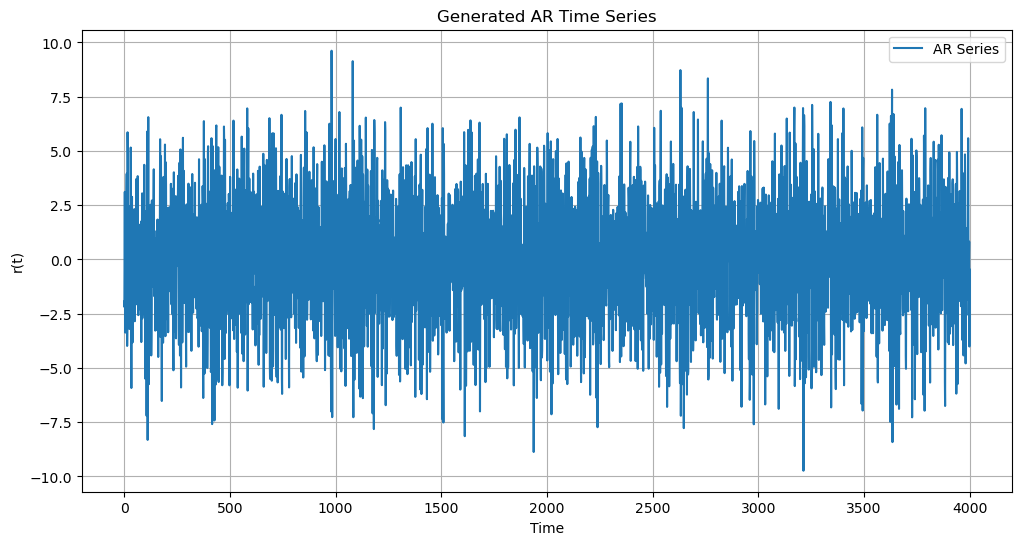

In [349]:
# ARMA series generator function
def arma_generate(ar_params, ma_params, num_samples):
    # Error term (white noise)
    error = np.random.normal(scale=2, size=num_samples)

    # Initialize the time series with zeros
    arma_series = np.zeros(num_samples)
    
    # Set the first value of the time series
    arma_series[0] = error[0]

    # Consider past values for initial samples (p + q)
    for i in range(1, len(ar_params) + len(ma_params)):
        if len(ar_params) > 1:
            # We take the amount of past values as len(ar_params)-1
            past_values = arma_series[max(0, i-len(ar_params)+1):i]
            k = len(past_values)
        if len(ma_params) == 0:
            if k < len(ar_params):
                arma_series[i] = np.sum(ar_params[-k-1:-1] * past_values) + error[i] + ar_params[-1]
            else:    
                arma_series[i] = np.sum(ar_params[:-1] * past_values) + error[i] + ar_params[-1]
        else:
            if k < len(ar_params):
                if i == 1:
                    arma_series[i] = np.sum(ar_params[-k-1:-1] * past_values) + ar_params[-1] + error[i] + ma_params[-1] * error[0] 
                else:
                    arma_series[i] = np.sum(ar_params[-k-1:-1] * past_values) + ar_params[-1] + error[i] + np.sum(ma_params * error[i-len(ma_params):i])  
            else:    
                arma_series[i] = np.sum(ar_params[:-1] * past_values) + ar_params[-1] + error[i] + np.sum(ma_params * error[i-len(ma_params):i])

    # Generate remaining samples using the ARMA model
    for i in range(len(ar_params) + len(ma_params), num_samples):
        past_values = arma_series[i-len(ar_params)+1:i]
        arma_series[i] = np.sum(ar_params[:-1] * past_values) + ar_params[-1] + error[i] + np.sum(ma_params * error[i-len(ma_params):i])

    return arma_series

# Parameters for the ARMA series
ar_params = [0, 0.4, -0.5, -0.2]
ma_params = []
num_samples = 4000

# Reverse ar_params to compute the product properly
ar_params = ar_params[::-1]
ma_params = ma_params[::-1]

# Generate the AR series using the generator and given parameters
arma_series = arma_generate(ar_params, ma_params, num_samples)

# Plot the generated AR series
plt.figure(figsize=(12, 6))
plt.plot(arma_series, label='AR Series')
plt.title('Generated AR Time Series')
plt.xlabel('Time')
plt.ylabel('r(t)')
plt.legend()
plt.grid(True)
plt.show()

In [350]:
# split into train and test sets
size = int(len(arma_series) * 0.80)
train, test = arma_series[0:size], arma_series[size:len(arma_series)]
history = [x for x in train]
predictions = list()

In [122]:
# walk-forward validation
for i in range(len(test)):
    arma_model = ARIMA(history, order=(len(ar_params), 0, len(ma_params)))
    model_fit = arma_model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[i]
    history.append(obs)
    #print('predicted=%f, expected=%f' % (yhat, obs))


Test RMSE: 1.017


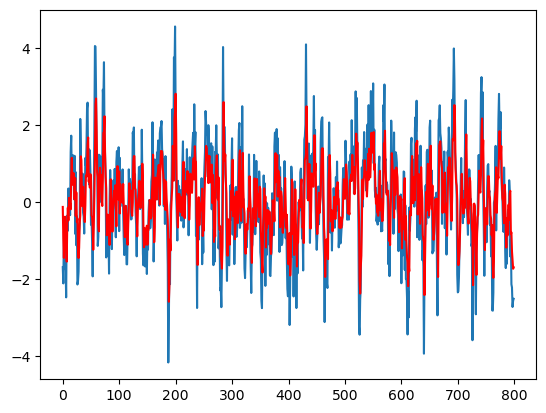

In [364]:
# Assuming 'test' and 'predictions' are defined elsewhere in your code

# Calculate RMSE
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)

# Plot forecasts against actual outcomes
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()

ValueError: operands could not be broadcast together with shapes (7,) (10,) 

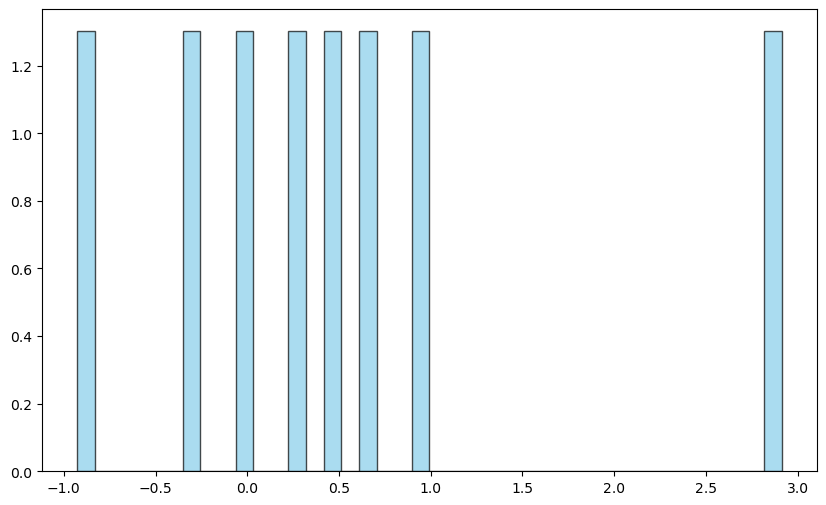

In [123]:
# Assuming 'test' and 'predictions' are defined elsewhere in your code

# Calculate residuals
residuals = np.array(test) - np.array(predictions)

# Plot histogram of residuals
plt.figure(figsize=(10, 6))
plt.hist(residuals, bins=40, density=True, color='skyblue', edgecolor='black', alpha=0.7, label='Residuals')

# Check for autocorrelation using the Ljung-Box test
lb_test = acorr_ljungbox(residuals, lags=[10], return_df=True)
print("Ljung-Box Test:", lb_test)


# Fit a normal distribution to the data
mu, std = norm.fit(residuals)
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2, label='Gaussian fit')

plt.title('Residuals Distribution')
plt.xlabel('Residuals')
plt.ylabel('Density')
plt.legend()
plt.grid(True)
plt.show()

# Test for normality using the Anderson-Darling test
anderson_test = anderson(residuals)
print("Anderson-Darling Test:", anderson_test)

# Confidence Intervals for RMSE
alpha = 0.05  # Significance level
n = len(residuals)
mse = mean_squared_error(test, predictions)
standard_error = np.sqrt(mse / n)

# Calculate t-value for the given significance level and degrees of freedom
t_value = tstats.ppf(1 - alpha / 2, df=n-1)

# Calculate confidence interval for RMSE
lower_bound = np.sqrt(mse) - t_value * standard_error
upper_bound = np.sqrt(mse) + t_value * standard_error

print(f'Confidence Interval for RMSE: [{lower_bound:.3f}, {upper_bound:.3f}]')



In [57]:
#Using the Ljung-Box test we can check that we cannot say that residuals are correlated.
#With a test statistic of 0.686 and critical values ranging from 0.562 to 1.065 (will change depending on run of the code), the Anderson-Darling test result indicates that the residuals likely follow a normal distribution at a significance level greater than 10 percent but less than 5 percent.

In [58]:
#The lower bound of the confidence interval represents the lower limit below which we are 95% confident that the true RMSE lies.
#The upper bound of the confidence interval represents the upper limit above which we are 95% confident that the true RMSE lies.
#If the confidence interval is narrow, it indicates greater precision in our RMSE estimate.
#If the confidence interval does not include zero, it suggests that the RMSE estimate is statistically significant and different from zero at the 95% confidence level.
#Conversely, if the confidence interval includes zero, it implies that the RMSE estimate is not statistically significant at the 95% confidence level, and the model performance may not be significantly different from random guessing.

#In our case, maybe it will mean that we have some info missing
#Comparison with Benchmarks: The confidence interval allows us to compare the model's performance against benchmarks or alternative models. 
#If the upper bound of the confidence interval is smaller than the RMSE of a benchmark model, it suggests that our model performs better than the benchmark with a certain level of confidence.

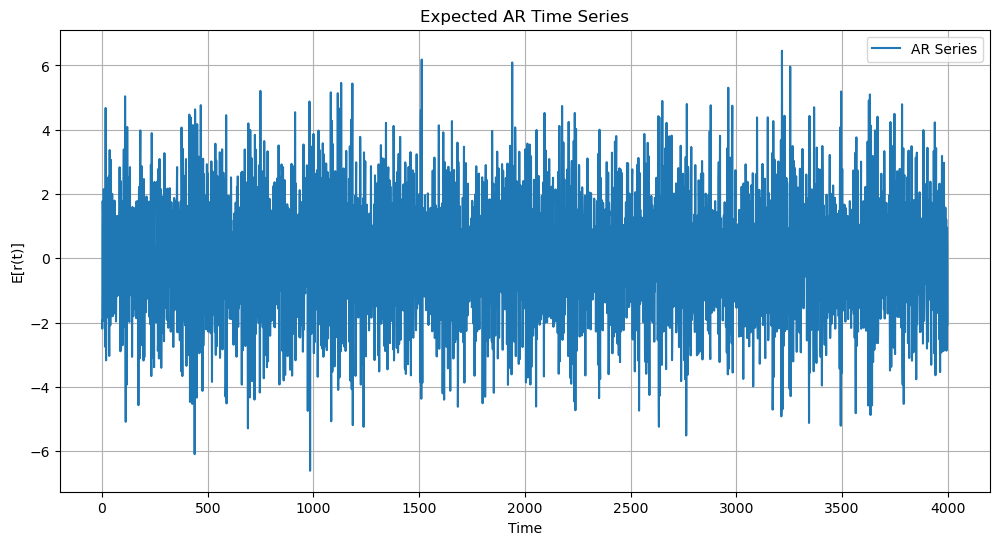

[-1.94688317 -2.18915712  0.75028539  1.78406935  1.30803775]
[-1.94688317 -2.18915712  0.75028539  3.11337254 -0.06211326]


In [399]:
def arma_generate_expected(ar_params, ma_params, arma_series):
    # Initialize the time series with zeros
    arma_expected = np.zeros(len(arma_series))
    
    prev = len(ar_params)
    arma_expected[:prev-1] = arma_series[:prev-1]
    
    # Generate remaining samples using the ARMA model for the expected next step
    for i in range(prev-1, len(arma_series)):
        past_values = arma_series[i-prev+1: i]
        arma_expected[i] = np.sum(ar_params[:-1] * past_values) + ar_params[-1]

    return arma_expected

ar_params = [0, 0.4, -0.5, -0.2]
ma_params = []
ar_params = ar_params[::-1]
ma_params = ma_params[::-1]
arma_expected = arma_generate_expected(ar_params, ma_params, arma_series)
# Plot the generated ARMA expected
plt.figure(figsize=(12, 6))
plt.plot(arma_expected, label='AR Series')
plt.title('Expected AR Time Series')
plt.xlabel('Time')
plt.ylabel('E[r(t)]')
plt.legend()
plt.grid(True)
plt.show()


print(arma_expected[:5])
print(arma_series[:5])

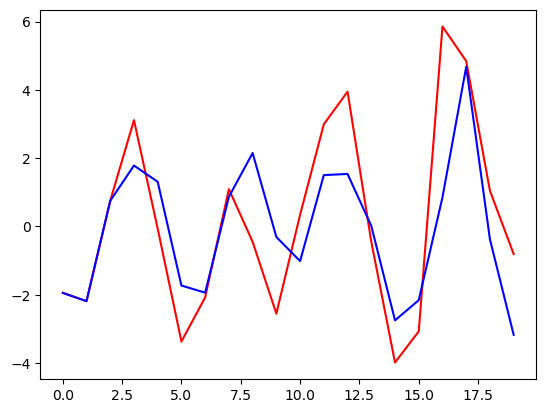

IndexError: list index out of range

In [352]:
# Plot forecasts against actual outcomes
arma_expected_test = arma_expected[-len(test):]
plt.plot(arma_series[:20], color='red')
plt.plot(arma_expected[:20], color='blue')
plt.show()

# Calculate MSE
mse = 0
for i in range(len(arma_expected_test)):
    mse += (arma_expected_test[i] - predictions[i]) ** 2
mse = mse/len(arma_expected_test)
print('Test MSE: %.3f' % mse)

In [166]:
# Fit a simple linear regression model
model = sm.OLS(predictions, arma_expected_test).fit()

# Calculate R^2 and adjusted R^2
r_squared = model.rsquared
adjusted_r_squared = model.rsquared_adj

print("R^2:", r_squared)
print("Adjusted R^2:", adjusted_r_squared)

# Display the regression summary
print(model.summary())

# Scatter plot with regression line
plt.scatter(arma_expected_test, predictions, color='blue', label='Data')
plt.plot(arma_expected_test, model.predict(arma_expected_test), color='red', label='Regression Line')
plt.xlabel('arma_expected')
plt.ylabel('predictions')
plt.legend()
plt.title("Regression Line between arma_expected and predictions")
plt.show()

ValueError: endog and exog matrices are different sizes

In [ ]:
#AR model regression did a proper approximation of the parameters of our time series and provided this fitted results.

**Let's compute the prediction using the SIGNATURE**

In [28]:
#Helper function to extract a rolling window
#We need to specify both historical window and future window
#to make sure that our matrix is consistent
def GetWindows(x, h_window, f_window):
    """
    Generates rolling windows from the input time series data.

    Args:
    x (DataFrame): Input time series data.
    h_window (int): Size of each rolling window.
    f_window (int): Number of future time steps to predict.

    Returns:
    ndarray: Array of arrays representing rolling windows.
    """
    # Initialize an empty list to store rolling windows
    windows = [np.array(x.iloc[0:h_window, :])]

    # Create rolling windows
    for i in range(1, len(x) - h_window + 1):
        window = np.array(x.iloc[i:i + h_window, :])
        windows.append(window)

    # Convert the list of arrays to a NumPy array
    windows_array = np.array(windows)
    
    # Cut the end that we can't use to predict future price
    rolling_window = windows_array[:-f_window, :, :]

    return rolling_window

def GetFutureWindows(x, h_window, f_window):
    # Initialize the list of windows
    future_windows = [np.array(x.iloc[h_window-1:h_window+f_window, :])]

    # Create rolling windows
    for i in range(1, len(x) - h_window):
        window = np.array(x.iloc[i + h_window - 1:i + h_window + f_window, :])
        future_windows.append(window)

    # Convert the list of arrays to a NumPy array
    future_windows_array = np.array(future_windows)
    

    return future_windows_array

    

#input = panda, historical window, future window
def GetNextMean(x,h_window,f_window):
    return pd.DataFrame((x.rolling(f_window).mean().iloc[h_window+f_window-1:,]))

#Function add time to the data set
def augment_path_image(path_image):
    """
    Augments the path image with another coordinate representing the time series index.

    Args:
    path_image (ndarray): Original path image as a numpy array.

    Returns:
    ndarray: Augmented path image with an additional coordinate for the time series index.
    """
    # Ensure path_image is a 1D or 2D array
    if len(path_image.shape) == 1:
        # If path_image is 1D, reshape it to a column vector
        path_image = path_image[:, np.newaxis]

    # Determine the length of the time series
    series_length = path_image.shape[0]

    # Create an array of time series indices
    time_indices = np.arange(series_length)[:, np.newaxis]

    # Augment the original path image with time series indices
    augmented_image = np.concatenate((time_indices, path_image), axis=1)

    return augmented_image

In [29]:
# Function to compute signatures
"""def compute_signatures(X, h_window, f_window, sig_level):
    #Compute length of signature
    l = 2**(sig_level+1)-1
    
    # Pre-allocate the array for signatures
    #X_sig = np.empty((len(X) - f_window - h_window + 1, l))  # Assuming the signature has sig_level dimensions
    
    # Compute the first signature
    X_sig = [ts.stream2sig(X[0:h_window-1], sig_level)]
    
    # Compute the rest of the signatures
    for i in range(1, len(X) - f_window - h_window + 1):
        stream_i = X[i: i + h_window - 1]
        signature_i = [ts.stream2sig(stream_i, sig_level)]
        X_sig = np.append(X_sig, signature_i, axis=0)
        
    return X_sig"""

def compute_signatures(windows, sig_level):
    #Compute length of signature depending on the sig_level
    l = 2**(sig_level+1)-1
    X_sig = [ts.stream2sig(windows[0], sig_level)]
    for i in range(1, len(windows)):
        signature_i = [ts.stream2sig(windows[i], sig_level)]
        X_sig = np.append(X_sig, signature_i, axis=0)
    return X_sig

def compute_signature(X, sig_level):
    # Compute the first signature
    X_sig = [ts.stream2sig(X, sig_level)]
        
    return X_sig

def trainning(X, y):
        '''
        Trains the model using signatures.
        
        x: list of inputs
        y: list of outputs.
        '''
        # Suppress only ConvergenceWarning
        warnings.filterwarnings("ignore", category=ConvergenceWarning)
        reg = Lasso(alpha=0.001, max_iter=10000)
        reg.fit(X, y)
        coefficients = reg.coef_
        #print([f"{coef:.7f}" for coef in coefficients])
        
        # Predict values
        y_pred = reg.predict(X)
        
        return reg, y_pred
    

In [30]:
def predictions_signature(data, data_expected, train_size, h_window, p_sig_degree, q_sig_degree):
    f_window = 1
    
    if len(data_expected) == 0:
        #We compute the signatures for the windows
        series_df = pd.DataFrame(data)
        series_windows = GetWindows(series_df, h_window, f_window)
        series_future_windows = GetFutureWindows(series_df, h_window, f_window)
        
    else:
        #We compute the signatures for the windows
        series_df = pd.DataFrame(data)
        expected_df = pd.DataFrame(data_expected)
        series_windows = GetWindows(series_df, h_window, f_window)
        series_future_windows = GetFutureWindows(expected_df, h_window, f_window)
        #print("past windows:", series_windows)
        #print("future windows", series_future_windows)
        
    series_windows_base = []
    for window in series_windows:
        elem = augment_path_image(window)
        series_windows_base.append(np.vstack([[-1,0], elem]))
    #print(series_windows_base)
    series_fut_windows_base = []
    for fut_window in series_future_windows:
        elem = augment_path_image(fut_window)
        series_fut_windows_base.append(np.vstack([[-1,0], elem]))
    #print(series_windows_base)
    #print(series_fut_windows_base)
    #Here we have all signatures for each window
    X_sig = compute_signatures(series_windows_base, p_sig_degree)
    Y_sig = compute_signatures(series_fut_windows_base, q_sig_degree)

        
    #We use the GetNextMean with a future window of 1, so it is the same as the future value we want to predict
    #Y_real = np.array(GetNextMean(series_augm_df, h_window, f_window)[1])

    #Y_expected = np.array(arma_expected[h_window:])

    #We now separate between training and testing
    X_sig_train = X_sig[:train_size-h_window]
    Y_sig_train = Y_sig[:train_size-h_window]

    X_sig_test = X_sig[train_size-h_window:]
    Y_sig_test = Y_sig[train_size-h_window:]
        


    predictions_sig = list()
    variances = list()

    #scaler = StandardScaler()
    #history_sig_scaled = scaler.fit_transform(history_sig)  # Scale features to have mean 0 and standard deviation 1
    lasso_model, train_pred = trainning(X_sig_train, Y_sig_train)
    # walk-forward validation
    for i in range(0, len(X_sig_test)):
        predict = lasso_model.predict(X_sig_test[i].reshape(1, -1))
        yhat = predict[0][2]
        #yhat = predict[0][2]
        predictions_sig.append(yhat)
        variances.append(2*predict[0][6])
            
    return predictions_sig, variances, train_pred, Y_sig_train

<class 'numpy.ndarray'>
[-1.94688317 -2.18915712  0.75028539  3.11337254 -0.06211326 -3.37278965
 -2.07897565  1.09193377 -0.44919296 -2.55521478]
(4000,)
Training X and Y
[[ 1.00000000e+00  3.00000000e+00  7.50285392e-01 ...  8.86742635e+00
  -2.10765305e+00  1.32036718e-02]
 [ 1.00000000e+00  3.00000000e+00  3.11337254e+00 ...  8.26863919e+00
   8.92865053e-01  3.91483193e+00]
 [ 1.00000000e+00  3.00000000e+00 -6.21132641e-02 ... -8.93906428e+00
   2.90149982e+00  6.20192012e-07]
 ...
 [ 1.00000000e+00  3.00000000e+00 -8.45602810e-01 ... -1.47560504e+01
   3.62690057e+00  2.13036701e-02]
 [ 1.00000000e+00  3.00000000e+00 -5.51439969e+00 ... -1.12206929e+01
  -8.11710610e+00  3.85284663e+01]
 [ 1.00000000e+00  3.00000000e+00  2.15962724e-01 ...  4.73567072e+01
  -1.49965130e+01  9.06366711e-05]]
[[ 1.00000000e+00  2.00000000e+00  3.11337254e+00 ...  3.91977342e+00
   2.30697166e+00  4.84654429e+00]
 [ 1.00000000e+00  2.00000000e+00 -6.21132641e-02 ... -3.20654244e+00
   3.08231591e+00

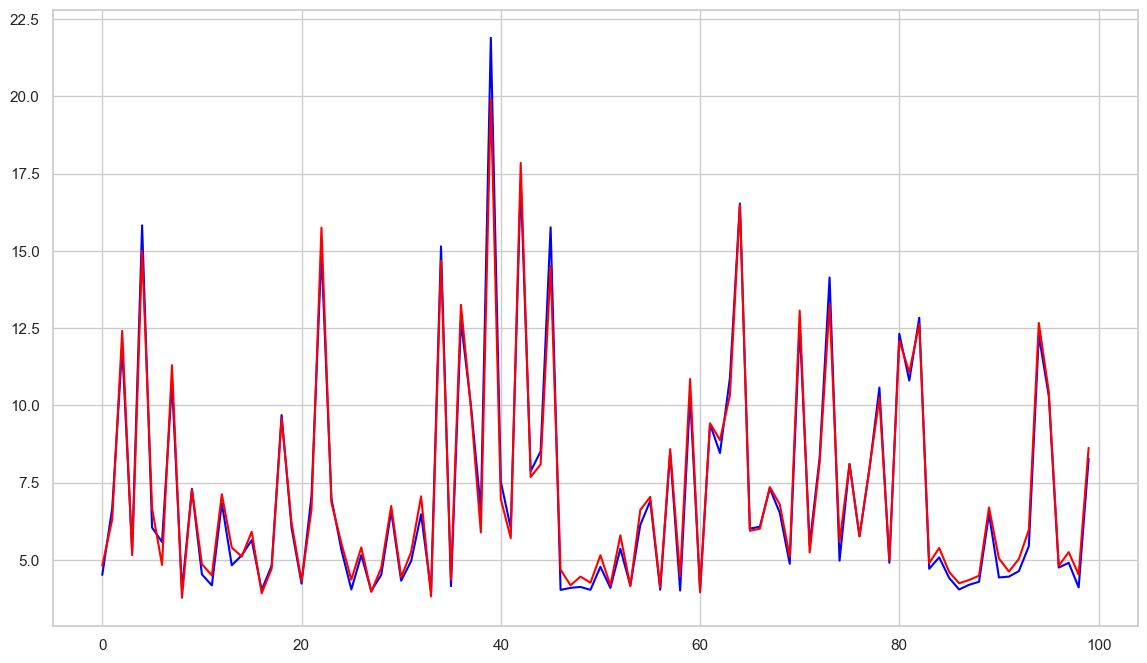

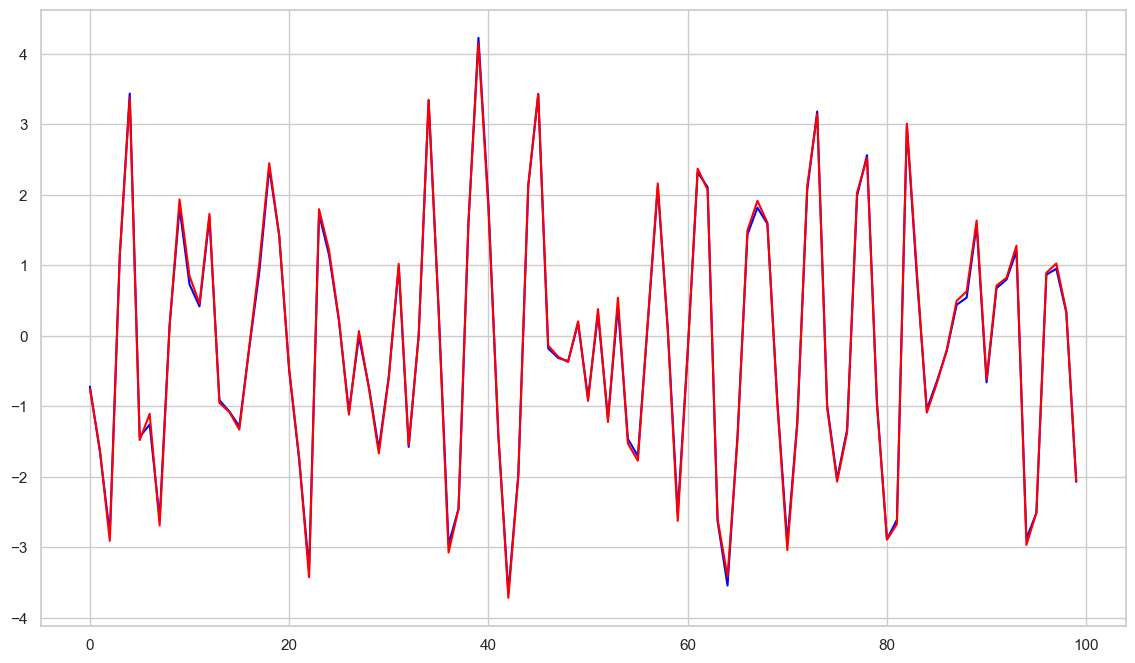

Test MSE: 0.46036135
Test MSE: 0.00573579


In [627]:
#We use the arma_series for the past and expected value for the future in order to train, then test with expected arma_series
predictions_sig, variances_sig train_pred = predictions_signature(arma_series, arma_series, int(len(arma_series)*0.8), 3, 4, 2)

#Plot E[r^2|Fk]
# Plot forecasts against actual outcomes
plt.plot(arma_expected[-100:]**2 + 4, color='blue')
plt.plot(variances_sig[-100:], color='red')
plt.show()

#Calculate variance
variances = list()
for i in range(len(variances_sig)):
    variances.append(variances_sig[i]-predictions_sig[i]**2)


arma_test = arma_expected[-len(predictions_sig):]
    
# Plot forecasts against actual outcomes
plt.plot(arma_test[-100:], color='blue')
plt.plot(predictions_sig[-100:], color='red')
plt.show()

# Calculate MSE
mse1 = 0
for i in range(len(arma_test)):
    mse1 += (arma_test[i]**2+4 - variances_sig[i]) ** 2
mse1 = mse1 / len(arma_test)
print('Test MSE: %.8f' % mse1)
    
# Calculate MSE
mse2 = 0
for i in range(len(arma_test)):
    mse2 += (arma_test[i] - predictions_sig[i]) ** 2
mse2 = mse2 / len(arma_test)
print('Test MSE: %.8f' % mse2)
    

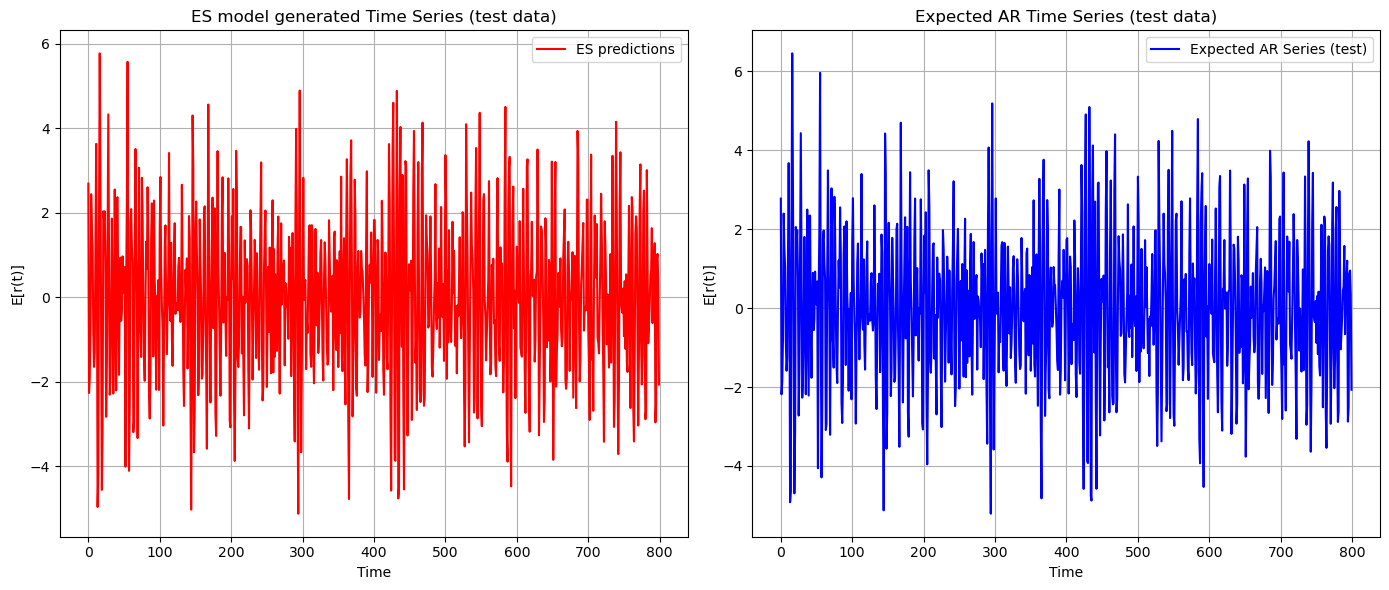

In [426]:
# Create a figure with 1 row and 2 columns
plt.figure(figsize=(14, 6))

# Plot the ES predictions in the first subplot
plt.subplot(1, 2, 1)
plt.plot(predictions_sig, label='ES predictions', color='red')
plt.title('ES model generated Time Series (test data)')
plt.xlabel('Time')
plt.ylabel('E[r(t)]')
plt.legend()
plt.grid(True)

# Plot the expected AR series in the second subplot
plt.subplot(1, 2, 2)
plt.plot(arma_expected[-len(predictions_sig):], label='Expected AR Series (test)', color='blue')
plt.title('Expected AR Time Series (test data)')
plt.xlabel('Time')
plt.ylabel('E[r(t)]')
plt.legend()
plt.grid(True)

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

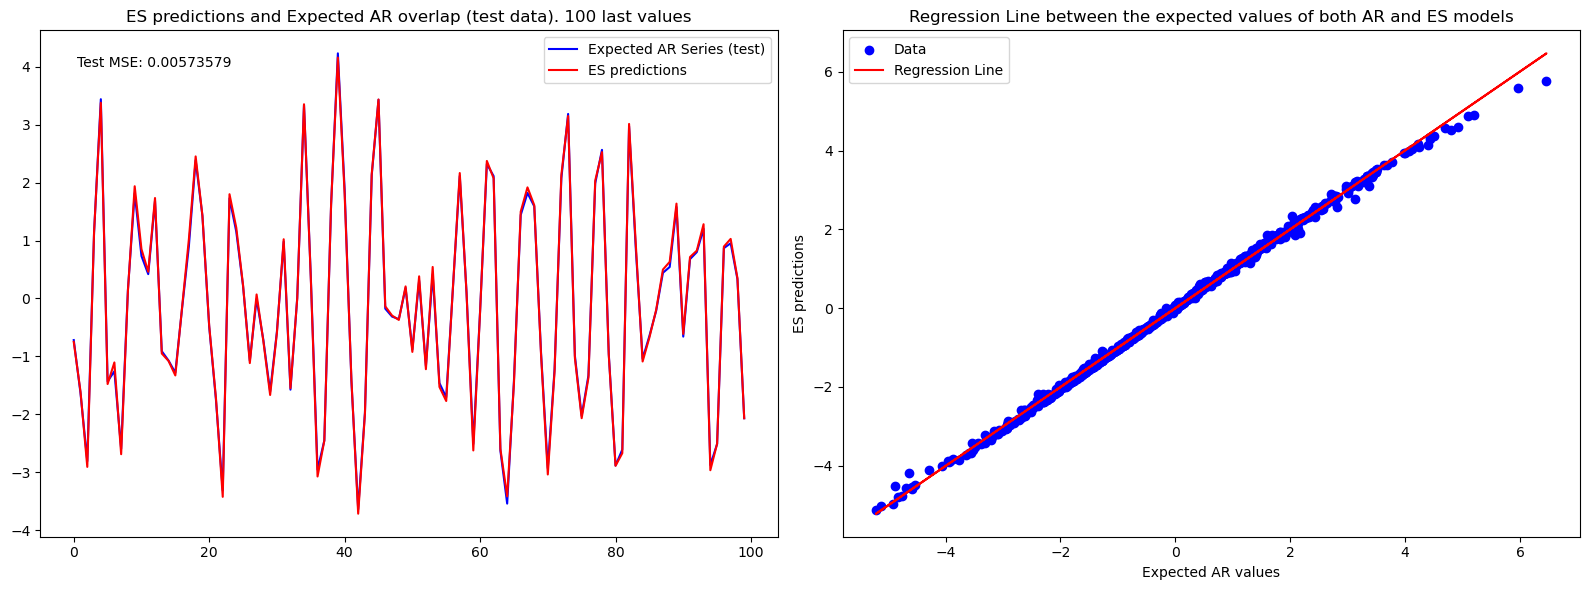

In [427]:
# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot forecasts against actual outcomes
axes[0].plot(arma_expected[-100:], label='Expected AR Series (test)', color='blue')
axes[0].plot(predictions_sig[-100:], color='red', label='ES predictions')
axes[0].set_title('ES predictions and Expected AR overlap (test data). 100 last values')
axes[0].legend()

# Calculate MSE
mse = sum((arma_test - predictions_sig) ** 2) / len(arma_test)
axes[0].text(0.05, 0.95, f'Test MSE: {mse:.8f}', transform=axes[0].transAxes, verticalalignment='top')

# Fit a simple linear regression model
model = sm.OLS(predictions_sig, arma_expected_test).fit()

# Calculate R^2 and adjusted R^2
r_squared = model.rsquared
adjusted_r_squared = model.rsquared_adj

axes[1].scatter(arma_expected_test, predictions_sig, color='blue', label='Data')
axes[1].plot(arma_expected_test, model.predict(arma_expected_test), color='red', label='Regression Line')
axes[1].set_xlabel('Expected AR values')
axes[1].set_ylabel('ES predictions')
axes[1].legend()
axes[1].set_title("Regression Line between the expected values of both AR and ES models")

plt.tight_layout()
plt.show()

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.994
Model:                            OLS   Adj. R-squared (uncentered):              0.994
Method:                 Least Squares   F-statistic:                          1.407e+05
Date:                Thu, 30 May 2024   Prob (F-statistic):                        0.00
Time:                        11:30:55   Log-Likelihood:                         -819.36
No. Observations:                 800   AIC:                                      1641.
Df Residuals:                     799   BIC:                                      1645.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

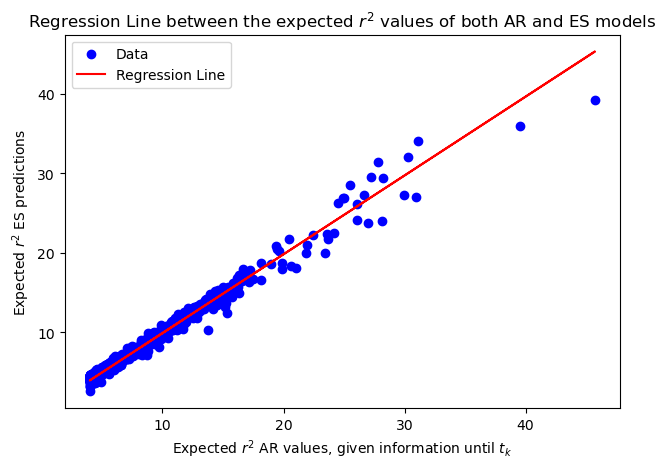

In [430]:
#Error with E[r^2|Fk]
arma_expected_test = arma_expected[-len(variances_sig):]

arma_squared = list()
for i in range(len(arma_expected_test)):
    arma_squared.append(arma_expected_test[i]**2 + 4)


# Fit a simple linear regression model
model = sm.OLS(variances_sig, arma_squared).fit()
print(model.summary())

# Calculate R^2 and adjusted R^2
r_squared = model.rsquared
adjusted_r_squared = model.rsquared_adj

# Create subplots
plt.scatter(arma_squared, variances_sig, color='blue', label='Data')
plt.plot(arma_squared, model.predict(arma_squared), color='red', label='Regression Line')
plt.xlabel('Expected $r^2$ AR values, given information until $t_k$')
plt.ylabel('Expected $r^2$ ES predictions')
plt.legend()
plt.title("Regression Line between the expected $r^2$ values of both AR and ES models")

plt.tight_layout()
plt.show()

**Comprovar que la esperança dels residus es 0 i es normal, etc!!**

R^2: 0.9998180358574801
Adjusted R^2: 0.9998178081176271
                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   1.000
Model:                            OLS   Adj. R-squared (uncentered):              1.000
Method:                 Least Squares   F-statistic:                          4.390e+06
Date:                Tue, 28 May 2024   Prob (F-statistic):                        0.00
Time:                        16:25:13   Log-Likelihood:                          2616.0
No. Observations:                 800   AIC:                                     -5230.
Df Residuals:                     799   BIC:                                     -5225.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.

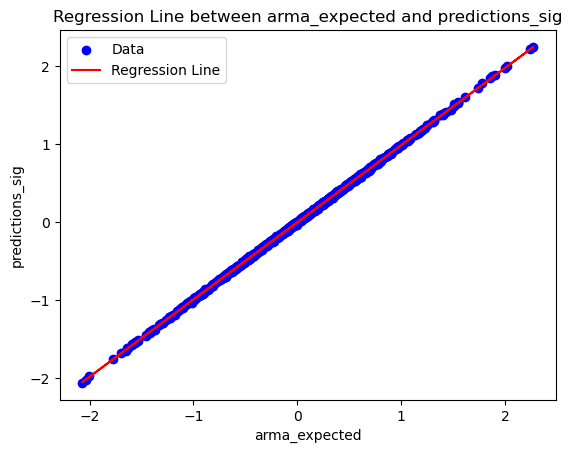

In [209]:
# Fit a simple linear regression model
model = sm.OLS(predictions_sig, arma_test).fit()

# Calculate R^2 and adjusted R^2
r_squared = model.rsquared
adjusted_r_squared = model.rsquared_adj

print("R^2:", r_squared)
print("Adjusted R^2:", adjusted_r_squared)

# Display the regression summary
print(model.summary())

# Scatter plot with regression line
plt.scatter(arma_test, predictions_sig, color='blue', label='Data')
plt.plot(arma_test, model.predict(arma_test), color='red', label='Regression Line')
plt.xlabel('arma_expected')
plt.ylabel('predictions_sig')
plt.legend()
plt.title("Regression Line between arma_expected and predictions_sig")
plt.show()

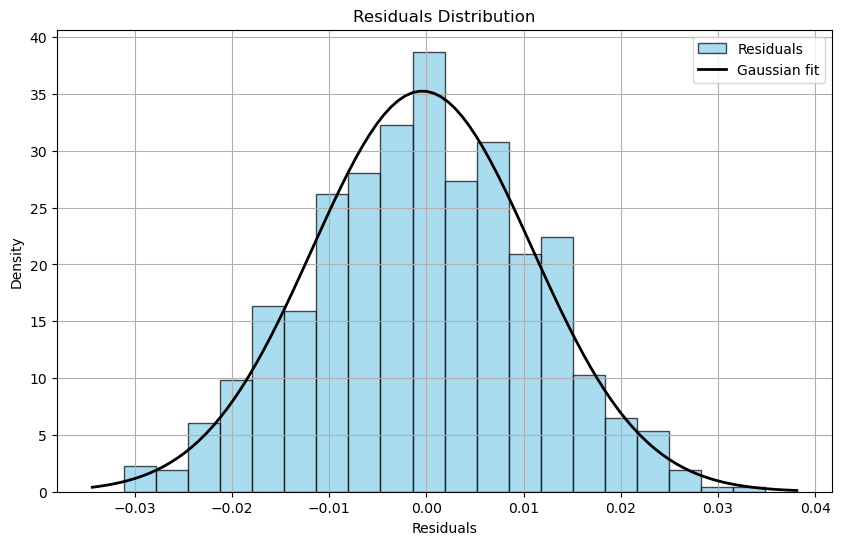

Confidence Interval for RMSE: [0.011, 0.012]
My mse:
0.0113230316221897


In [210]:
# Calculate residuals
residuals_sig = np.array(arma_test) - np.array(predictions_sig)


# Plot histogram of residuals
plt.figure(figsize=(10, 6))
plt.hist(residuals_sig, bins=20, density=True, color='skyblue', edgecolor='black', alpha=0.7, label='Residuals')

# Fit a normal distribution to the data
mu, std = norm.fit(residuals_sig)
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2, label='Gaussian fit')

plt.title('Residuals Distribution')
plt.xlabel('Residuals')
plt.ylabel('Density')
plt.legend()
plt.grid(True)
plt.show()

# Confidence Intervals for RMSE
alpha = 0.05  # Significance level
n = len(residuals_sig)
mse = mean_squared_error(arma_test, predictions_sig)
standard_error = np.sqrt(mse / n)

# Calculate t-value for the given significance level and degrees of freedom
t_value = tstats.ppf(1 - alpha / 2, df=n-1)

# Calculate confidence interval for RMSE
lower_bound = np.sqrt(mse) - t_value * standard_error
upper_bound = np.sqrt(mse) + t_value * standard_error

print(f'Confidence Interval for RMSE: [{lower_bound:.3f}, {upper_bound:.3f}]')
print("My mse:")
print(np.sqrt(mse))


**If the confidence interval does not include zero, it suggests that the RMSE estimate is statistically significant and different from zero at the 95% confidence level.
Conversely, if the confidence interval includes zero, it implies that the RMSE estimate is not statistically significant at the 95% confidence level, and the model performance may not be significantly different from random guessing.**

**In our case, maybe it will mean that we have some info missing
Comparison with Benchmarks: The confidence interval allows us to compare the model's performance against benchmarks or alternative models. 
If the upper bound of the confidence interval is smaller than the RMSE of a benchmark model, it suggests that our model performs better than the benchmark with a certain level of confidence.**

In [ ]:
#PREDICTION AVERAGE PRICE FOR FUTURES DATA

In [448]:
warnings.filterwarnings("ignore")
#Get the stock quote

# Download historical of bitcoin
BTC_price = yf.download("ZW=F", start = '2017-01-01', end = '2024-07-24')
print(BTC_price.head())
print(BTC_price.tail())

[*********************100%%**********************]  1 of 1 completed

              Open    High     Low   Close  Adj Close  Volume
Date                                                         
2017-01-03  408.75  414.00  405.75  406.50     406.50   65585
2017-01-04  406.50  419.00  404.75  418.50     418.50   59201
2017-01-05  418.75  427.00  416.25  426.25     426.25   86772
2017-01-06  425.75  428.00  421.75  423.25     423.25   64726
2017-01-09  424.75  428.25  421.00  427.25     427.25   69623
              Open    High     Low   Close  Adj Close  Volume
Date                                                         
2024-05-23  694.00  702.50  682.50  698.00     698.00   68180
2024-05-24  701.25  706.00  689.00  697.25     697.25   70621
2024-05-28  713.00  720.00  693.75  700.25     700.25   73681
2024-05-29  701.50  706.25  688.50  692.75     692.75   73681
2024-05-30  692.75  693.75  677.50  683.00     683.00   32974


In [449]:
#Helper function to extract a rolling window
#We need to specify both historical window and future window
#to make sure that our matrix is consistent
def GetWindow_2(x,h_window =30,f_window=10):

    # First window
    X = np.array(x.iloc[:h_window,]).reshape(1,-1)
   
    # Append next window
    for i in range(1,len(x)-h_window+1):
        x_i = np.array(x.iloc[i:i+h_window,]).reshape(1,-1)
        X = np.append(X,x_i, axis=0)
        
    # Cut the end that we can't use to predict future price
    rolling_window = (pd.DataFrame(X)).iloc[:-f_window,]
    return rolling_window

#input = panda, historical window, future window
def GetNextMean_2(x,h_window=30,f_window=10):
    return pd.DataFrame((x.rolling(f_window).mean().iloc[h_window+f_window-1:,]))

In [477]:
initial_date = '2016-02-01'
finish_date = '2022-08-15'
BTC_price_time = BTC_price[initial_date: finish_date]
BTC_price_time['Adj Close'].head(10)

Date
2017-01-03    406.50
2017-01-04    418.50
2017-01-05    426.25
2017-01-06    423.25
2017-01-09    427.25
2017-01-10    426.75
2017-01-11    418.75
2017-01-12    426.25
2017-01-13    426.00
2017-01-17    433.50
Name: Adj Close, dtype: float64

In [451]:
#Function add time to the data set
def AddTime(X):
    t = np.linspace(0,1,len(X))
    return np.c_[t, X]

In [452]:
#Function for Lead lag transform
def Lead(X):
    
    s = X.shape
    x_0 = X[:,0]
    Lead = np.delete(np.repeat(x_0,2),0).reshape(-1,1)
     
    for j in range(1,s[1]):
        x_j = X[:,j]
        x_j_lead = np.delete(np.repeat(x_j,2),0).reshape(-1,1)
        Lead = np.concatenate((Lead,x_j_lead), axis =1)
     
    return Lead

#Function for Lead lag transform
def Lag(X):
    s = X.shape
    x_0 = X[:,0]
    Lag = np.delete(np.repeat(x_0,2),-1).reshape(-1,1)
  
    for j in range(1,s[1]):
        x_j = X[:,j]
        x_j_lag  = np.delete(np.repeat(x_j,2),-1).reshape(-1,1)
        Lag = np.concatenate((Lag,x_j_lag), axis = 1)
        
    return Lag

In [461]:
# We use only close price
close_price = BTC_price_time.loc[:,'Adj Close']
h_window = 40
f_window = 5
sig_level = 2

# mean next price
y = GetNextMean_2(close_price, h_window = h_window , f_window = f_window)

# normal window features
X_window = AddTime(GetWindow_2(close_price, h_window = h_window, f_window = f_window))
X_window = pd.DataFrame(X_window)

# signature features
#Consider only area that has at least f_window future prices left
close_price_slice = close_price.iloc[0:(len(close_price)-(f_window))]
close_price_array = np.array(close_price_slice).reshape(-1,1)
lag = Lag(close_price_array)
lead = Lead(AddTime(close_price_array))
#concatenate everything to get a datastream
stream = np.concatenate((lead,lag), axis = 1)
X_sig = [ts.stream2sig(stream[0:2*h_window-1], sig_level)]

for i in range(1,(len(close_price)-(f_window)-(h_window)+1)):
    stream_i = stream[2*i: 2*(i+h_window)-1]
    signature_i = [ts.stream2sig(stream_i, sig_level)]
    X_sig = np.append(X_sig, signature_i, axis=0)

X_sig = pd.DataFrame(X_sig)

In [462]:
# Split X,y into train and test region
test_len = 120
train_len = len(y) - test_len

X_train = X_sig.iloc[:train_len,]
y_train = y.iloc[:train_len,]
X_test = X_sig.iloc[train_len:,]
y_test = y.iloc[train_len:,]

In [463]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_absolute_error

# Mean absolute percentage error
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Normalize the data using StandardScaler
#scaler = StandardScaler()
#X_train_scaled = scaler.fit_transform(X_train)
#X_test_scaled = scaler.transform(X_test)
X_train_scaled = X_train
X_test_scaled = X_test

# Perform GridsearchCV
param_search = {'alpha': [1e-5, 1e-2, 1e-1, 2e-1, 5e-1, 1]}
myModel = GridSearchCV(estimator=Lasso(max_iter=99999),
                       param_grid=param_search,
                       cv=TimeSeriesSplit(n_splits=5),
                       n_jobs=-1)

myModel.fit(X_train_scaled, y_train)

# Make predictions
y_train_predict = myModel.predict(X_train_scaled)
y_test_predict = myModel.predict(X_test_scaled)

# Calculate error
error_train = mean_absolute_error(y_train, y_train_predict)        
error_test = mean_absolute_error(y_test, y_test_predict)
p_error_train = mean_absolute_percentage_error(np.array(y_train).reshape(-1,1), np.array(y_train_predict).reshape(-1,1))
p_error_test = mean_absolute_percentage_error(np.array(y_test).reshape(-1,1), np.array(y_test_predict).reshape(-1,1))

print('mae_train: {:.3f} = {:.3f}%\n'.format(error_train, p_error_train))
print('mae_test: {:.3f} = {:.3f}%'.format(error_test, p_error_test))

/Users/oscarromero/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.367e+01, tolerance: 9.452e-01
  model = cd_fast.enet_coordinate_descent(
/Users/oscarromero/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.056e+03, tolerance: 4.030e+00
  model = cd_fast.enet_coordinate_descent(
/Users/oscarromero/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing reg

mae_train: 28.146 = 4.967%

mae_test: 44.678 = 6.675%


In [535]:
# Plot to visualise
import matplotlib.pyplot as plt

def PlotResult(y_train, y_test, y_train_predict, y_test_predict, test_len, name):
        
        #Visualise
        plt.figure(figsize=(12, 5))
        plt.plot(y_train_predict,color='red')
        
        plt.plot(range(train_len, train_len+len(y_test)),
                 y_test_predict,
                 label='Predicted average price',
                 color='red',linestyle = '--')
        
        plt.plot(np.concatenate([y_train, y_test]),
                 label='Actual average price',
                 color='green')
        
        plt.axvspan(len(y_train), len(y_train)+len(y_test),
                    alpha=0.3, color='lightgrey')
        
        plt.grid(True)
        plt.axis('tight')
        plt.legend(loc="best")
        plt.title('Predicting the mean BTC price with {}'.format(name))

120
120


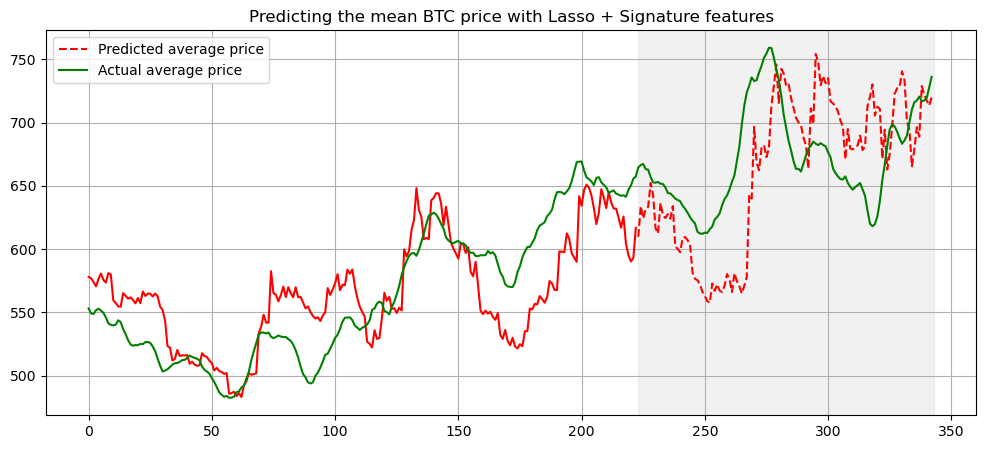

In [536]:
print(len(y_test_predict))
print(len(y_test))
PlotResult(np.array(y_train).reshape(-1,1), np.array(y_test).reshape(-1,1), np.array(y_train_predict).reshape(-1,1), np.array(y_test_predict).reshape(-1,1), np.array(test_len).reshape(-1,1), 'Lasso + Signature features')


**ARIMA vs ES**

In [1]:
from IPython.display import display

import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 15)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

import matplotlib.pyplot as plt
from datetime import datetime
from datetime import timedelta
from pandas.plotting import register_matplotlib_converters

register_matplotlib_converters()

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from time import time
import seaborn as sns
sns.set(style="whitegrid")

import warnings
warnings.filterwarnings('ignore')

RANDOM_SEED = np.random.seed(0)

/Users/oscarromero/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [52]:
def parser(s):
    return datetime.strptime(s, '%Y-%m-%d')
#read data
catfish_sales = pd.read_csv('./catfish.csv.xls', parse_dates=[0], index_col=0, date_parser=parser)
#infer the frequency of the data
catfish_sales = catfish_sales.asfreq(pd.infer_freq(catfish_sales.index))

#transform
start_date = datetime(1992,1,1)
end_date = datetime(2012,1,1)
lim_catfish_sales = catfish_sales[start_date:end_date]

In [100]:
from pmdarima.arima import auto_arima

# Assuming your time series data is stored in 'ts_data'
# Fit auto_arima
model = auto_arima(lim_catfish_sales, seasonal=True, m=12)

# Summarize the best model
print(model.summary())

                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  241
Model:             SARIMAX(0, 1, 0)x(1, 0, [1], 12)   Log Likelihood               -2035.298
Date:                              Sun, 02 Jun 2024   AIC                           4076.597
Time:                                      14:34:54   BIC                           4087.039
Sample:                                  01-01-1992   HQIC                          4080.804
                                       - 01-01-2012                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12       0.9896      0.008    122.130      0.000       0.974       1.005
ma.S.L12      -0.87

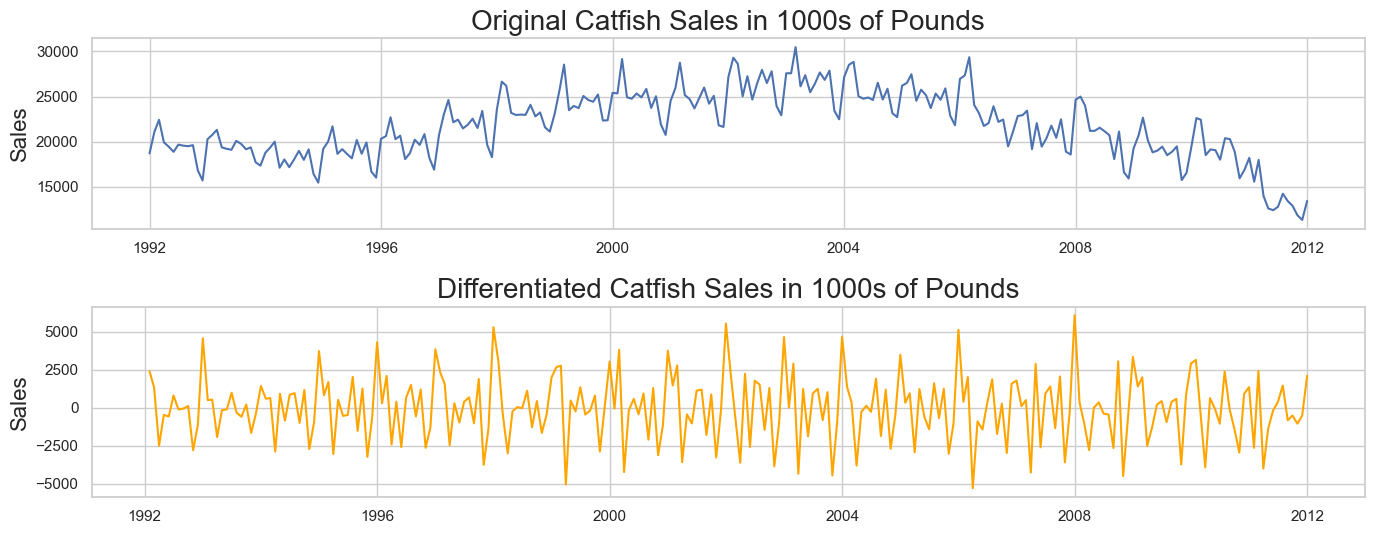

In [97]:
# Compute the stationary time series by differentiating (removes trends and seasonality)
diff_lim_catfish_sales = lim_catfish_sales.diff().dropna()

# Integrate the differenced series to retrieve the initial time series
integrated_lim_catfish_sales = diff_lim_catfish_sales.cumsum() + lim_catfish_sales.iloc[0]
# Plot the original, differenced, and integrated time series
plt.figure(figsize=(14, 8))

# Original time series
plt.subplot(3, 1, 1)
plt.plot(lim_catfish_sales, label='Original')
plt.title('Original Catfish Sales in 1000s of Pounds', fontsize=20)
plt.ylabel('Sales', fontsize=16)

# Differenced time series
plt.subplot(3, 1, 2)
plt.plot(diff_lim_catfish_sales, label='Differenced', color='orange')
plt.title('Differentiated Catfish Sales in 1000s of Pounds', fontsize=20)
plt.ylabel('Sales', fontsize=16)


plt.tight_layout()
plt.show()


SLT decomposition, to see trend

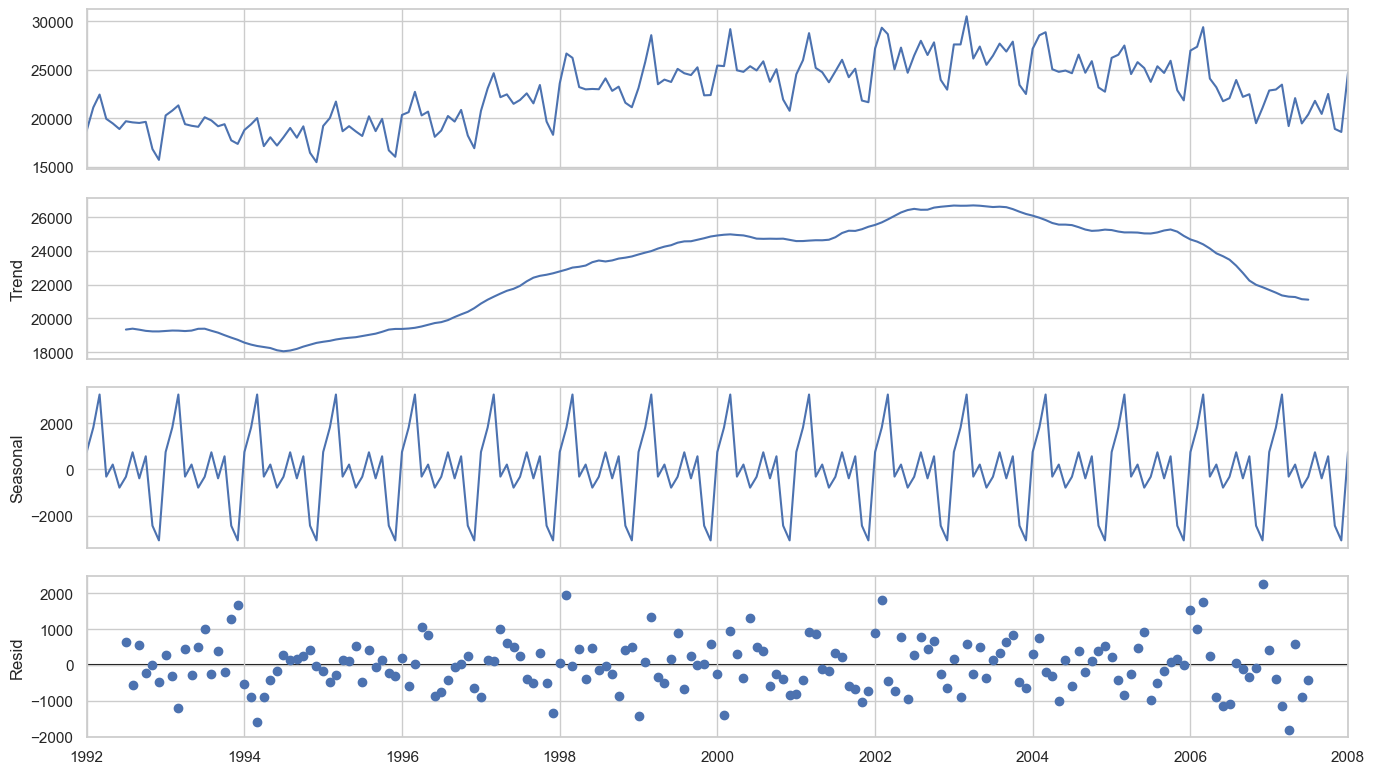

In [4]:
plt.rc('figure',figsize=(14,8))
plt.rc('font',size=15)

result = seasonal_decompose(lim_catfish_sales,model='additive')
fig = result.plot()

Points to ponder:

A 6-month and 12-month seasonal pattern is visible
An upwards and downwards trend is evident

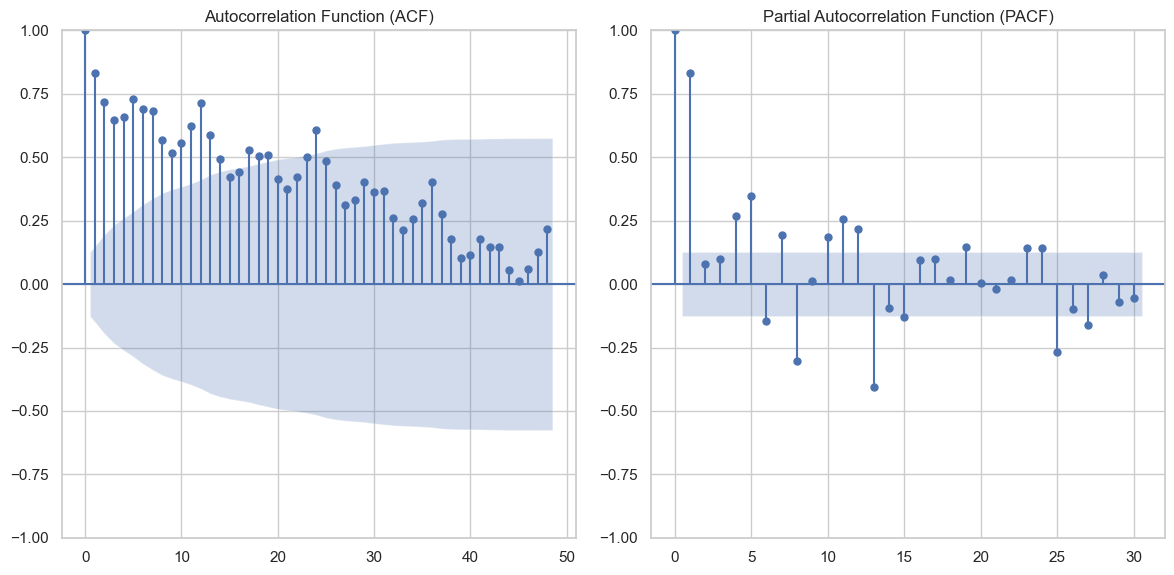

In [99]:
# Plot ACF and PACF
# Create a figure with two subplots in the same row
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot ACF on the first subplot
plot_acf(lim_catfish_sales['Total'], lags=48, ax=ax1)
ax1.set_title('Autocorrelation Function (ACF)')

# Plot PACF on the second subplot
plot_pacf(lim_catfish_sales['Total'], lags=30, ax=ax2)
ax2.set_title('Partial Autocorrelation Function (PACF)')

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

Points to ponder:

There’s a significant spike at 6-month and 12-month in ACF
PACF is nearly sinusoidal
The differencing factor d should be kept at 1 since there’s a clear trend and non-stationary data. P can be tested with values 6 and 12. 

Now we predict using SARIMA, SARIMA stands for Seasonal-ARIMA and it includes seasonality contribution to the forecast. The importance of seasonality is quite evident and ARIMA fails to encapsulate that information implicitly. It will be used the non-differentiated time series, as SARIMA model differentiate data.
Similar to ARMA, the P,D,Q values for seasonal parts of the model can be deduced from the ACF and PACF plots of the data. Let’s implement SARIMA for the same Catfish sales model.

In [18]:
sarima = SARIMAX(lim_catfish_sales['Total'],
                order=(1,1,1),
                seasonal_order=(1,1,0,12))
predictions = sarima.fit().predict()

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.93328D+00    |proj g|=  1.46478D-01

At iterate    5    f=  7.89033D+00    |proj g|=  5.14458D-02

At iterate   10    f=  7.87576D+00    |proj g|=  2.56170D-03

At iterate   15    f=  7.87575D+00    |proj g|=  6.20452D-04

At iterate   20    f=  7.87565D+00    |proj g|=  9.15218D-03

At iterate   25    f=  7.87106D+00    |proj g|=  3.19794D-02

At iterate   30    f=  7.87010D+00    |proj g|=  7.99352D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

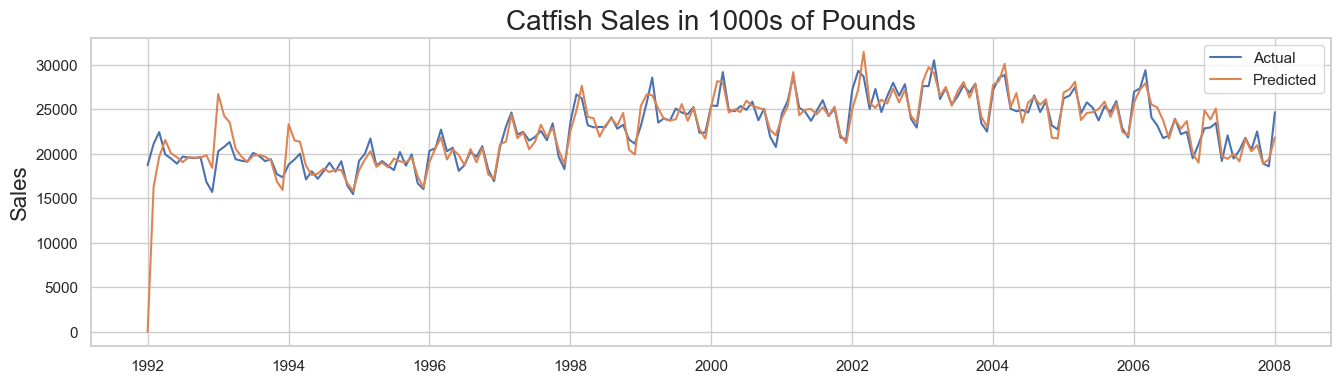

In [19]:
plt.figure(figsize=(16,4))
plt.plot(lim_catfish_sales, label="Actual")
plt.plot(predictions, label="Predicted")
plt.title('Catfish Sales in 1000s of Pounds', fontsize=20)
plt.ylabel('Sales', fontsize=16)
plt.legend()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.44712D+00    |proj g|=  2.89198D-01

At iterate    5    f=  8.38083D+00    |proj g|=  2.78604D-02

At iterate   10    f=  8.37691D+00    |proj g|=  4.57672D-04

At iterate   15    f=  8.37690D+00    |proj g|=  1.08511D-03

At iterate   20    f=  8.37364D+00    |proj g|=  1.72069D-02


 This problem is unconstrained.



At iterate   25    f=  8.36444D+00    |proj g|=  1.89431D-03

At iterate   30    f=  8.36183D+00    |proj g|=  1.93319D-03

At iterate   35    f=  8.36165D+00    |proj g|=  5.49409D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     35     47      1     0     0   5.494D-06   8.362D+00
  F =   8.3616527067935564     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Test MSE on original scale: 2598333.926
Test MSE on differentiated series: 4964241.002


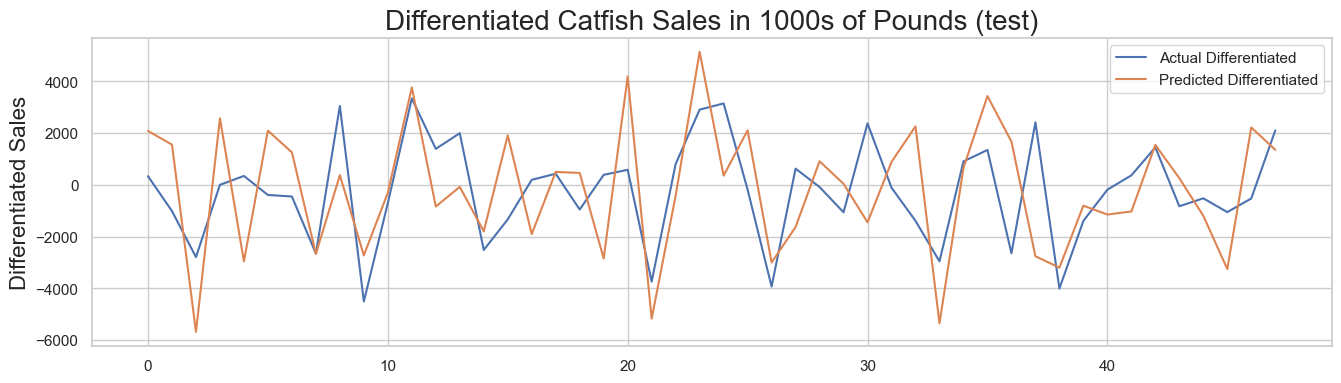

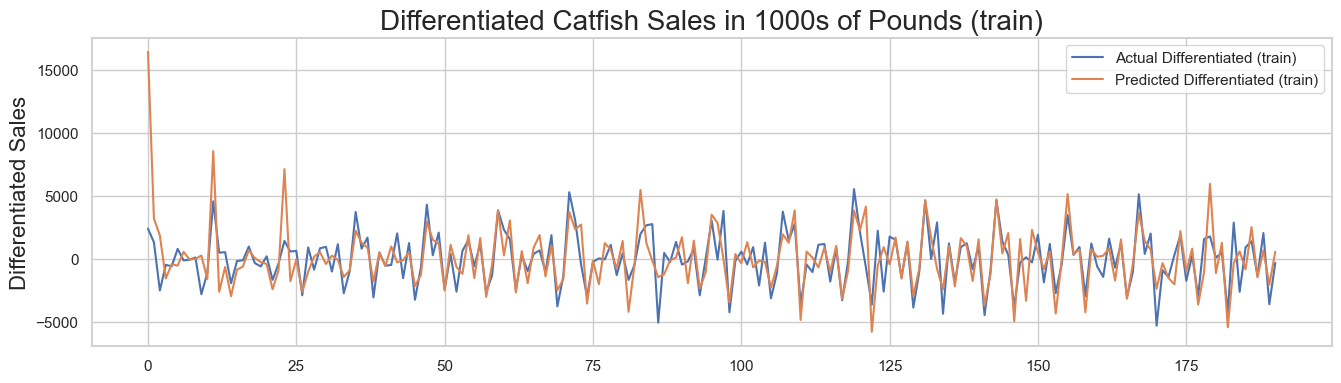

In [101]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error

# Assuming lim_catfish_sales is your DataFrame with the time series data
# Splitting the data into training (80%) and testing (20%) sets
train_size = int(len(lim_catfish_sales) * 0.8)
train_data, test_data = lim_catfish_sales.iloc[:train_size], lim_catfish_sales.iloc[train_size:]

# Fit SARIMA model on the training data
sarima = SARIMAX(train_data['Total'], order=(0, 1, 0), seasonal_order=(1, 0, 1, 12))
sarima_fit = sarima.fit()

# Predicting using one-step ahead forecast to avoid data leakage
predictions = []
history = list(train_data['Total'])

for t in range(len(test_data)):
    model = SARIMAX(history, order=(1, 1, 1), seasonal_order=(1, 1, 0, 12))
    model_fit = model.fit(disp=False)
    if t == 0:
        initial_predictions = model_fit.predict()
    output = model_fit.forecast(steps=1)
    yhat = output[0]
    predictions.append(yhat)
    history.append(test_data['Total'].iloc[t])

# Calculate the performance on the original scale
test_values = test_data['Total'].values
mse = mean_squared_error(test_values, predictions)
print(f'Test MSE on original scale: {mse:.3f}')

# Differentiating the actual and predicted values
diff_test_values = np.diff(test_values, n=1)
diff_predictions = np.diff(predictions, n=1)

# Calculate the MSE of the differentiated series
diff_mse = mean_squared_error(diff_test_values, diff_predictions)
print(f'Test MSE on differentiated series: {diff_mse:.3f}')

# Plotting the differentiated results
plt.figure(figsize=(16, 4))
plt.plot(diff_test_values, label="Actual Differentiated")
plt.plot(diff_predictions, label="Predicted Differentiated")
plt.title('Differentiated Catfish Sales in 1000s of Pounds (test)', fontsize=20)
plt.ylabel('Differentiated Sales', fontsize=16)
plt.legend()
plt.show()



# Plotting the differentiated results for the train data and predictions
train_values = train_data['Total'].values
diff_train_values = np.diff(train_values, n=1)
diff_train_predictions = np.diff(initial_predictions, n=1)

plt.figure(figsize=(16, 4))
plt.plot(diff_train_values, label="Actual Differentiated (train)")
plt.plot(diff_train_predictions, label="Predicted Differentiated (train)")
plt.title('Differentiated Catfish Sales in 1000s of Pounds (train)', fontsize=20)
plt.ylabel('Differentiated Sales', fontsize=16)
plt.legend()
plt.show()



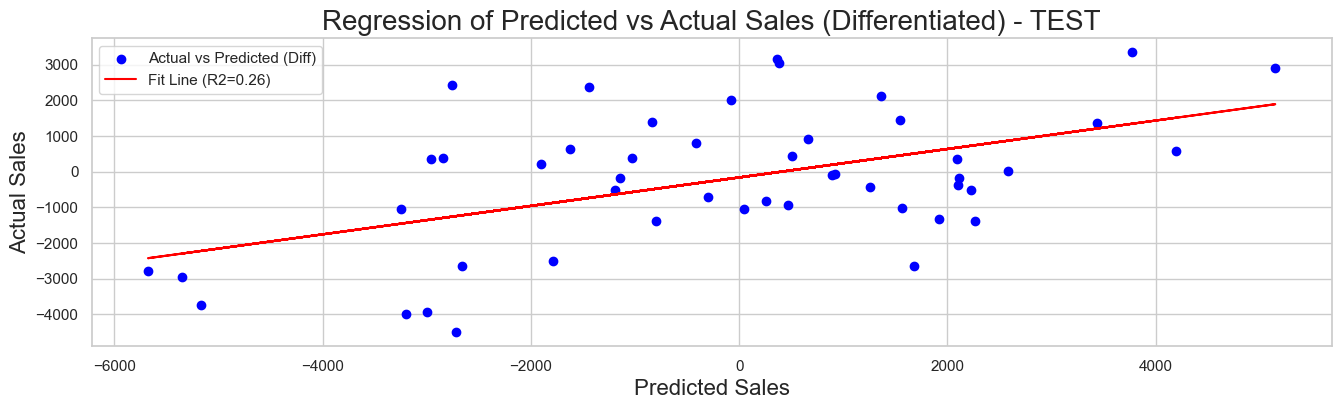

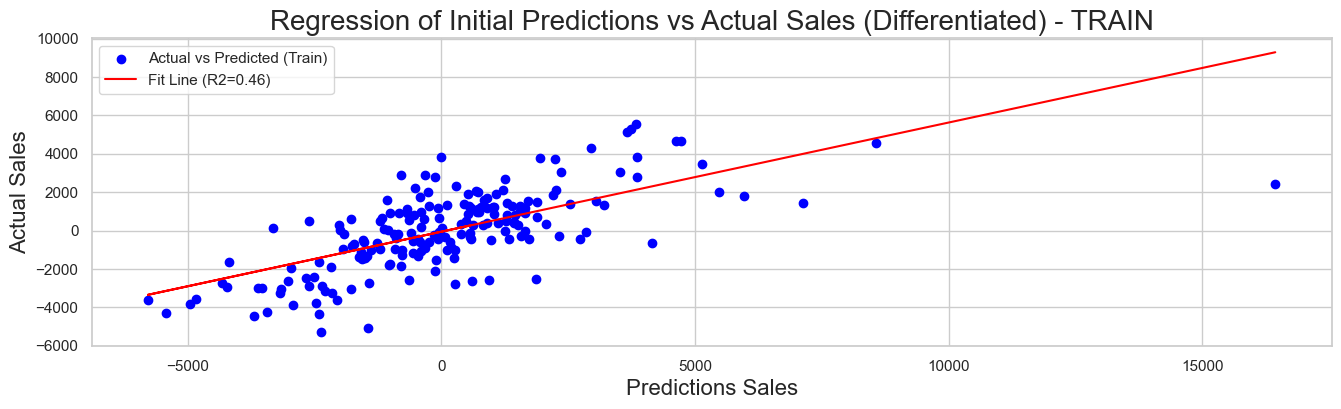

In [103]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

#Regression for test predictions vs test data
# Prepare data for regression analysis
diff_actual_vs_predicted = pd.DataFrame({'Actual': diff_test_values, 'Predicted': diff_predictions})


# Perform linear regression on differentiated values
reg_diff = LinearRegression().fit(diff_actual_vs_predicted[['Predicted']], diff_actual_vs_predicted['Actual'])
predicted_fit_diff = reg_diff.predict(diff_actual_vs_predicted[['Predicted']])
r2_diff = r2_score(diff_actual_vs_predicted['Actual'], predicted_fit_diff)

# Plot differentiated regression
plt.figure(figsize=(16, 4))
plt.scatter(diff_actual_vs_predicted['Predicted'], diff_actual_vs_predicted['Actual'], label="Actual vs Predicted (Diff)", color='blue')
plt.plot(diff_actual_vs_predicted['Predicted'], predicted_fit_diff, label=f"Fit Line (R2={r2_diff:.2f})", color='red')
plt.title('Regression of Predicted vs Actual Sales (Differentiated) - TEST', fontsize=20)
plt.xlabel('Predicted Sales', fontsize=16)
plt.ylabel('Actual Sales', fontsize=16)
plt.legend()
plt.show()

#Regression of train data vs predicted data in training
# Prepare data for regression analysis
predicted_vs_actual_train = pd.DataFrame({'Actual': diff_train_values, 'Predicted': diff_train_predictions})


# Perform linear regression
reg_initial = LinearRegression().fit(predicted_vs_actual_train[['Predicted']], predicted_vs_actual_train['Actual'])
predicted_fit_train = reg_initial.predict(predicted_vs_actual_train[['Predicted']])
r2_initial = r2_score(predicted_vs_actual_train['Actual'], predicted_fit_train)

# Plot regression
plt.figure(figsize=(16, 4))
plt.scatter(initial_vs_actual_train['Predicted'], initial_vs_actual_train['Actual'], label="Actual vs Predicted (Train)", color='blue')
plt.plot(initial_vs_actual_train['Predicted'], predicted_fit_initial, label=f"Fit Line (R2={r2_initial:.2f})", color='red')
plt.title('Regression of Initial Predictions vs Actual Sales (Differentiated) - TRAIN', fontsize=20)
plt.xlabel('Predictions Sales', fontsize=16)
plt.ylabel('Actual Sales', fontsize=16)
plt.legend()
plt.show()


Expected Signature MODEL IMPLEMENTATION

In [ ]:
print(len(sales))

VEURE LES PREDICCIONS DEL TRAINING

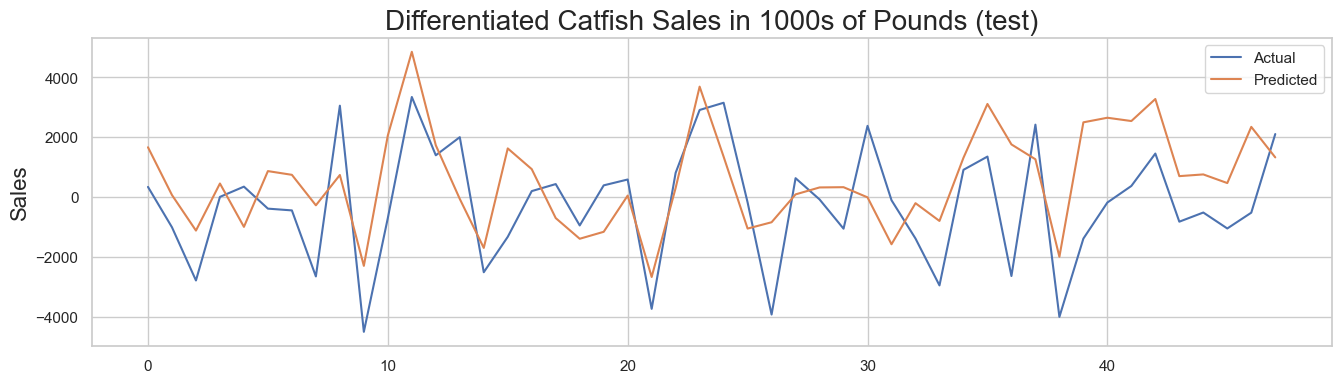

Test MSE: 3354456.66408184


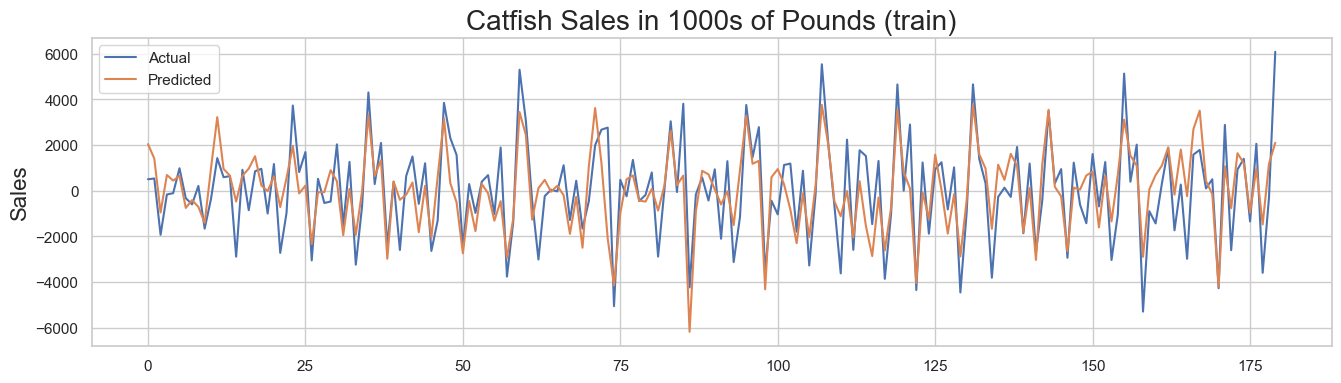

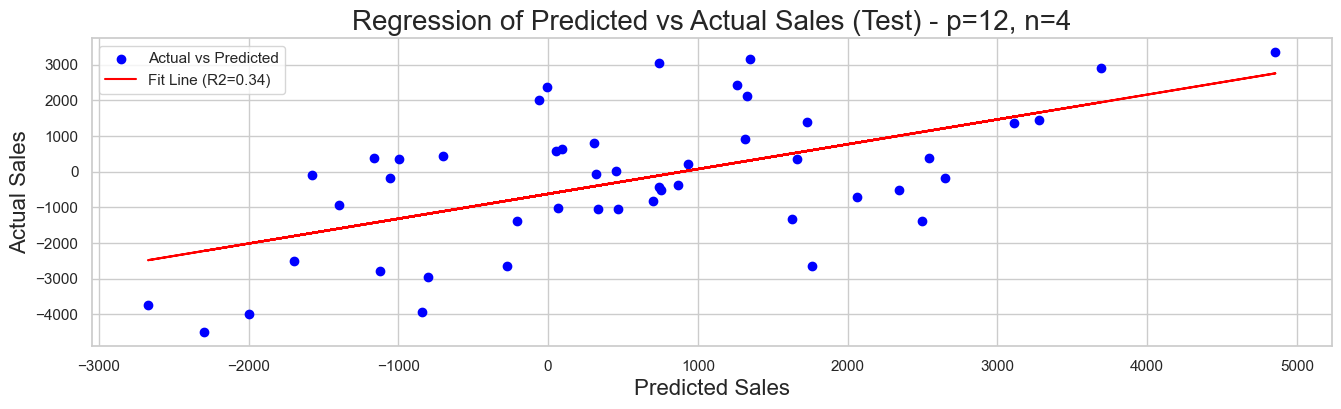

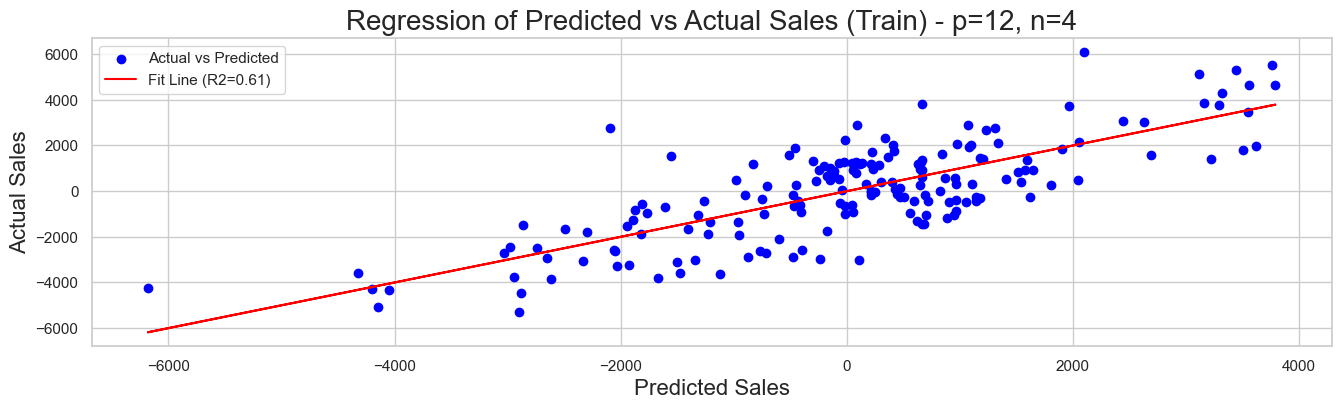

In [92]:
p_values = [12]
n_values = [4]

#We make use of the differentiated data in order to mantain stationarity
sales = diff_lim_catfish_sales.values.reshape(-1)
sales = sales.astype(float)


for p in p_values:
    for n in n_values:
        # We use the arma_series for the past and expected value for the future in order to train, then test with expected arma_series
        predictions_sig, variances_sig, train_pred_sig, y_train_sig = predictions_signature(sales, sales, int(len(sales) * 0.8), p, n, 2)
        
        sales_test = sales[-len(predictions_sig):]

        # Plot the differentiated predictions
        plt.figure(figsize=(16, 4))
        plt.plot(sales_test, label="Actual")
        plt.plot(predictions_sig, label="Predicted")
        plt.title('Differentiated Catfish Sales in 1000s of Pounds (test)', fontsize=20)
        plt.ylabel('Sales', fontsize=16)
        plt.legend()
        plt.show()

        # Calculate MSE
        mse2 = np.mean((sales_test - predictions_sig) ** 2)
        print('Test MSE: %.8f' % mse2)
        
        train_pred = [pred[2] for pred in train_pred_sig]
        y_train_real = [pred[2] for pred in y_train_sig]
        
        # Plot the train data predictions
        plt.figure(figsize=(16, 4))
        plt.plot(y_train_real, label="Actual")
        plt.plot(train_pred, label="Predicted")
        plt.title('Catfish Sales in 1000s of Pounds (train)', fontsize=20)
        plt.ylabel('Sales', fontsize=16)
        plt.legend()
        plt.show()
        
        # Regression analysis on test data
        diff_actual_vs_predicted = pd.DataFrame({'Actual': sales_test, 'Predicted': predictions_sig})
        reg = LinearRegression().fit(diff_actual_vs_predicted[['Predicted']], diff_actual_vs_predicted['Actual'])
        predicted_fit = reg.predict(diff_actual_vs_predicted[['Predicted']])
        r2 = r2_score(diff_actual_vs_predicted['Actual'], predicted_fit)

        # Plot regression
        plt.figure(figsize=(16, 4))
        plt.scatter(diff_actual_vs_predicted['Predicted'], diff_actual_vs_predicted['Actual'], label="Actual vs Predicted", color='blue')
        plt.plot(diff_actual_vs_predicted['Predicted'], predicted_fit, label=f"Fit Line (R2={r2:.2f})", color='red')
        plt.title(f'Regression of Predicted vs Actual Sales (Test) - p={p}, n={n}', fontsize=20)
        plt.xlabel('Predicted Sales', fontsize=16)
        plt.ylabel('Actual Sales', fontsize=16)
        plt.legend()
        plt.show()

        # Regression analysis on train data
        train_actual_vs_predicted = pd.DataFrame({'Actual': y_train_real, 'Predicted': train_pred})
        reg_train = LinearRegression().fit(train_actual_vs_predicted[['Predicted']], train_actual_vs_predicted['Actual'])
        predicted_fit_train = reg_train.predict(train_actual_vs_predicted[['Predicted']])
        r2_train = r2_score(train_actual_vs_predicted['Actual'], predicted_fit_train)

        # Plot regression for train data
        plt.figure(figsize=(16, 4))
        plt.scatter(train_actual_vs_predicted['Predicted'], train_actual_vs_predicted['Actual'], label="Actual vs Predicted", color='blue')
        plt.plot(train_actual_vs_predicted['Predicted'], predicted_fit_train, label=f"Fit Line (R2={r2_train:.2f})", color='red')
        plt.title(f'Regression of Predicted vs Actual Sales (Train) - p={p}, n={n}', fontsize=20)
        plt.xlabel('Predicted Sales', fontsize=16)
        plt.ylabel('Actual Sales', fontsize=16)
        plt.legend()
        plt.show()

In [643]:
COMENTAR LA QUE ES MILLOR DE LES DE DALT, ENSENYAR QUE ALGUNES FAN OVERFIT I PROVAR AMB UN DATASET MES GRAN ETC
REENTRENAR LA SIGNATURA PER CADA ITERACIÓ?

SyntaxError: invalid syntax (3955253031.py, line 1)

In [ ]:
#CODI PRACTICA 10 ASSIGNATURA TIME SERIES

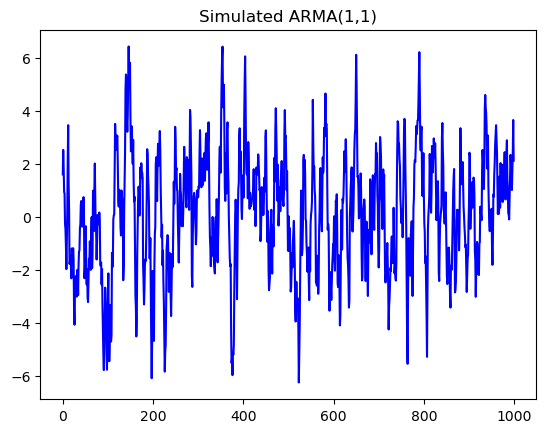

In [32]:
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.forecasting.stl import STLForecast
import statsmodels.api as sm
from pmdarima import auto_arima

# Step 1: Choose p and q and simulate an ARMA (p,q) model
n = 1000  # Number of observations
# Simulate ARMA(1,1) with AR=0.8 and MA=0.3
ar_params = [0.8]
ma_params = [0.3]
ar = np.r_[1, -np.array(ar_params)]  # Append 1 for AR
ma = np.r_[1, np.array(ma_params)]  # Append 1 for MA

arma_process = ArmaProcess(ar, ma)
x = arma_process.generate_sample(nsample=n)

plt.plot(x, 'b-', label='ARMA(1,1) simulation')
plt.title('Simulated ARMA(1,1)')
plt.show()


In [227]:
# Step 2: Use auto_arima to find the best ARIMA model
auto_model = auto_arima(x, max_p=2, max_d=1, max_q=2, seasonal=False, trace=True)
print(auto_model.summary())

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=2859.286, Time=0.43 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=4526.198, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=2926.842, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=3580.384, Time=0.05 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=2859.420, Time=0.08 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=2858.086, Time=0.11 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=2861.878, Time=0.06 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=2875.206, Time=0.06 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=2848.024, Time=0.24 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=2850.222, Time=0.12 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=2862.789, Time=0.15 sec
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=2848.659, Time=0.46 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=2919.876, Time=0.11 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=2849.324, Time=0.26 sec

Best model:  ARIMA(2,0,1)(0,0,0)

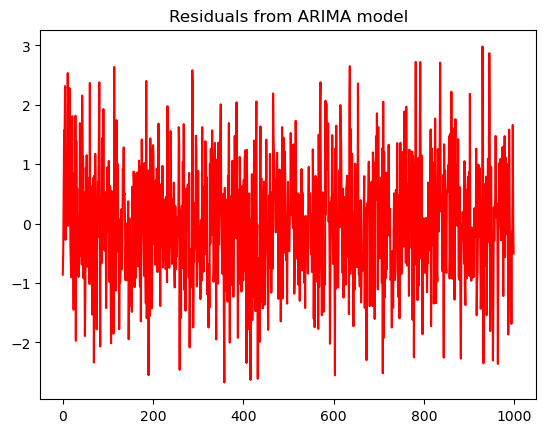

In [228]:
# Step 3: Check the residuals and their IID property
residuals = auto_model.resid()
plt.plot(residuals, 'r-', label='Residuals')
plt.title('Residuals from ARIMA model')
plt.show()

In [229]:
# Test residuals for white noise using Ljung-Box test
h = int(np.log(n))
lb_test = acorr_ljungbox(residuals, lags=[h], return_df=True)
print("Ljung-Box Test:", lb_test)

Ljung-Box Test:     lb_stat  lb_pvalue
6  1.264512   0.973578


**Considering this values**, we can see that the difference is given by random noise, so the approximation is good. 

**NOW, WE WANT TO FIT IT TO REAL FINANCIAL DATA -- APPL STOCK CLOSE PRICE**

[*********************100%%**********************]  1 of 1 completed


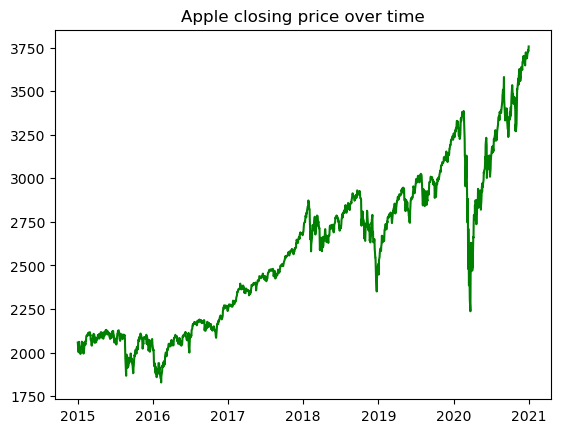

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=10742.782, Time=1.86 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=10746.855, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=10748.177, Time=0.11 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=10748.098, Time=0.22 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=10746.515, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=10744.063, Time=1.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=10744.195, Time=0.78 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=10742.371, Time=2.71 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=10745.948, Time=1.26 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=10740.367, Time=2.35 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=10745.731, Time=1.41 sec
 ARIMA(5,1,2)(0,0,0)[0] intercept   : AIC=10746.272, Time=2.52 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=10742.031, Time=4.14 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=10746.405, Time=3.11 sec
 ARIMA(5,1,1)(0,0,0

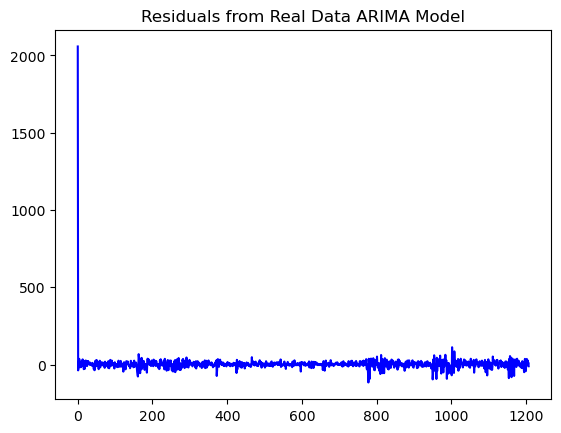

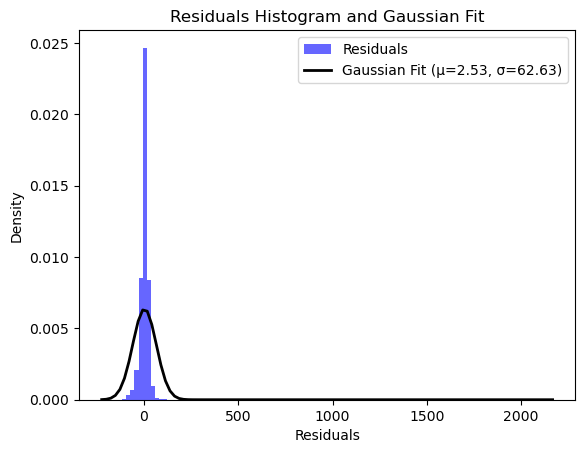

Ljung-Box Test (Real Data):     lb_stat  lb_pvalue
7  0.948388   0.995619


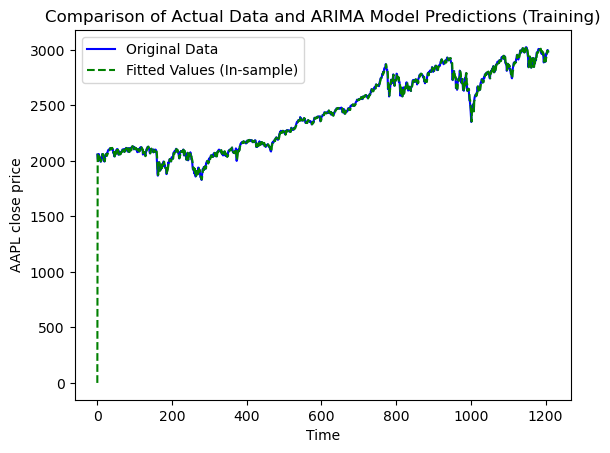

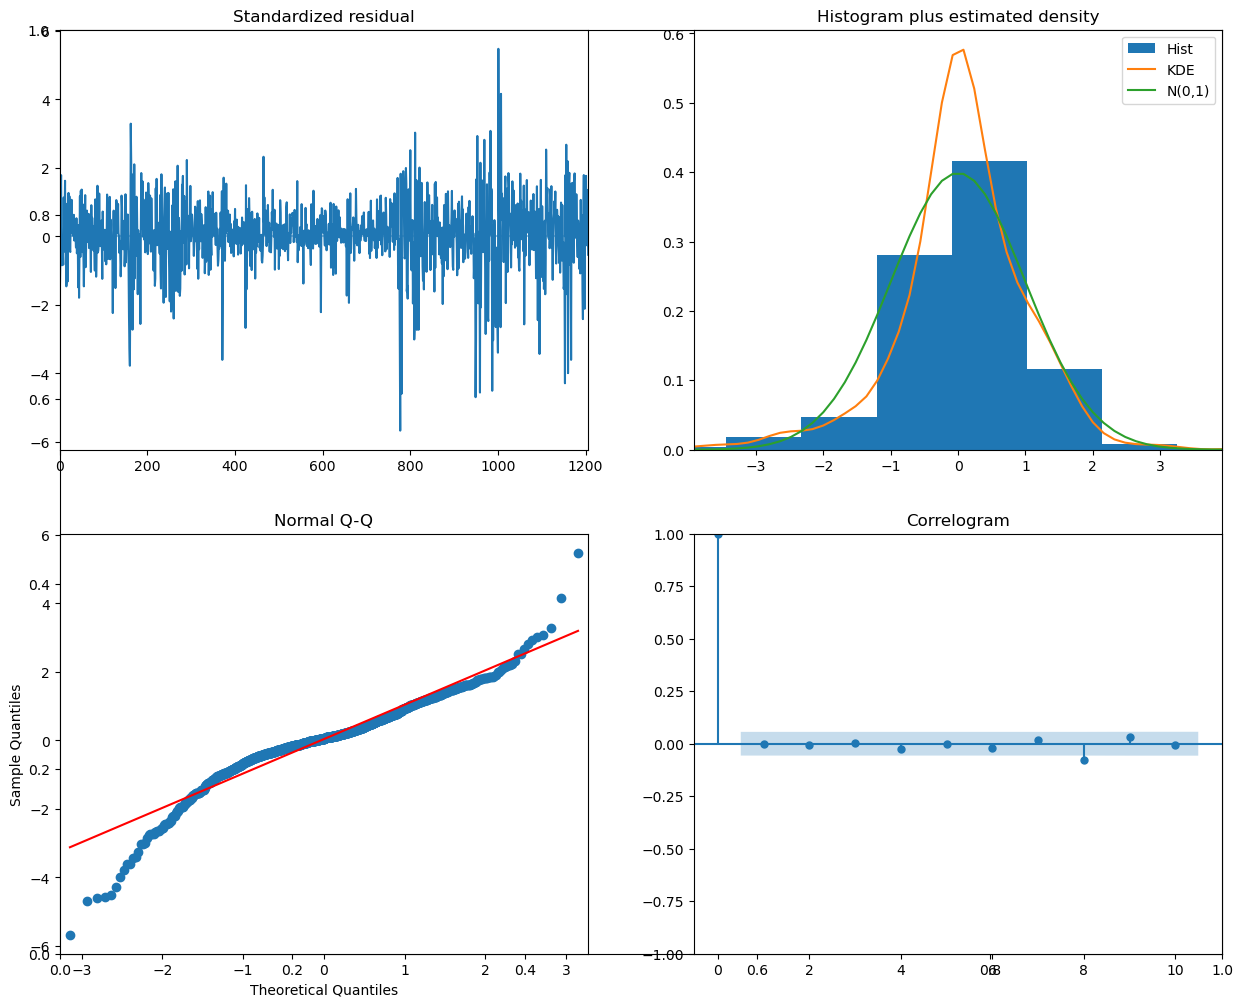

In [314]:
# Step 5: Fit a model to real data
# Let's use one of the available datasets from `statsmodels`
# Download data
data = yf.download("^GSPC", start="2015-01-01", end="2021-01-01")["Close"]
plt.plot(data, 'g-', label='AAPL close price')
plt.title('Apple closing price over time')
plt.show()

# Split data into train and test sets
X = data.values
train_size = int(len(X) * 0.8)
train, test = X[0:train_size], X[train_size:len(X)]

# Find the best ARIMA model for real data (train)
auto_model_real = auto_arima(train, seasonal=False, trace=True)
print(auto_model_real.summary())

# Residuals for real data
residuals = auto_model_real.resid()
plt.plot(residuals, 'b-', label='Residuals')
plt.title('Residuals from Real Data ARIMA Model')
plt.show()

# Plot the histogram of residuals
plt.hist(residuals, bins=100, density=True, alpha=0.6, color='b', label='Residuals')

# Fit a Gaussian distribution to the residuals
mu, std = norm.fit(residuals)  # Mean and standard deviation of the fitted Gaussian

# Generate points for the Gaussian distribution
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)  # Gaussian probability density function

# Plot the Gaussian distribution
plt.plot(x, p, 'k', linewidth=2, label=f'Gaussian Fit (μ={mu:.2f}, σ={std:.2f})')

# Add plot details
plt.title('Residuals Histogram and Gaussian Fit')
plt.xlabel('Residuals')
plt.ylabel('Density')
plt.legend()
plt.show()
plt.show()

# Test residuals for white noise using Ljung-Box test
h = int(np.log(len(train)))
lb_test_real = acorr_ljungbox(residuals, lags=[h], return_df=True)
print("Ljung-Box Test (Real Data):", lb_test_real)


# Generate predictions for the range of the data
fitted_values = auto_model_real.predict_in_sample()  # Fitted values within the sample range

# Plot the actual data
plt.plot(train, 'b-', label='Original Data')

# Plot the fitted values (predictions from the model)
plt.plot(fitted_values, 'g--', label='Fitted Values (In-sample)')

# Add plot details
plt.title('Comparison of Actual Data and ARIMA Model Predictions (Training)')
plt.xlabel('Time')
plt.ylabel('AAPL close price')
plt.legend()
plt.show()

#We plot diagnosis
fig, ax = plt.subplots(figsize=(15, 12))
auto_model_real.plot_diagnostics(fig=fig);

Now that we know the arima parameters that best fit data, we try to predict future values

In [315]:
# Define the ARIMA forecast with order (0,2,3), as seen in previous fitting
def arima_forecast(history):
    # Fit the model
    model = ARIMA(history, order=(4,1,2))
    model_fit = model.fit()
    
    # Make the prediction
    output = model_fit.forecast()
    yhat = output[0]
    return yhat


# Walk-forward validation
start_time = datetime.now()  # Start timing
history = [x for x in train]
predictions = list()
for t in range(len(test)):
    # Generate a prediction
    yhat = arima_forecast(history)
    predictions.append(yhat)
    # Add the real value to the training set
    obs = test[t]
    history.append(obs)
end_time = datetime.now()    # End timing
execution_time = end_time - start_time  # Calculate the duration
print(f"Execution time: {execution_time.total_seconds():.5f} seconds") #Varies a lot depending on the arima estimated

/Users/oscarromero/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/oscarromero/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/oscarromero/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/oscarromero/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/User

/Users/oscarromero/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/oscarromero/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/oscarromero/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/oscarromero/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/oscarromero/anaconda3/lib/python3

/Users/oscarromero/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/oscarromero/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/oscarromero/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/oscarromero/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/oscarromero/anaconda3/lib/python3

/Users/oscarromero/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/oscarromero/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/oscarromero/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/oscarromero/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/oscarromero/anaconda3/lib/python3

/Users/oscarromero/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/oscarromero/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/oscarromero/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/oscarromero/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/oscarromero/anaconda3/lib/python3

/Users/oscarromero/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/oscarromero/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/oscarromero/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/oscarromero/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/oscarromero/anaconda3/lib/python3

/Users/oscarromero/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/oscarromero/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/oscarromero/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/oscarromero/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/oscarromero/anaconda3/lib/python3

/Users/oscarromero/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/oscarromero/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Execution time: 365.25192 seconds


/Users/oscarromero/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


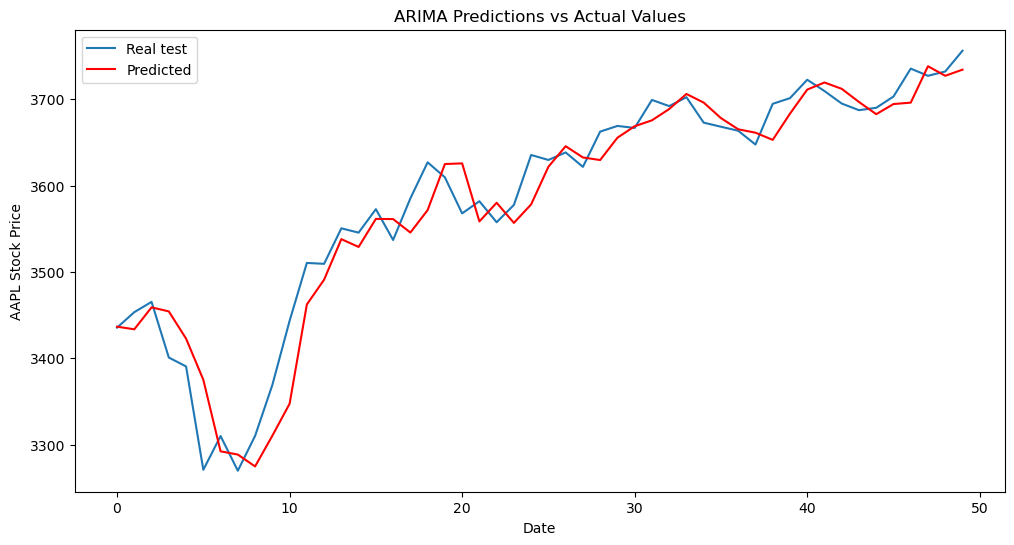

In [316]:
plt.figure(figsize=(12, 6), dpi=100)
plt.plot(test[-50:], label='Real test')
plt.plot(predictions[-50:], color='red', label='Predicted')
plt.title('ARIMA Predictions vs Actual Values')
plt.xlabel('Date')
plt.ylabel('AAPL Stock Price')
plt.legend()
plt.show()

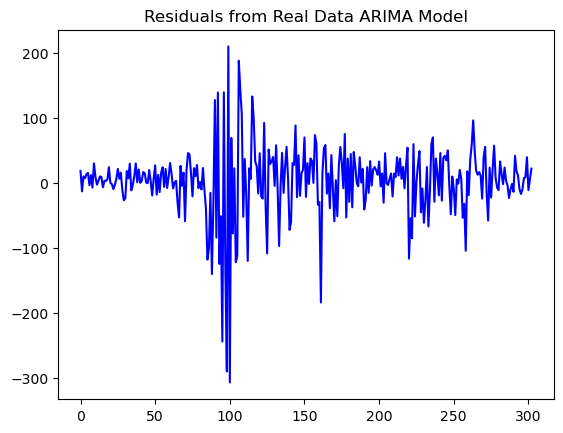

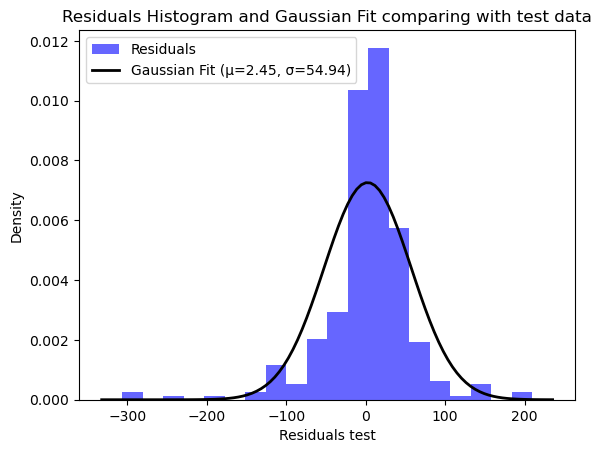

Ljung-Box Test (Real Data):      lb_stat  lb_pvalue
5  13.091105    0.02254


In [317]:
# Residuals for real data
residuals_test = test-predictions
#residuals_test = residuals_test[1:]/test[:-1]
plt.plot(residuals_test, 'b-', label='Residuals')
plt.title('Residuals from Real Data ARIMA Model')
plt.show()

# Plot the histogram of residuals
plt.hist(residuals_test, bins=20, density=True, alpha=0.6, color='b', label='Residuals')

# Fit a Gaussian distribution to the residuals
mu, std = norm.fit(residuals_test)  # Mean and standard deviation of the fitted Gaussian

# Generate points for the Gaussian distribution
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)  # Gaussian probability density function

# Plot the Gaussian distribution
plt.plot(x, p, 'k', linewidth=2, label=f'Gaussian Fit (μ={mu:.2f}, σ={std:.2f})')

# Add plot details
plt.title('Residuals Histogram and Gaussian Fit comparing with test data')
plt.xlabel('Residuals test')
plt.ylabel('Density')
plt.legend()
plt.show()
plt.show()

# Test residuals for white noise using Ljung-Box test
h = int(np.log(len(test)))
lb_test_real = acorr_ljungbox(residuals_test, lags=[h], return_df=True)
print("Ljung-Box Test (Real Data):", lb_test_real)


R^2: 0.999707917970636
Adjusted R^2: 0.9997069508115983
                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   1.000
Model:                            OLS   Adj. R-squared (uncentered):              1.000
Method:                 Least Squares   F-statistic:                          1.034e+06
Date:                Thu, 09 May 2024   Prob (F-statistic):                        0.00
Time:                        18:20:10   Log-Likelihood:                         -1643.6
No. Observations:                 303   AIC:                                      3289.
Df Residuals:                     302   BIC:                                      3293.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.0

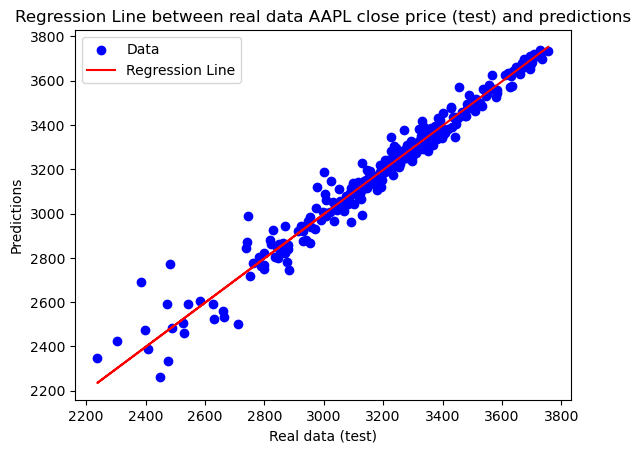

In [318]:
# Fit a simple linear regression model
model = sm.OLS(predictions, test).fit()

# Calculate R^2 and adjusted R^2
r_squared = model.rsquared
adjusted_r_squared = model.rsquared_adj

print("R^2:", r_squared)
print("Adjusted R^2:", adjusted_r_squared)

# Display the regression summary
print(model.summary())

# Scatter plot with regression line
plt.scatter(test, predictions, color='blue', label='Data')
plt.plot(test, model.predict(test), color='red', label='Regression Line')
plt.xlabel('Real data (test)')
plt.ylabel('Predictions')
plt.legend()
plt.title("Regression Line between real data AAPL close price (test) and predictions")
plt.show()


ARA, HO FAREM AMB **LA SIGNATURA**

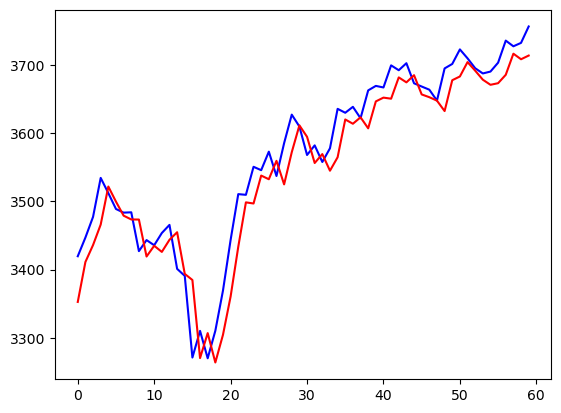

Test MSE: 3203.550


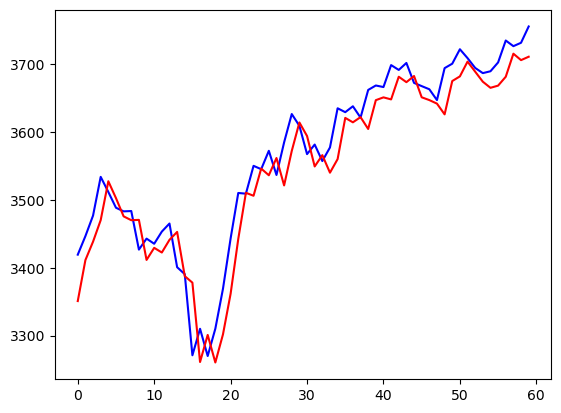

Test MSE: 3173.163


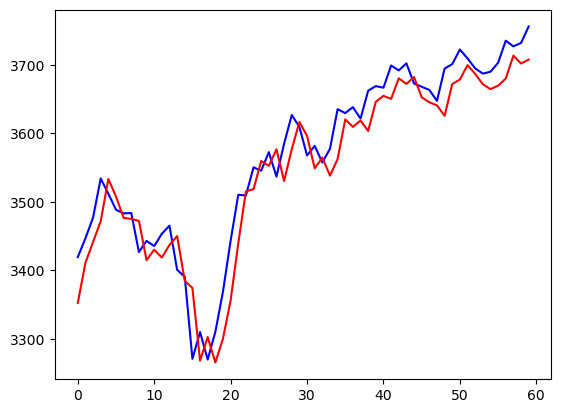

Test MSE: 3146.985


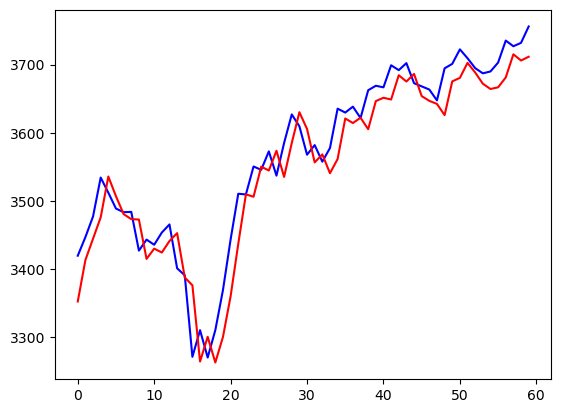

Test MSE: 3201.364


In [328]:
#We add the time variable in order to mantain uniqueness with the signature for each path
data_np = np.zeros(len(data))
for i in range(len(data)):
    data_np[i] = data.iloc[i]
h_windows = [3, 6, 8, 12]
for h_window in h_windows:
    predictions_sp = predictions_signature(data_np, int(len(X) * 0.8), h_window, 3, 3)

    #print(lasso_model.coef_)
    data_test = data_np[int(len(X) * 0.8):]

    # Plot forecasts against actual outcomes
    plt.plot(data_test[-60:], color='blue')
    plt.plot(predictions_sp[-60:], color='red')
    plt.show()

    # Calculate MSE
    mse = 0
    for i in range(len(data_test)):
        mse += (data_test[i] - predictions_sp[i]) ** 2
    mse = mse / len(data_test)
    print('Test MSE: %.3f' % mse)


In [273]:
# Confidence Intervals for RMSE
alpha = 0.05  # Significance level
n = len(predictions_sig)
mse = mean_squared_error(data_test, predictions_sig)
standard_error = np.sqrt(mse / n)

# Calculate t-value for the given significance level and degrees of freedom
t_value = tstats.ppf(1 - alpha / 2, df=n-1)

# Calculate confidence interval for RMSE
lower_bound = np.sqrt(mse/n) - t_value * standard_error
upper_bound = np.sqrt(mse/n) + t_value * standard_error

print(f'Confidence Interval for RMSE: [{lower_bound:.3f}, {upper_bound:.3f}]')
print("My mse:")
print(np.sqrt(mse/n))


Confidence Interval for RMSE: [-3.228, 9.899]
My mse:
3.3354979731650034


### **Now, we analize a garch model**

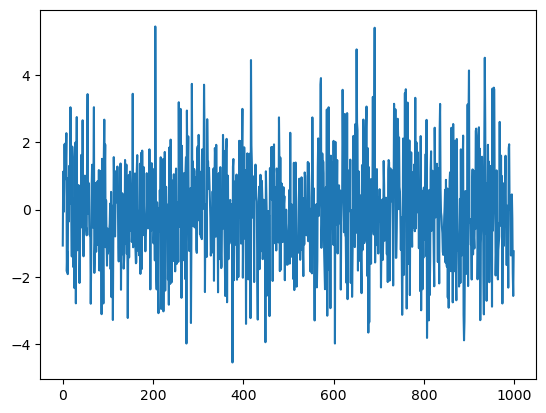

In [359]:
## Import required libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from arch import arch_model
import warnings
warnings.filterwarnings("ignore")

np.random.seed(13)
# a0 and a1 are constant and should be greater than 0
a0 = 2
a1 = .5
# Random number generator with size 1000:
y = w = np.random.normal(size=1000)
Y = np.empty_like(y)
for t in range(len(y)):
    Y[t] = w[t] * np.sqrt((a0 + a1*y[t-1]**2))   #Formula of ARCH(1)
# simulated ARCH(1) series, looks like white noise
plt.plot(Y)

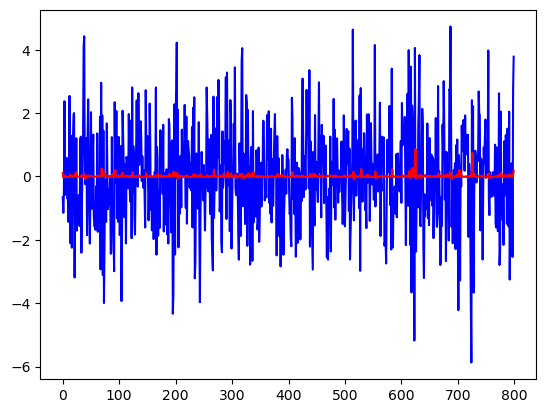

Test MSE: 2.422


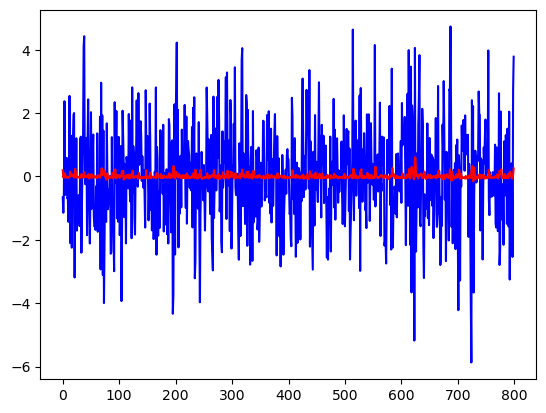

Test MSE: 2.420


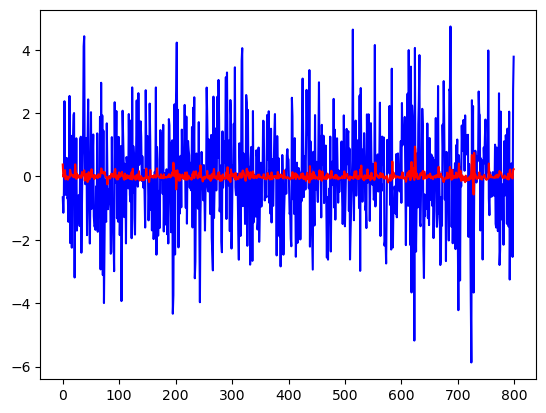

Test MSE: 2.437


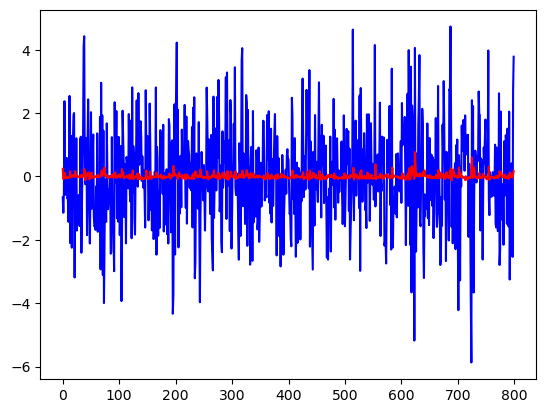

Test MSE: 2.421


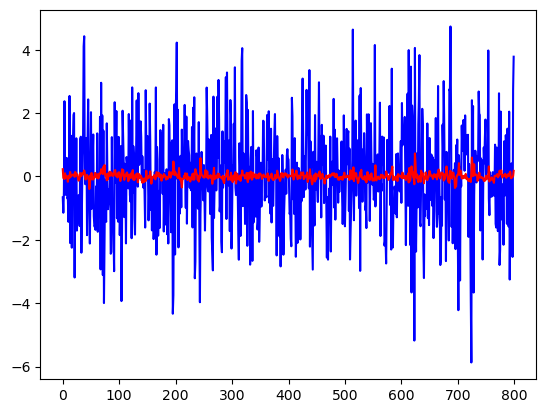

Test MSE: 2.421


In [360]:
h_windows = [2,4,6,8,10]
for h_window in h_windows:
    predictions_garch = predictions_signature(eps, [], int(len(eps)*0.8), h_window, 4, 4)
    #print(lasso_model.coef_)
    eps_test = eps[-len(predictions_garch):]

    # Plot forecasts against actual outcomes
    plt.plot(eps_test, color='blue')
    plt.plot(predictions_garch, color='red')
    plt.show()

    # Calculate MSE
    mse = 0
    for i in range(len(eps_test)):
        mse += (eps_test[i] - predictions_garch[i]) ** 2
    mse = mse / len(eps_test)
    print('Test MSE: %.3f' % mse)
    

In [96]:
# Define the Nasdaq symbol and date range
nsdq_symbol = "^IXIC"
start_date = "2015-01-01"
end_date = "2022-12-31"

# Fetch historical data for the S&P 500 index
nasdaq = yf.download(nsdq_symbol, start=start_date, end=end_date)

# Display the first few rows of the data
print(nasdaq.head())

[*********************100%%**********************]  1 of 1 completed

                   Open         High          Low        Close    Adj Close  \
Date                                                                          
2015-01-02  4760.240234  4777.009766  4698.109863  4726.810059  4726.810059   
2015-01-05  4700.339844  4702.770020  4641.459961  4652.569824  4652.569824   
2015-01-06  4666.850098  4667.330078  4567.589844  4592.740234  4592.740234   
2015-01-07  4626.839844  4652.720215  4613.899902  4650.470215  4650.470215   
2015-01-08  4689.540039  4741.379883  4688.020020  4736.189941  4736.189941   

                Volume  
Date                    
2015-01-02  1435150000  
2015-01-05  1794470000  
2015-01-06  2167320000  
2015-01-07  1957950000  
2015-01-08  2105450000  


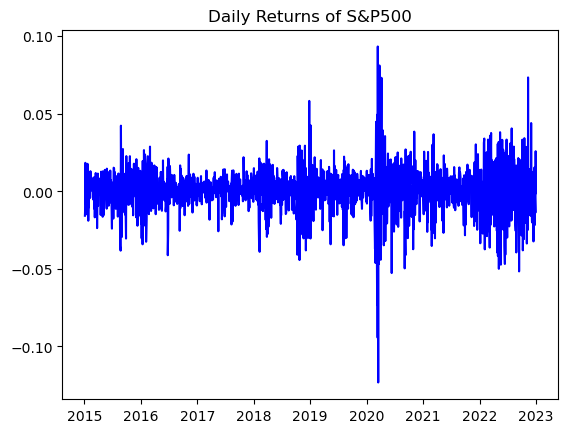

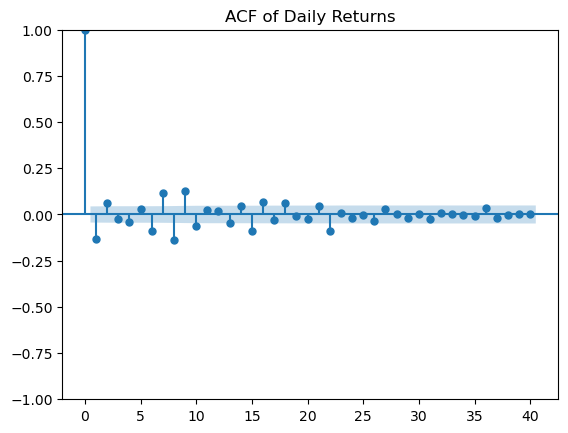

Ljung-Box Test:     lb_stat     lb_pvalue
7  94.07937  1.793509e-17


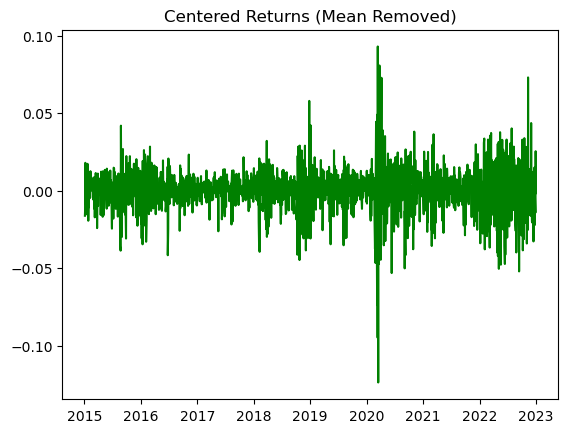

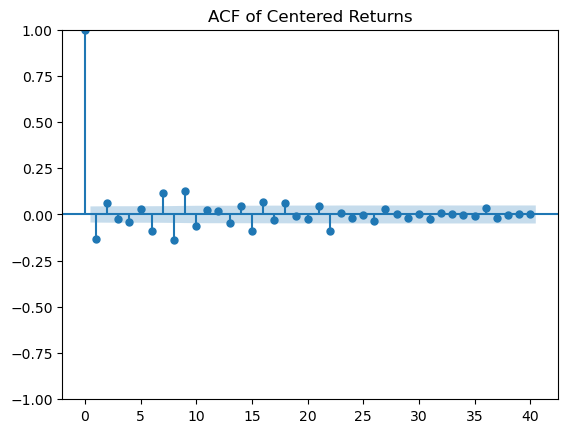

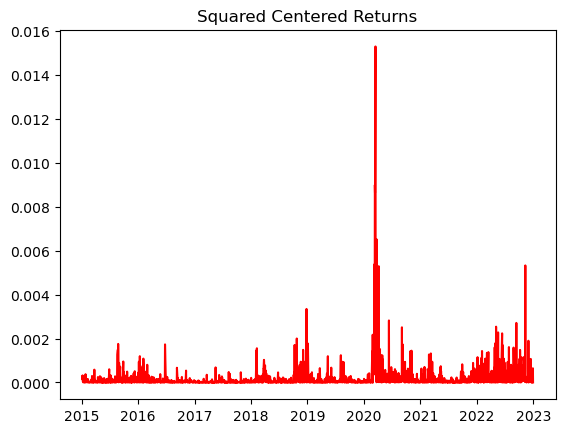

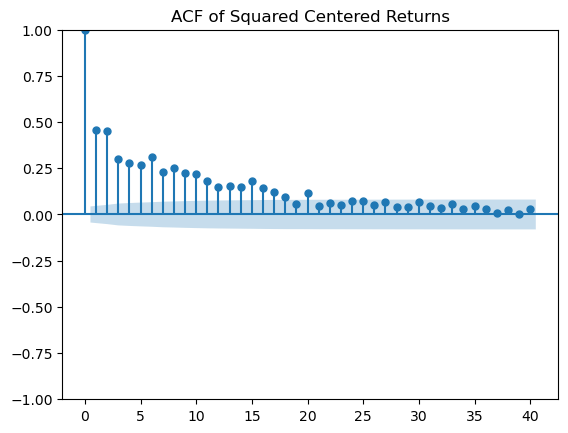

Ljung-Box Test (Squared Returns):        lb_stat  lb_pvalue
7  1629.224257        0.0


In [98]:
#Let's examine the  white noise characteristics with the S&P500 data and plot the results.
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.stats.diagnostic import acorr_ljungbox
from scipy.stats import norm

# Load S&P500 data
# Assume 'Close' contains daily closing prices
returns = nasdaq['Close'].pct_change().dropna()  # Daily returns

# Plotting daily returns
plt.plot(returns, 'b-')
plt.title("Daily Returns of S&P500")
plt.show()

# Autocorrelation function (ACF)
plot_acf(returns, lags=40, alpha=0.05)
plt.title("ACF of Daily Returns")
plt.show()

# Ljung-Box test for white noise
h = int(np.log(len(returns)))
lb_test = acorr_ljungbox(returns, lags=[h], return_df=True)
print("Ljung-Box Test:", lb_test)

#High lb_stat: The test statistic is quite high, indicating strong evidence of autocorrelation.
#Very Low P-value: A p-value of 4.017798e-57 is extremely low, suggesting that the likelihood of getting this test statistic under the null hypothesis is exceedingly rare. 
#This strongly implies that the time series does not resemble white noise, indicating significant autocorrelation.

# Removing the mean to make it centered
mean_return = np.mean(returns)
x = returns - mean_return
plt.plot(x, 'g-')
plt.title("Centered Returns (Mean Removed)")
plt.show()

plot_acf(x, lags=40, alpha=0.05)
plt.title("ACF of Centered Returns")
plt.show()

# Squaring the series to analyze variance
y = x**2
plt.plot(y, 'r-')
plt.title("Squared Centered Returns")
plt.show()

# ACF of the squared series
plot_acf(y, lags=40, alpha=0.05)
plt.title("ACF of Squared Centered Returns")
plt.show()

# Ljung-Box test on squared returns

lb_test_squared = acorr_ljungbox(y, lags=[h], return_df=True)
print("Ljung-Box Test (Squared Returns):", lb_test_squared)

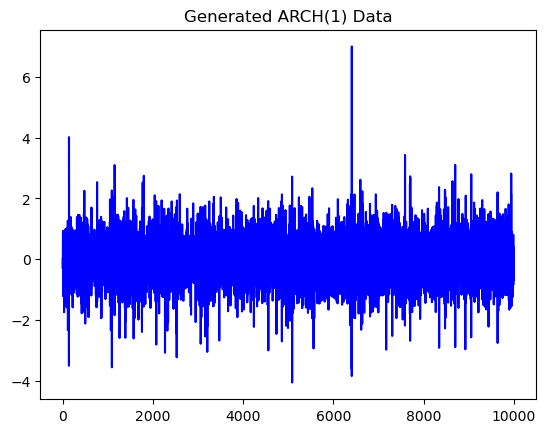

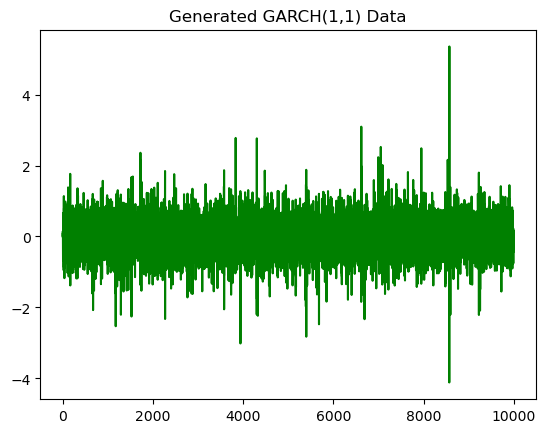

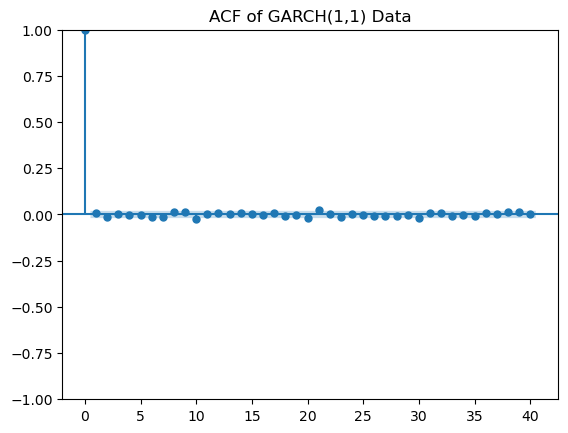

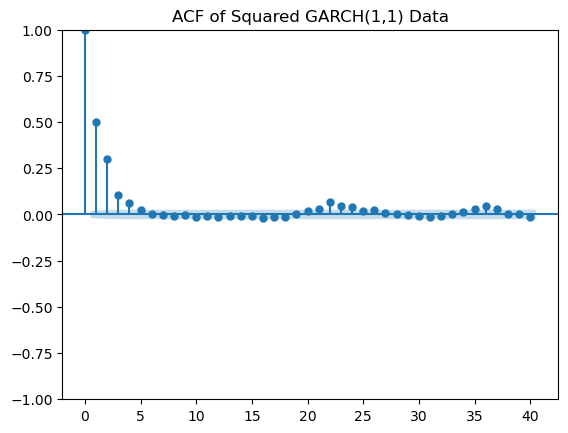

In [22]:
# Generating an ARCH(1) model
a0 = 0.25
a1 = 0.5
n = 9999

arch_data = np.zeros(n)
x0 = norm.rvs()

# Creating the ARCH(1) process
for i in range(1, n):
    x0 = norm.rvs(scale=np.sqrt(a0 + a1 * x0**2))
    arch_data[i] = x0

plt.plot(arch_data, 'b-')
plt.title("Generated ARCH(1) Data")
plt.show()

# Generating a GARCH(1,1) model
a0 = 0.1
a1 = 0.4
b1 = 0.2
n = 10000

garch_data = np.zeros(n)
h = np.zeros(n)
w = norm.rvs(size=n)

# Creating the GARCH(1,1) process
for i in range(1, n):
    h[i] = a0 + a1 * (garch_data[i - 1] ** 2) + b1 * h[i - 1]
    garch_data[i] = w[i] * np.sqrt(h[i])

plt.plot(garch_data, 'g-')
plt.title("Generated GARCH(1,1) Data")
plt.show()

plot_acf(garch_data, lags=40, alpha=0.05)
plt.title("ACF of GARCH(1,1) Data")
plt.show()

# ACF of squared GARCH data
plot_acf(garch_data**2, lags=40, alpha=0.05)
plt.title("ACF of Squared GARCH(1,1) Data")
plt.show()

/Users/oscarromero/anaconda3/lib/python3.11/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001945. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


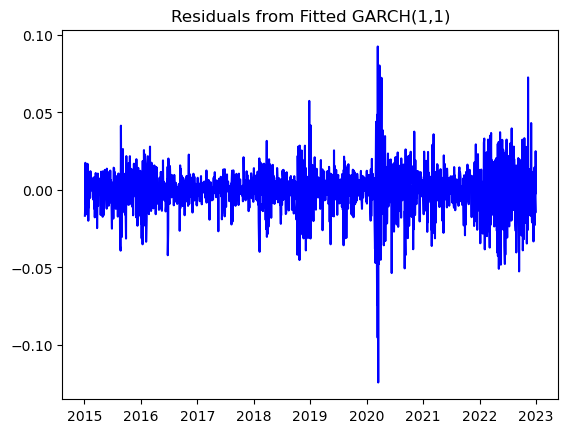

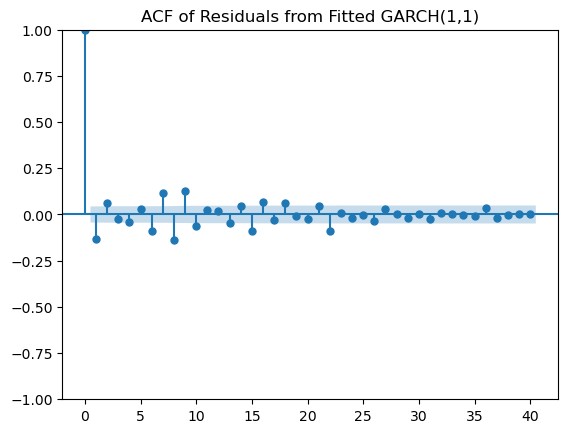

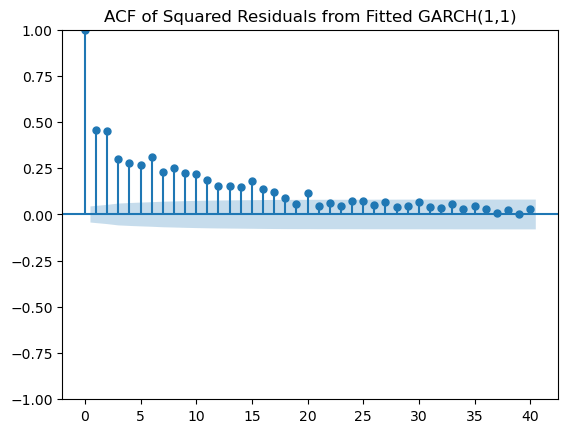

Confidence Intervals for GARCH(1,1) Parameters:              lower     upper
mu       -0.000118  0.001089
omega     0.000087  0.000108
alpha[1]  0.142324  0.257676
                      Constant Mean - ARCH Model Results                      
Dep. Variable:                  Close   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:                5860.40
Distribution:                  Normal   AIC:                          -11714.8
Method:            Maximum Likelihood   BIC:                          -11698.0
                                        No. Observations:                 2013
Date:                Wed, May 08 2024   Df Residuals:                     2012
Time:                        11:34:05   Df Model:                            1
                                  Mean Model                                 
                 coef    std err          t    

/Users/oscarromero/anaconda3/lib/python3.11/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001945. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


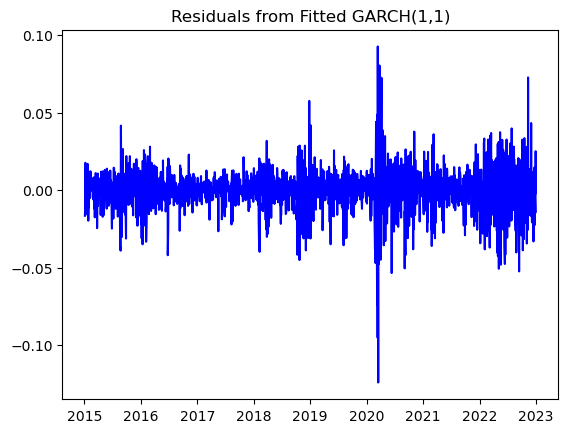

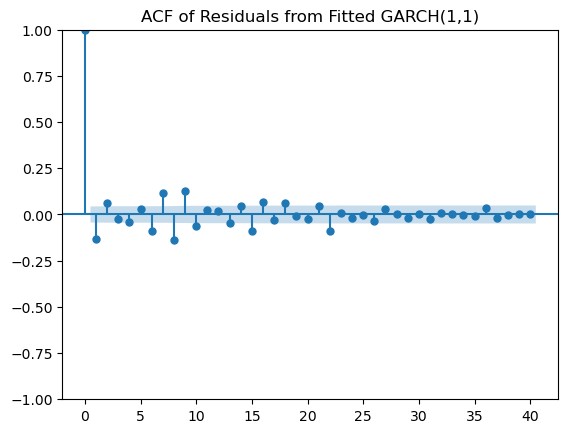

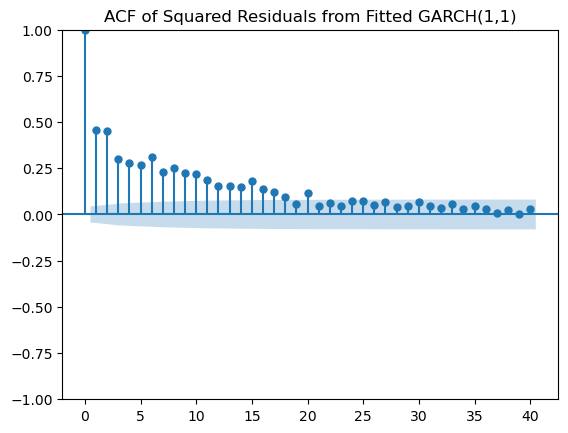

Confidence Intervals for GARCH(1,1) Parameters:              lower     upper
mu        0.000267  0.000472
omega     0.000004  0.000004
alpha[1]  0.072813  0.127187
beta[1]   0.857916  0.902084
                     Constant Mean - GARCH Model Results                      
Dep. Variable:                  Close   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                6172.78
Distribution:                  Normal   AIC:                          -12337.6
Method:            Maximum Likelihood   BIC:                          -12315.1
                                        No. Observations:                 2013
Date:                Wed, May 08 2024   Df Residuals:                     2012
Time:                        11:34:06   Df Model:                            1
                                 Mean Model                                 
                 co

/Users/oscarromero/anaconda3/lib/python3.11/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001945. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


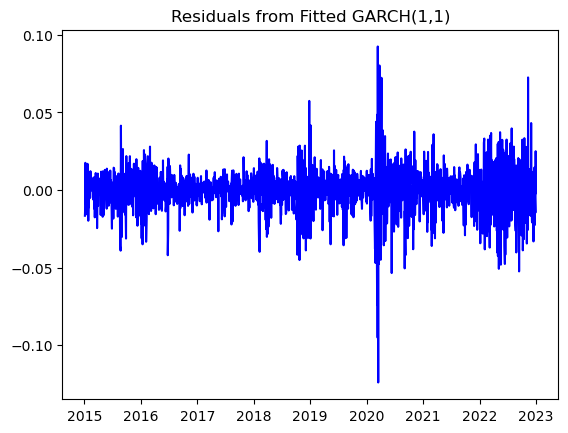

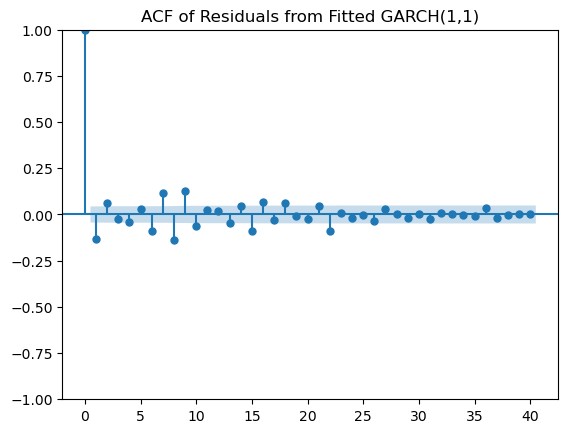

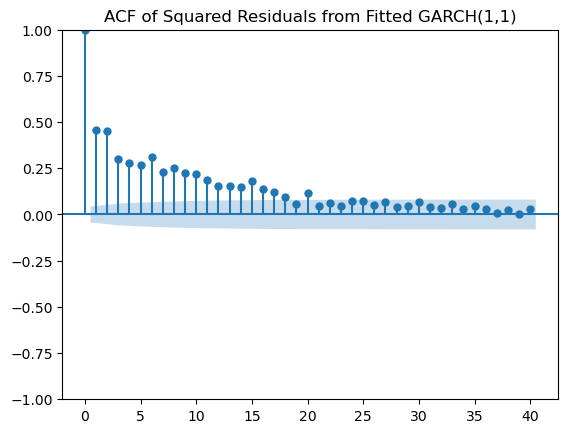

Confidence Intervals for GARCH(1,1) Parameters:              lower     upper
mu       -0.000015  0.000867
omega     0.000005  0.000005
alpha[1]  0.200547  0.200741
beta[1]   0.253763  0.527219
beta[2]   0.254531  0.526451
                     Constant Mean - GARCH Model Results                      
Dep. Variable:                  Close   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                6177.80
Distribution:                  Normal   AIC:                          -12345.6
Method:            Maximum Likelihood   BIC:                          -12317.6
                                        No. Observations:                 2013
Date:                Wed, May 08 2024   Df Residuals:                     2012
Time:                        11:34:07   Df Model:                            1
                                  Mean Model                       

/Users/oscarromero/anaconda3/lib/python3.11/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001945. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


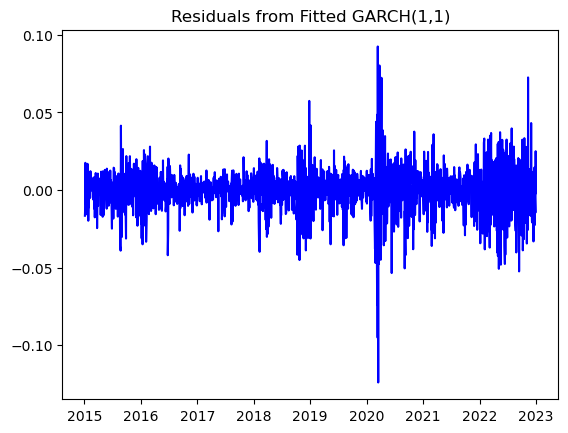

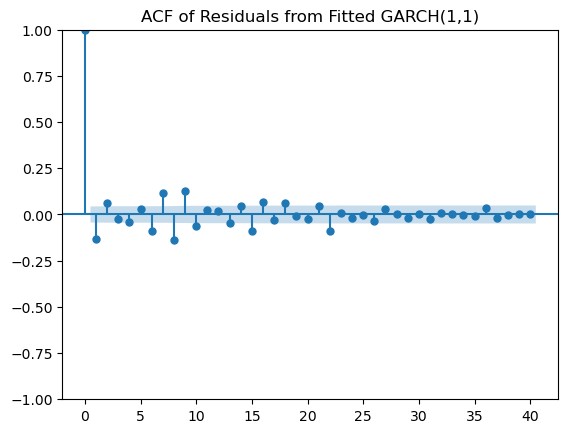

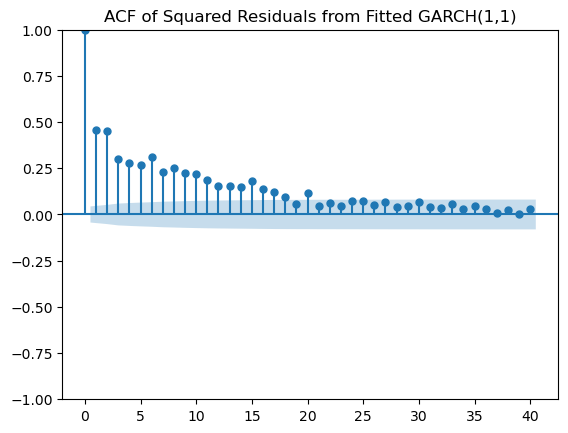

Confidence Intervals for GARCH(1,1) Parameters:              lower     upper
mu        0.000351  0.000482
omega     0.000004  0.000004
alpha[1]  0.134192  0.265808
beta[1]  -0.025711  0.545711
beta[2]   0.088405  0.431595
beta[3]  -0.068339  0.588339
                     Constant Mean - GARCH Model Results                      
Dep. Variable:                  Close   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                6172.82
Distribution:                  Normal   AIC:                          -12333.6
Method:            Maximum Likelihood   BIC:                          -12300.0
                                        No. Observations:                 2013
Date:                Wed, May 08 2024   Df Residuals:                     2012
Time:                        11:34:08   Df Model:                            1
                                 Mean 

/Users/oscarromero/anaconda3/lib/python3.11/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001945. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


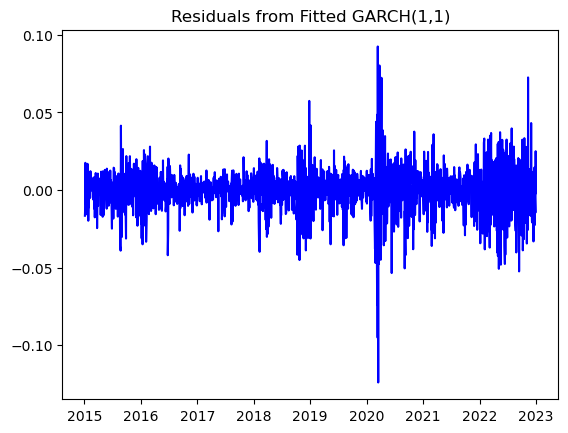

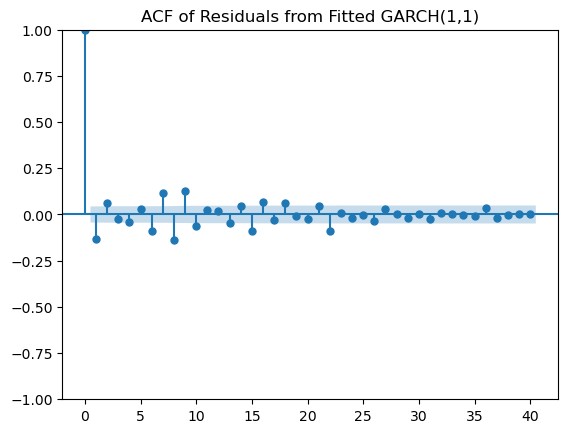

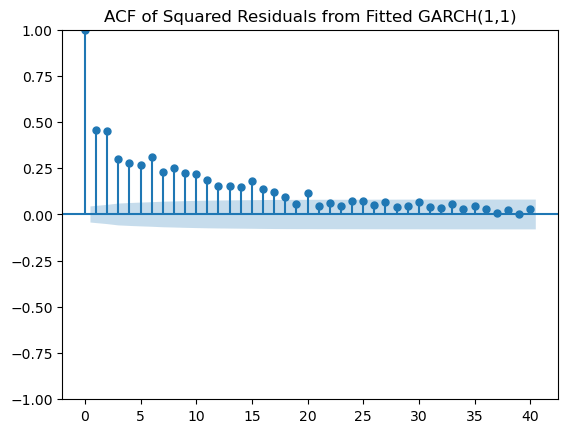

Confidence Intervals for GARCH(1,1) Parameters:              lower     upper
mu       -0.000040  0.000884
omega     0.000004  0.000004
alpha[1]  0.190301  0.209699
beta[1]  -0.331665  0.721665
beta[2]  -0.124454  0.514454
beta[3]  -0.588840  0.978840
beta[4]  -0.400207  0.790207
                     Constant Mean - GARCH Model Results                      
Dep. Variable:                  Close   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                6163.60
Distribution:                  Normal   AIC:                          -12313.2
Method:            Maximum Likelihood   BIC:                          -12273.9
                                        No. Observations:                 2013
Date:                Wed, May 08 2024   Df Residuals:                     2012
Time:                        11:34:09   Df Model:                            1
         

/Users/oscarromero/anaconda3/lib/python3.11/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001945. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


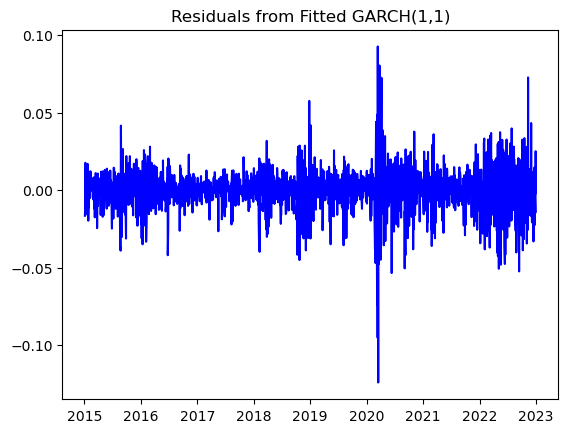

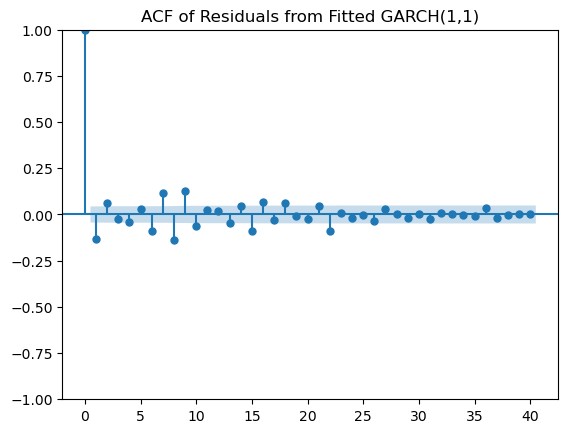

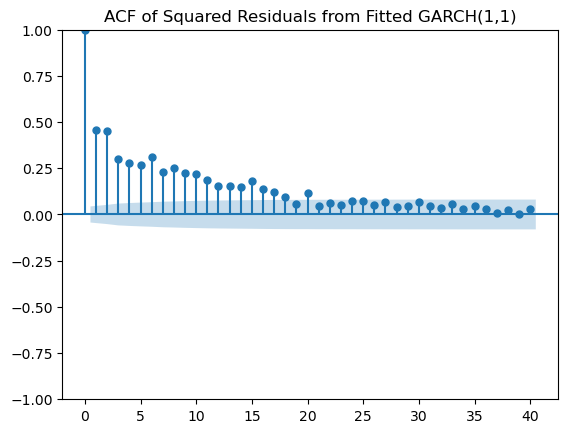

Confidence Intervals for GARCH(1,1) Parameters:              lower     upper
mu       -0.000247  0.000832
omega     0.000085  0.000110
alpha[1]  0.057416  0.142584
alpha[2]  0.065199  0.134805
                      Constant Mean - ARCH Model Results                      
Dep. Variable:                  Close   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:                5958.31
Distribution:                  Normal   AIC:                          -11908.6
Method:            Maximum Likelihood   BIC:                          -11886.2
                                        No. Observations:                 2013
Date:                Wed, May 08 2024   Df Residuals:                     2012
Time:                        11:34:10   Df Model:                            1
                                  Mean Model                                 
                 c

/Users/oscarromero/anaconda3/lib/python3.11/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001945. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


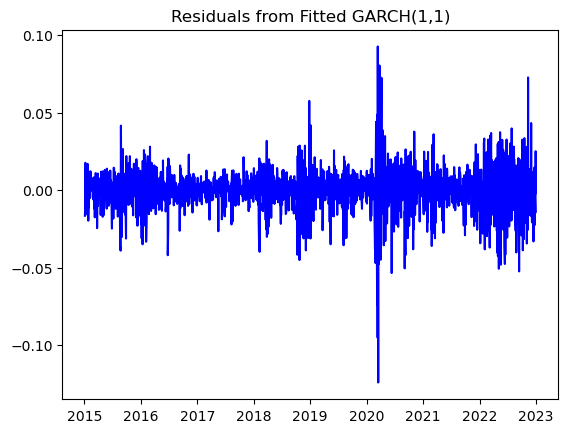

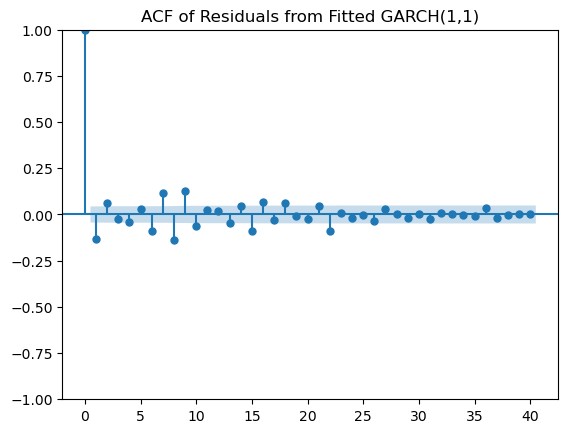

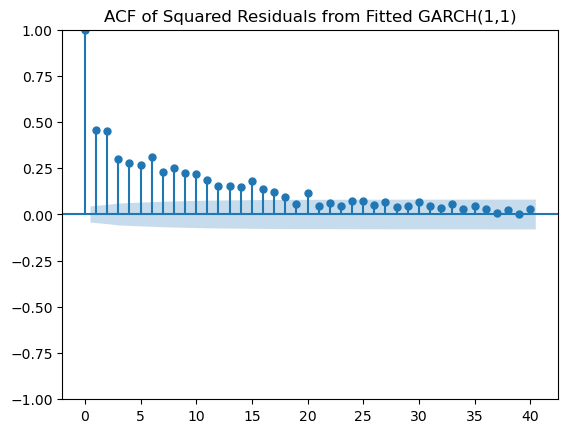

Confidence Intervals for GARCH(1,1) Parameters:              lower     upper
mu       -0.000103  0.000811
omega     0.000004  0.000004
alpha[1]  0.037047  0.162955
alpha[2]  0.030800  0.169202
beta[1]   0.766327  0.793674
                     Constant Mean - GARCH Model Results                      
Dep. Variable:                  Close   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                6168.65
Distribution:                  Normal   AIC:                          -12327.3
Method:            Maximum Likelihood   BIC:                          -12299.3
                                        No. Observations:                 2013
Date:                Wed, May 08 2024   Df Residuals:                     2012
Time:                        11:34:11   Df Model:                            1
                                  Mean Model                       

/Users/oscarromero/anaconda3/lib/python3.11/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001945. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


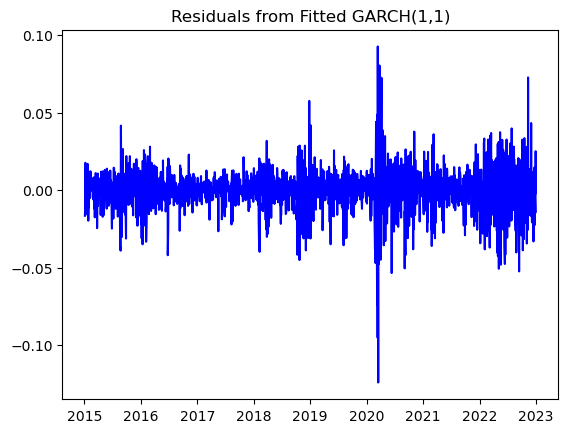

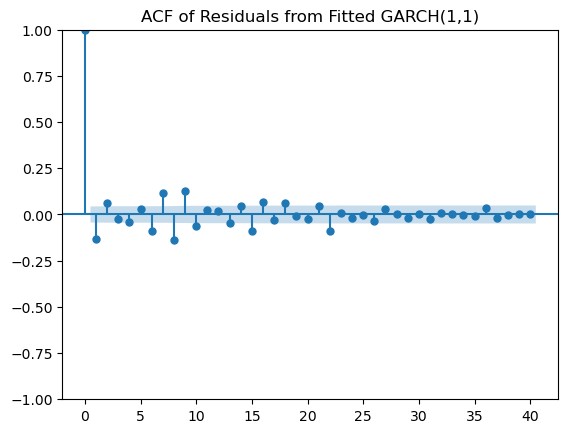

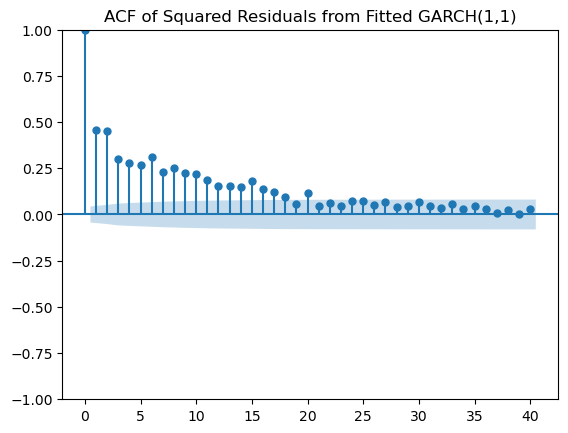

Confidence Intervals for GARCH(1,1) Parameters:              lower     upper
mu        0.000314  0.000405
omega     0.000004  0.000004
alpha[1]  0.036184  0.163816
alpha[2] -0.000474  0.200474
beta[1]  -0.520207  1.300207
beta[2]  -0.448640  1.228640
                     Constant Mean - GARCH Model Results                      
Dep. Variable:                  Close   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                6174.99
Distribution:                  Normal   AIC:                          -12338.0
Method:            Maximum Likelihood   BIC:                          -12304.3
                                        No. Observations:                 2013
Date:                Wed, May 08 2024   Df Residuals:                     2012
Time:                        11:34:13   Df Model:                            1
                                 Mean 

/Users/oscarromero/anaconda3/lib/python3.11/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001945. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


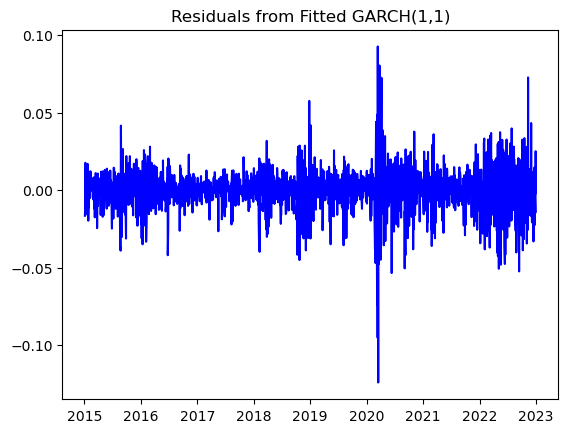

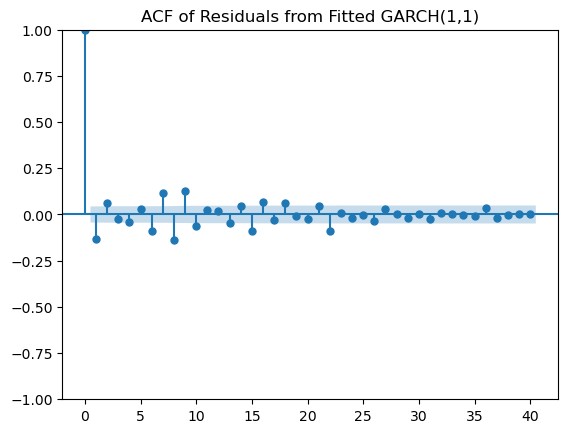

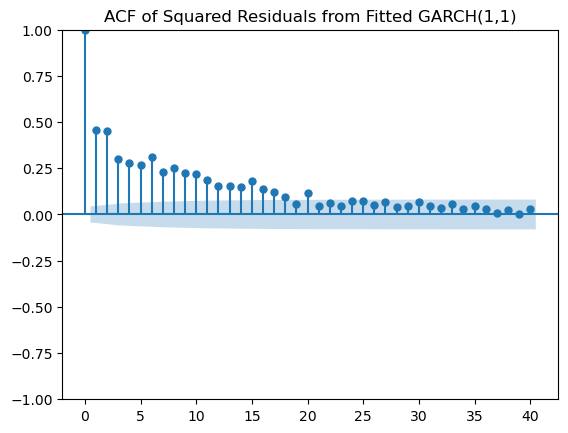

Confidence Intervals for GARCH(1,1) Parameters:              lower     upper
mu       -0.000150  0.000889
omega     0.000004  0.000004
alpha[1]  0.033907  0.166093
alpha[2] -0.045830  0.245830
beta[1]  -1.535857  2.055857
beta[2]  -2.257979  2.777979
beta[3]  -0.578435  1.098435
                     Constant Mean - GARCH Model Results                      
Dep. Variable:                  Close   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                6172.97
Distribution:                  Normal   AIC:                          -12331.9
Method:            Maximum Likelihood   BIC:                          -12292.7
                                        No. Observations:                 2013
Date:                Wed, May 08 2024   Df Residuals:                     2012
Time:                        11:34:14   Df Model:                            1
         

/Users/oscarromero/anaconda3/lib/python3.11/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001945. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


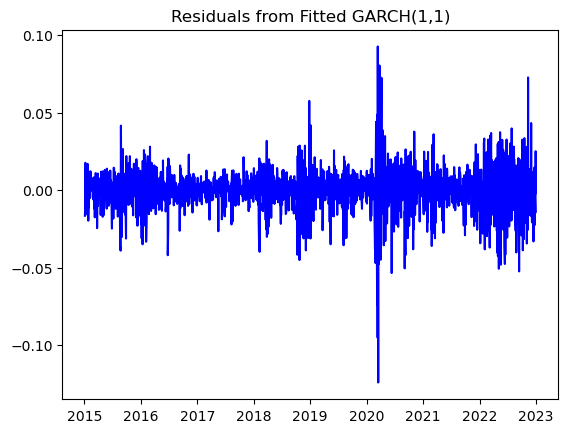

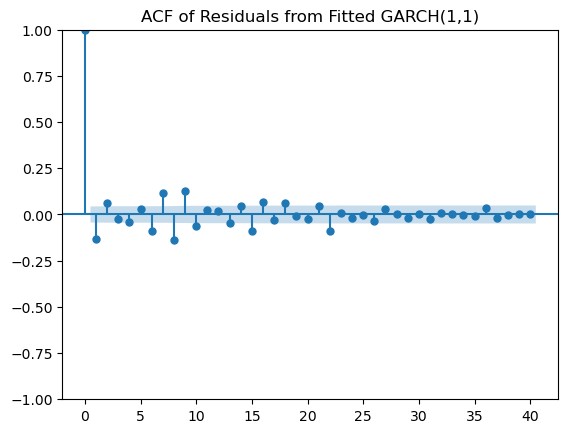

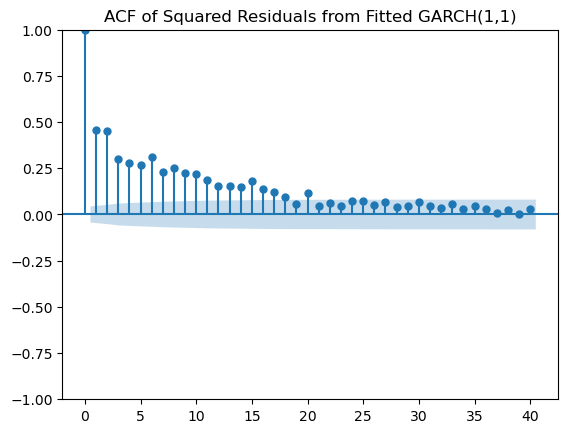

Confidence Intervals for GARCH(1,1) Parameters:              lower     upper
mu       -0.000008  0.000728
omega     0.000004  0.000004
alpha[1]  0.008117  0.191884
alpha[2] -0.067715  0.267715
beta[1]  -0.310077  0.700077
beta[2]  -0.369551  0.759551
beta[3]  -0.989890  1.379890
beta[4]  -0.975554  1.365554
                     Constant Mean - GARCH Model Results                      
Dep. Variable:                  Close   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                6169.26
Distribution:                  Normal   AIC:                          -12322.5
Method:            Maximum Likelihood   BIC:                          -12277.7
                                        No. Observations:                 2013
Date:                Wed, May 08 2024   Df Residuals:                     2012
Time:                        11:34:16   Df Model:          

/Users/oscarromero/anaconda3/lib/python3.11/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001945. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


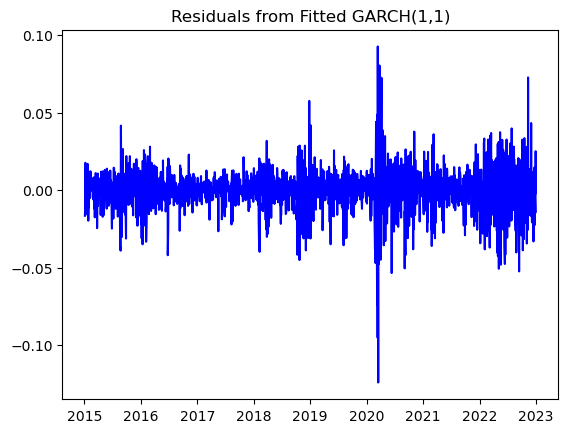

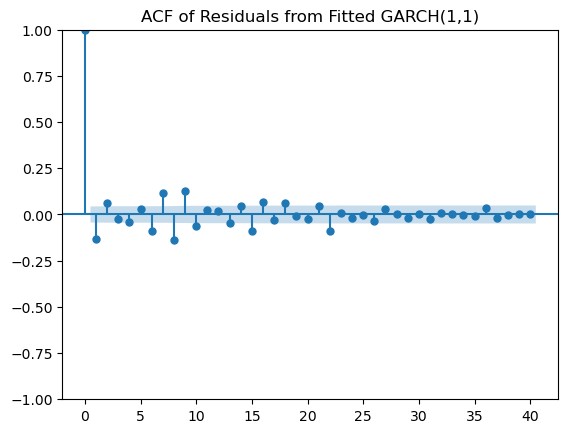

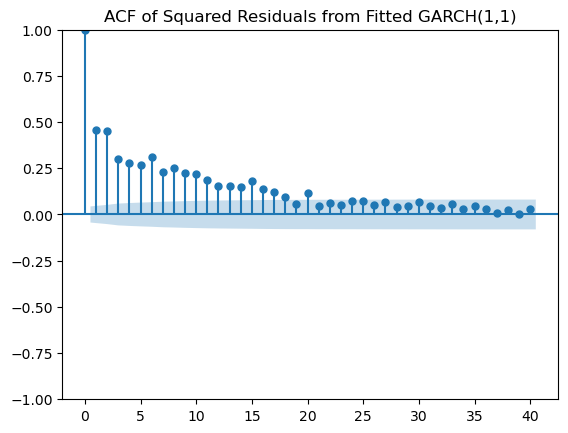

Confidence Intervals for GARCH(1,1) Parameters:              lower     upper
mu       -0.000241  0.000815
omega     0.000083  0.000112
alpha[1]  0.027673  0.105655
alpha[2]  0.038123  0.095301
alpha[3]  0.031121  0.102207
                      Constant Mean - ARCH Model Results                      
Dep. Variable:                  Close   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:                5978.67
Distribution:                  Normal   AIC:                          -11947.3
Method:            Maximum Likelihood   BIC:                          -11919.3
                                        No. Observations:                 2013
Date:                Wed, May 08 2024   Df Residuals:                     2012
Time:                        11:34:17   Df Model:                            1
                                  Mean Model                       

/Users/oscarromero/anaconda3/lib/python3.11/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001945. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


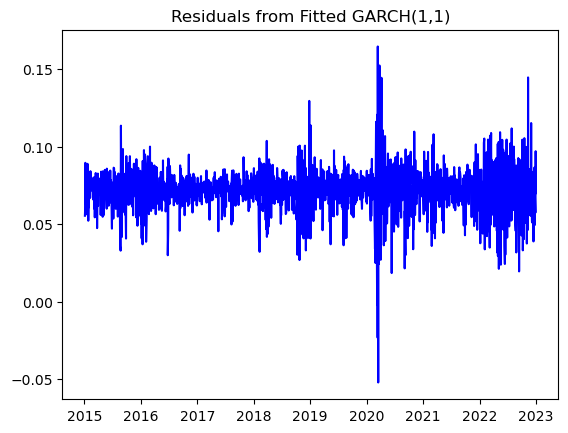

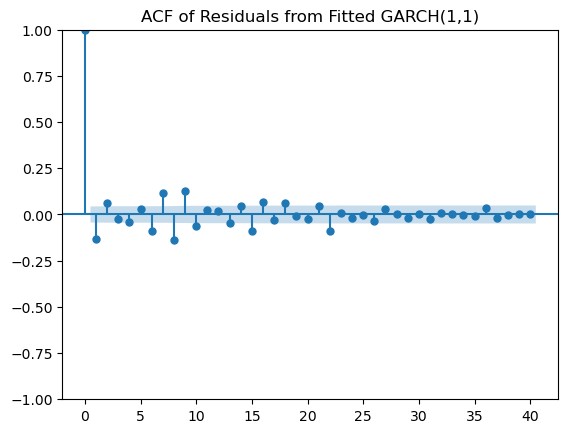

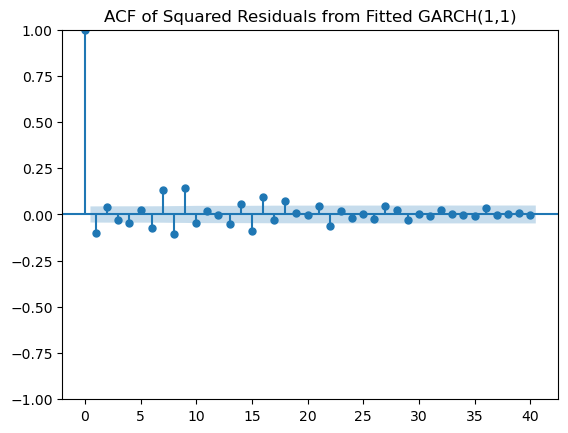

Confidence Intervals for GARCH(1,1) Parameters:              lower     upper
mu       -0.074960 -0.068314
omega    -0.000098  0.000106
alpha[1] -0.017529  0.151754
alpha[2] -0.050897  0.184141
alpha[3] -0.096989  0.230233
beta[1]   0.601315  0.957689
                     Constant Mean - GARCH Model Results                      
Dep. Variable:                  Close   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                2379.49
Distribution:                  Normal   AIC:                          -4746.99
Method:            Maximum Likelihood   BIC:                          -4713.34
                                        No. Observations:                 2013
Date:                Wed, May 08 2024   Df Residuals:                     2012
Time:                        11:34:18   Df Model:                            1
                                  Mean

/Users/oscarromero/anaconda3/lib/python3.11/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001945. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


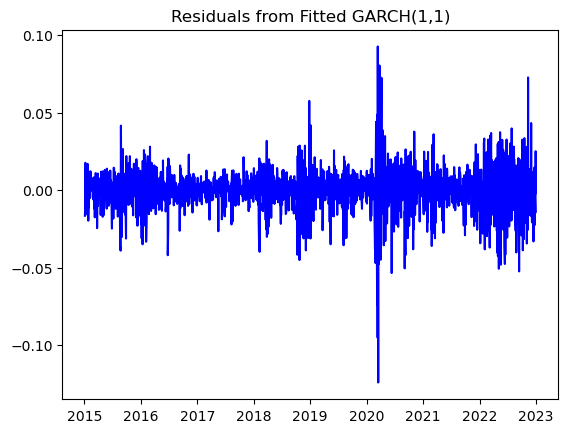

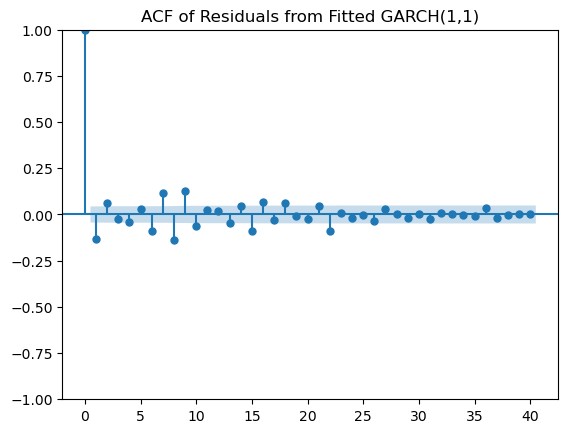

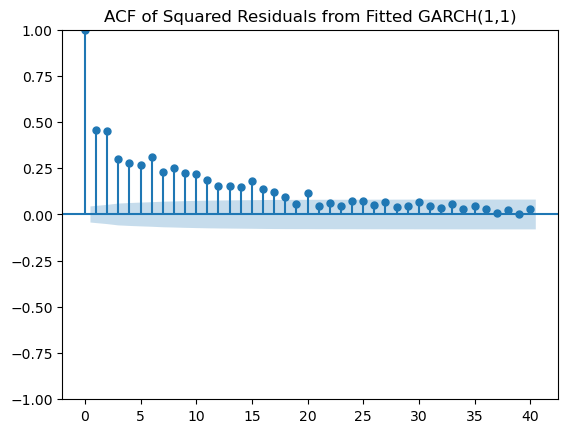

Confidence Intervals for GARCH(1,1) Parameters:              lower     upper
mu        0.000288  0.000381
omega     0.000005  0.000005
alpha[1] -0.037183  0.171485
alpha[2] -0.420398  0.553700
alpha[3] -0.183321  0.316596
beta[1]  -2.488177  3.267823
beta[2]  -2.333344  3.112988
                     Constant Mean - GARCH Model Results                      
Dep. Variable:                  Close   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                6171.20
Distribution:                  Normal   AIC:                          -12328.4
Method:            Maximum Likelihood   BIC:                          -12289.1
                                        No. Observations:                 2013
Date:                Wed, May 08 2024   Df Residuals:                     2012
Time:                        11:34:19   Df Model:                            1
         

/Users/oscarromero/anaconda3/lib/python3.11/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001945. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


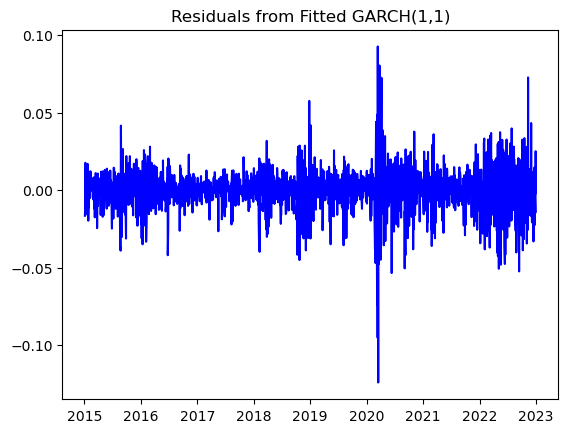

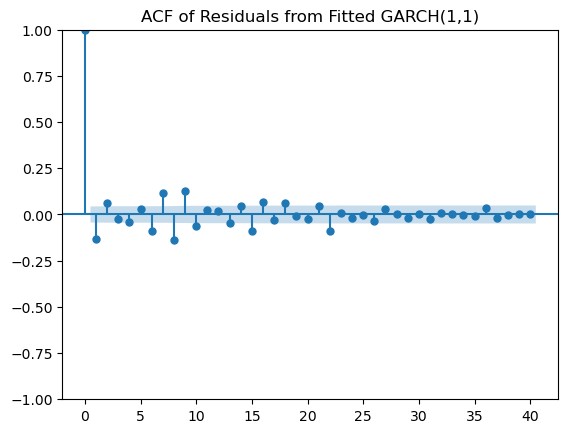

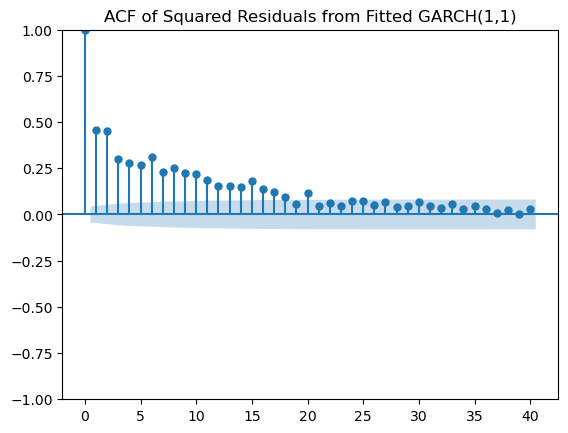

Confidence Intervals for GARCH(1,1) Parameters:              lower     upper
mu        0.000245  0.000387
omega     0.000004  0.000004
alpha[1]  0.017942  0.115427
alpha[2] -0.069331  0.202669
alpha[3] -0.004517  0.137848
beta[1]  -1.510215  2.030210
beta[2]  -0.670571  1.190564
beta[3]  -0.843370  1.363364
                     Constant Mean - GARCH Model Results                      
Dep. Variable:                  Close   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                6167.46
Distribution:                  Normal   AIC:                          -12318.9
Method:            Maximum Likelihood   BIC:                          -12274.1
                                        No. Observations:                 2013
Date:                Wed, May 08 2024   Df Residuals:                     2012
Time:                        11:34:20   Df Model:          

/Users/oscarromero/anaconda3/lib/python3.11/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001945. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


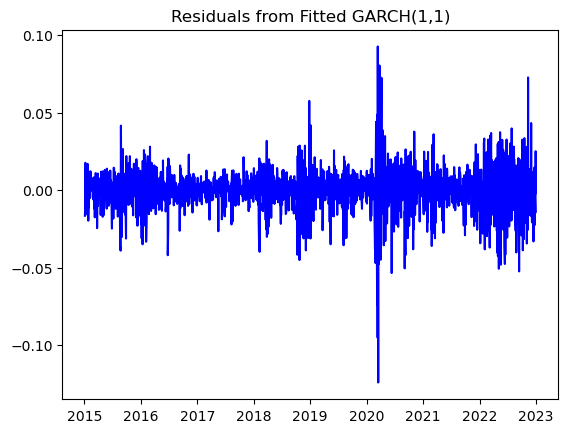

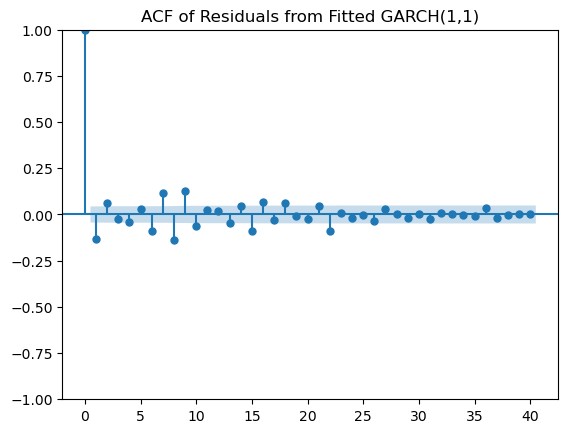

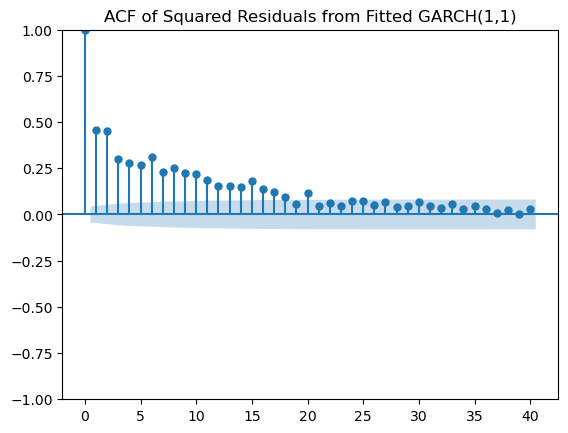

Confidence Intervals for GARCH(1,1) Parameters:               lower      upper
mu        -0.000809   0.001445
omega      0.000004   0.000004
alpha[1]  -1.442658   1.576090
alpha[2]  -3.972510   4.105829
alpha[3]  -0.907776   1.041130
beta[1]  -18.917352  19.307341
beta[2]   -8.692272   9.082274
beta[3]   -9.725243  10.115246
beta[4]  -34.342535  34.732547
                     Constant Mean - GARCH Model Results                      
Dep. Variable:                  Close   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                6164.15
Distribution:                  Normal   AIC:                          -12310.3
Method:            Maximum Likelihood   BIC:                          -12259.8
                                        No. Observations:                 2013
Date:                Wed, May 08 2024   Df Residuals:                     2012
Time:     

/Users/oscarromero/anaconda3/lib/python3.11/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001945. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


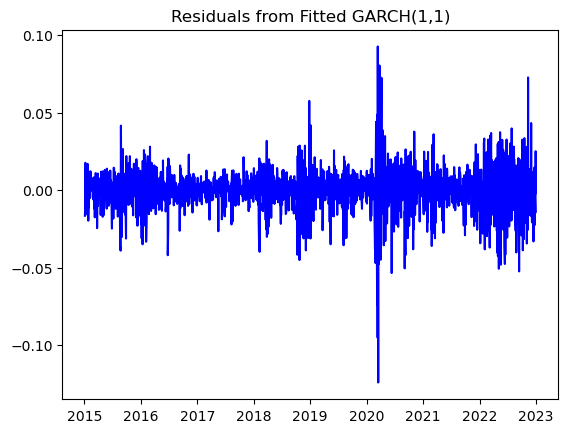

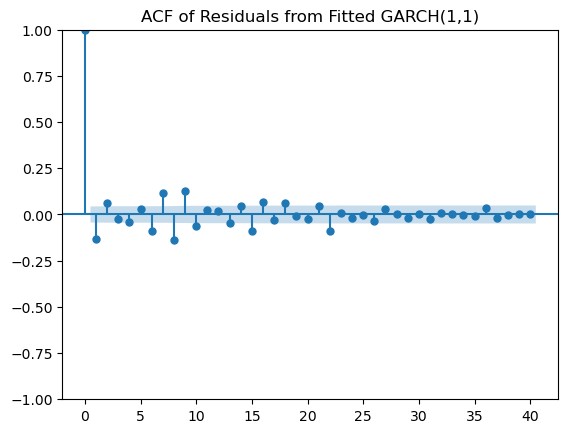

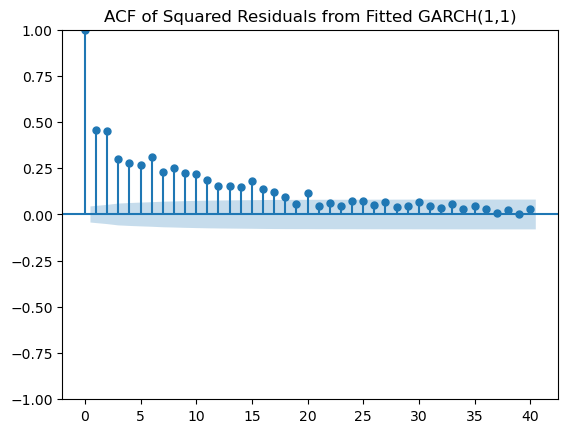

Confidence Intervals for GARCH(1,1) Parameters:              lower     upper
mu       -0.000191  0.000844
omega     0.000081  0.000113
alpha[1]  0.013757  0.086137
alpha[2]  0.025594  0.076408
alpha[3]  0.014544  0.085350
alpha[4]  0.017968  0.081927
                      Constant Mean - ARCH Model Results                      
Dep. Variable:                  Close   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:                5991.53
Distribution:                  Normal   AIC:                          -11971.1
Method:            Maximum Likelihood   BIC:                          -11937.4
                                        No. Observations:                 2013
Date:                Wed, May 08 2024   Df Residuals:                     2012
Time:                        11:34:22   Df Model:                            1
                                  Mean

/Users/oscarromero/anaconda3/lib/python3.11/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001945. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


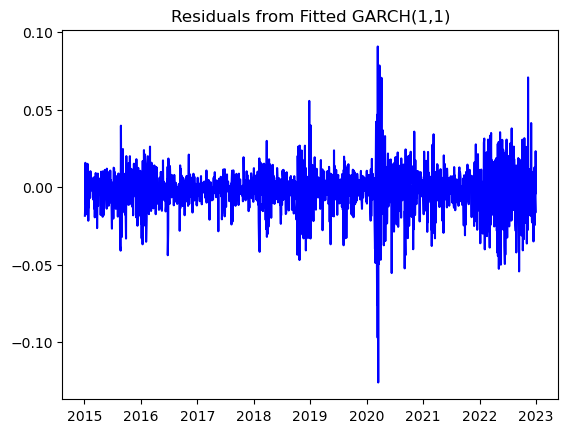

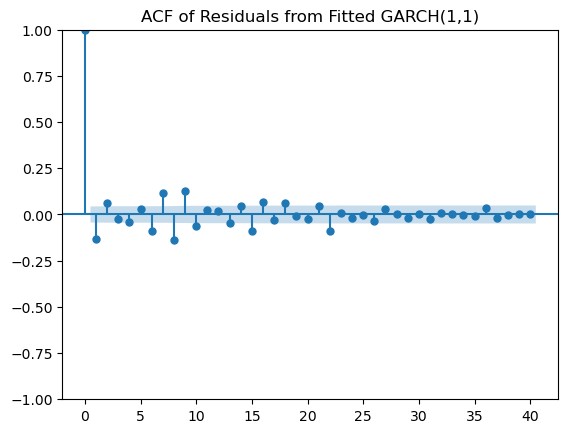

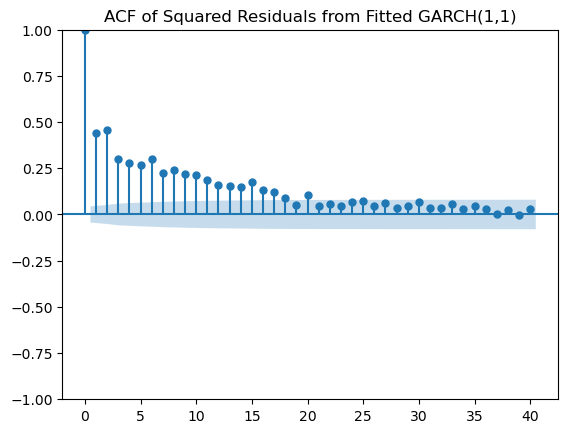

Confidence Intervals for GARCH(1,1) Parameters:              lower     upper
mu        0.002201  0.002213
omega     0.000004  0.000004
alpha[1]  0.003765  0.096447
alpha[2] -0.017789  0.118002
alpha[3] -0.035041  0.135253
alpha[4] -0.061622  0.161835
beta[1]   0.660457  0.899592
                     Constant Mean - GARCH Model Results                      
Dep. Variable:                  Close   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                6117.83
Distribution:                  Normal   AIC:                          -12221.7
Method:            Maximum Likelihood   BIC:                          -12182.4
                                        No. Observations:                 2013
Date:                Wed, May 08 2024   Df Residuals:                     2012
Time:                        11:34:23   Df Model:                            1
         

/Users/oscarromero/anaconda3/lib/python3.11/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001945. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


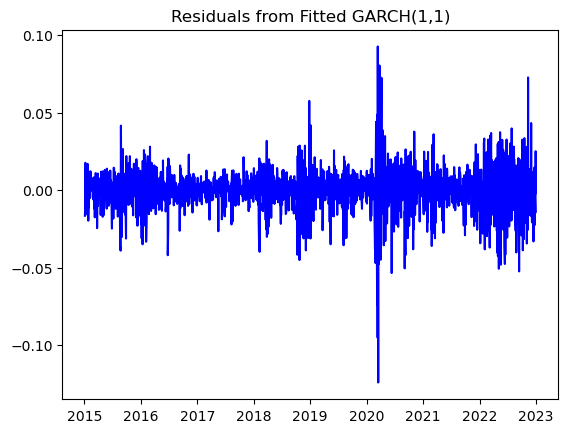

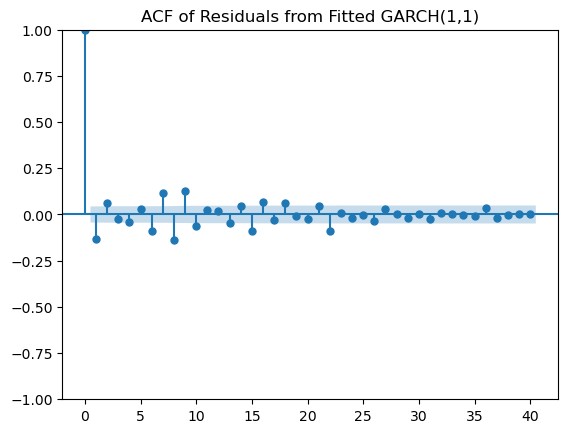

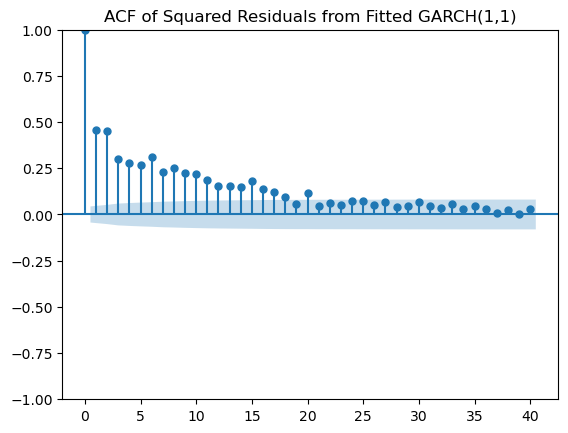

Confidence Intervals for GARCH(1,1) Parameters:              lower     upper
mu        0.000274  0.000295
omega     0.000004  0.000004
alpha[1]  0.009205  0.090795
alpha[2] -0.016534  0.116534
alpha[3] -0.026902  0.126902
alpha[4] -0.019960  0.119960
beta[1]  -0.358441  1.138441
beta[2]  -0.311014  1.091014
                     Constant Mean - GARCH Model Results                      
Dep. Variable:                  Close   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                6162.83
Distribution:                  Normal   AIC:                          -12309.7
Method:            Maximum Likelihood   BIC:                          -12264.8
                                        No. Observations:                 2013
Date:                Wed, May 08 2024   Df Residuals:                     2012
Time:                        11:34:24   Df Model:          

/Users/oscarromero/anaconda3/lib/python3.11/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001945. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


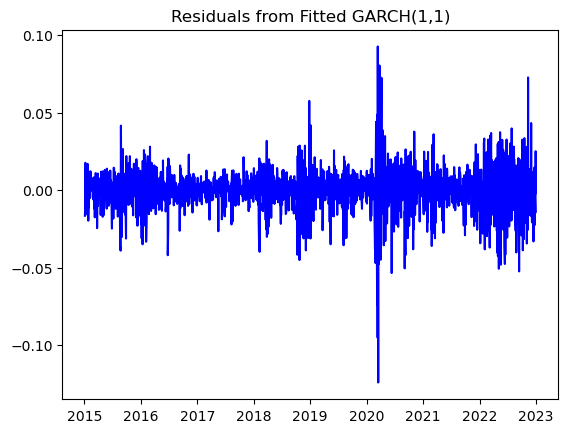

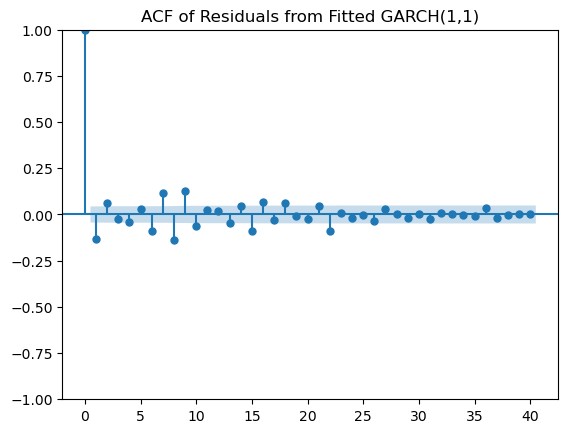

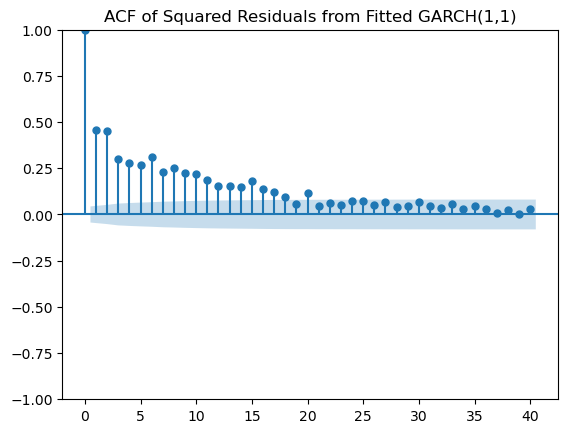

Confidence Intervals for GARCH(1,1) Parameters:              lower     upper
mu        0.000237  0.000345
omega     0.000004  0.000004
alpha[1]  0.010389  0.090676
alpha[2] -0.003947  0.103852
alpha[3] -0.062014  0.161911
alpha[4] -0.035591  0.135515
beta[1]  -1.020581  1.540041
beta[2]  -0.393921  0.913381
beta[3]  -1.004609  1.524068
                     Constant Mean - GARCH Model Results                      
Dep. Variable:                  Close   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                6162.74
Distribution:                  Normal   AIC:                          -12307.5
Method:            Maximum Likelihood   BIC:                          -12257.0
                                        No. Observations:                 2013
Date:                Wed, May 08 2024   Df Residuals:                     2012
Time:                        1

/Users/oscarromero/anaconda3/lib/python3.11/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001945. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


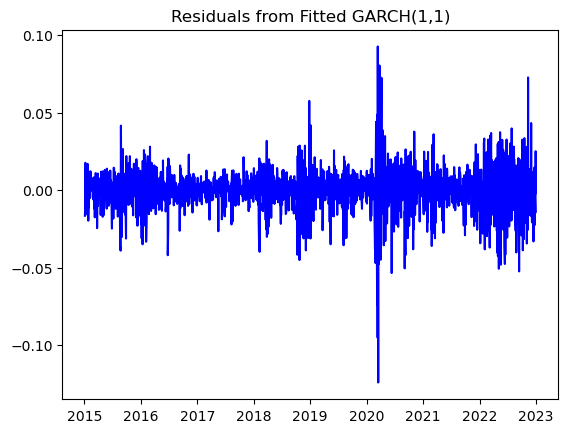

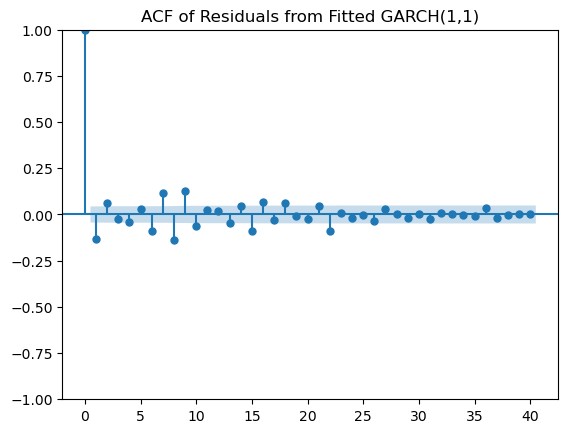

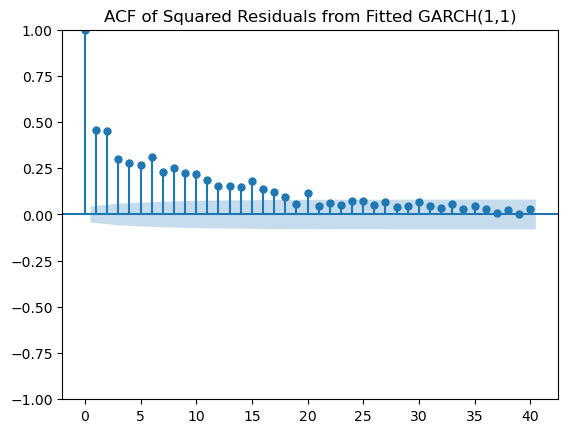

Confidence Intervals for GARCH(1,1) Parameters:              lower     upper
mu        0.000278  0.000301
omega     0.000004  0.000004
alpha[1]  0.008839  0.091161
alpha[2] -0.009360  0.109360
alpha[3]  0.005889  0.094111
alpha[4] -0.007307  0.107307
beta[1]  -0.488181  0.878181
beta[2]  -0.638184  1.028184
beta[3]  -0.439778  0.829778
beta[4]  -0.640279  1.030279
                     Constant Mean - GARCH Model Results                      
Dep. Variable:                  Close   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                6159.90
Distribution:                  Normal   AIC:                          -12299.8
Method:            Maximum Likelihood   BIC:                          -12243.7
                                        No. Observations:                 2013
Date:                Wed, May 08 2024   Df Residuals:                     2012
T

In [102]:
#Finally, let's fit a GARCH model to the S&P500 data and examine the results, including residuals and their autocorrelation.

from arch import arch_model

qs = [0,1,2,3,4]
ps = [1,2,3,4]
for p in ps:
    for q in qs:
        # Fitting a GARCH(1,1) model to Nasdaq daily returns
        # x was the data when removed the mean
        garch_model = arch_model(x, vol='GARCH', p=p, q=q)
        garch_fit = garch_model.fit(disp='off')  # Fit the model without verbose output

        # Plot the residuals
        plt.plot(garch_fit.resid, 'b-')
        plt.title("Residuals from Fitted GARCH(1,1)")
        plt.show()

        # ACF of the residuals
        plot_acf(garch_fit.resid, lags=40, alpha=0.05)
        plt.title("ACF of Residuals from Fitted GARCH(1,1)")
        plt.show()

        # ACF of squared residuals
        plot_acf(garch_fit.resid**2, lags=40, alpha=0.05)
        plt.title("ACF of Squared Residuals from Fitted GARCH(1,1)")
        plt.show()

        # Confidence intervals for the GARCH(1,1) parameters
        confidence_intervals = garch_fit.conf_int()
        print("Confidence Intervals for GARCH(1,1) Parameters:", confidence_intervals)

        # Display the fitted GARCH(1,1) model summary
        print(garch_fit.summary())

In [100]:
# Ljung-Box test for white noise
lb_test = acorr_ljungbox(garch_fit.resid, lags=[20], return_df=True)
print("Ljung-Box Test:", lb_test)

Ljung-Box Test:        lb_stat     lb_pvalue
20  218.970738  1.916128e-35


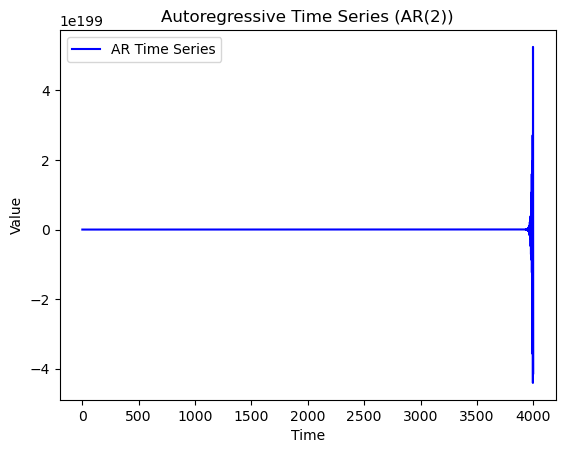

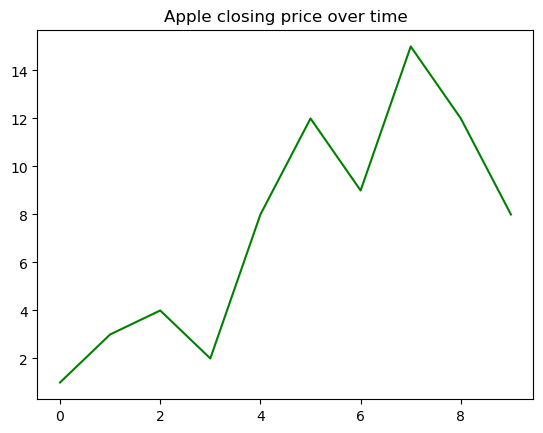

past windows: [[[ 1.]
  [ 3.]
  [ 4.]]

 [[ 3.]
  [ 4.]
  [ 2.]]

 [[ 4.]
  [ 2.]
  [ 8.]]

 [[ 2.]
  [ 8.]
  [12.]]

 [[ 8.]
  [12.]
  [ 9.]]

 [[12.]
  [ 9.]
  [15.]]

 [[ 9.]
  [15.]
  [12.]]]
future windows [[[ 4.]
  [ 2.]]

 [[ 2.]
  [ 8.]]

 [[ 8.]
  [12.]]

 [[12.]
  [ 9.]]

 [[ 9.]
  [15.]]

 [[15.]
  [12.]]

 [[12.]
  [ 8.]]]
[array([[-1.,  0.],
       [ 0.,  1.],
       [ 1.,  3.],
       [ 2.,  4.]]), array([[-1.,  0.],
       [ 0.,  3.],
       [ 1.,  4.],
       [ 2.,  2.]]), array([[-1.,  0.],
       [ 0.,  4.],
       [ 1.,  2.],
       [ 2.,  8.]]), array([[-1.,  0.],
       [ 0.,  2.],
       [ 1.,  8.],
       [ 2., 12.]]), array([[-1.,  0.],
       [ 0.,  8.],
       [ 1., 12.],
       [ 2.,  9.]]), array([[-1.,  0.],
       [ 0., 12.],
       [ 1.,  9.],
       [ 2., 15.]]), array([[-1.,  0.],
       [ 0.,  9.],
       [ 1., 15.],
       [ 2., 12.]])]
[array([[-1.,  0.],
       [ 0.,  4.],
       [ 1.,  2.]]), array([[-1.,  0.],
       [ 0.,  2.],
       [ 1.,  8.]]

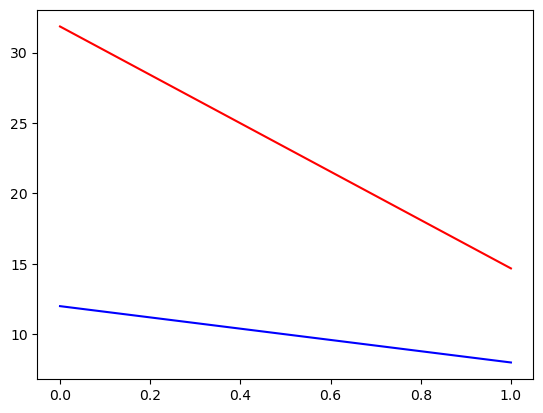

In [205]:
def checkWindowsSignatures():
    """prova = np.array([1.0, 3.0, 4.0, 2.0, 8.0, 12.0, 9.0, 15.0])
    series_augm = augment_path_image(prova)
    prova_df = pd.DataFrame(series_augm)
    past = GetWindows(prova_df, 3, 1)
    past_sig = compute_signatures(past, 4)
    #print(past_sig)
    future = GetFutureWindows(prova_df, 3, 1)
    future_sig = compute_signatures(future, 4)
    #print(future_sig)
    print(past)
    print(future)"""
    
    #We add the time variable in order to mantain uniqueness with the signature for each path
    data = np.array([1.0, 3.0, 4.0, 2.0, 8.0, 12.0, 9.0, 15.0, 12.0, 8.0])
    plt.plot(data, 'g-', label='AAPL close price')
    plt.title('Apple closing price over time')
    plt.show()
    train = data[:int(len(data)*0.8)]
    test = data[int(len(data)*0.8):]
    series_augm = augment_path_image(data)
    train_augm = series_augm[:len(train)]
    test_augm = series_augm[len(train):]


    h_windows = [3]
    f_window = 1

    for h_window in h_windows:

        #We compute the signatures for the windows
        series_augm_df = pd.DataFrame(data)
        series_windows = GetWindows(series_augm_df, h_window, f_window)
        series_future_windows = GetFutureWindows(series_augm_df, h_window, f_window)
        print("past windows:", series_windows)
        print("future windows", series_future_windows)
        
        series_windows_base = []
        for window in series_windows:
            elem = augment_path_image(window)
            series_windows_base.append(np.vstack([[-1,0], elem]))
        #print(series_windows_base)
        series_fut_windows_base = []
        for f_window in series_future_windows:
            elem = augment_path_image(f_window)
            series_fut_windows_base.append(np.vstack([[-1,0], elem]))
        print(series_windows_base)
        print(series_fut_windows_base)
        #Here we have all signatures for each window
        X_sig = compute_signatures(series_windows_base, 3)
        Y_sig = compute_signatures(series_fut_windows_base, 2)
        print("SIGNATURES")
        print(X_sig)
        print(Y_sig)


        #We use the GetNextMean with a future window of 1, so it is the same as the future value we want to predict
        #Y_real = np.array(GetNextMean(series_augm_df, h_window, f_window)[1])

        #Y_expected = np.array(arma_expected[h_window:])

        #We now separate between training and testing
        X_sig_train = X_sig[:len(train)-h_window]
        Y_sig_train = Y_sig[:len(train)-h_window]
        #print(X_sig_train)
        #print(Y_sig_train)
        #print(X_sig[-1])
        #print(data[-2]-data[-3])
        #print(len(test))

        X_sig_test = X_sig[len(train)-h_window:]
        Y_sig_test = Y_sig[len(train)-h_window:]
        #print(X_sig_test)
        #print(Y_sig_test)

        predictions_sig = list()

        #scaler = StandardScaler()
        #history_sig_scaled = scaler.fit_transform(X_sig_train)  # Scale features to have mean 0 and standard deviation 1
        lasso_model = trainning(X_sig_train, Y_sig_train)
        # walk-forward validation
        print("Hola")
        pre_predictions = lasso_model.predict(X_sig_test)
        yhat = []
        for pred in pre_predictions:
            yhat.append(pred[2])
        #print(yhat)
        #predictions_sig = yhat + data[len(train)-:-1]
        #print(predictions_sig)
        predictions_sig = yhat
        data_test = data[-len(predictions_sig):]
    
        # Plot forecasts against actual outcomes
        plt.plot(data_test, color='blue')
        plt.plot(predictions_sig, color='red')
        plt.show()

    
    return

# Define the AR coefficients (for an AR(2) process, with lag 1 and lag 2)
ar_coefficients = np.array([1., 0.6, 0.15, -1])  # AR(2) with coefficients [1, -0.5, -0.25]

# Create an AR process using `ArmaProcess`
ar_process = ArmaProcess(ar=ar_coefficients, ma=np.array([1]))  # MA(0), i.e., no MA part

# Generate a time series of 100 values
n_samples = 4000
ar_time_series = ar_process.generate_sample(nsample=n_samples)

# Plot the generated AR time series
plt.plot(ar_time_series, 'b-', label='AR Time Series')
plt.title('Autoregressive Time Series (AR(2))')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()
checkWindowsSignatures()

In [78]:
import datetime
# Get today's date

# Fetch daily data for a specific stock (e.g., Apple)
stock_symbol = "BTC-USD"
stock_data = yf.Ticker(stock_symbol)

# Get historical data with a specified range (e.g., 1 day)
daily_data = stock_data.history(period="1d")

# Check if the latest date in the data matches today's date
latest_date = daily_data.index[-1].date()

print("Latest data date:", latest_date)
print(daily_data["Close"].values[-1])

Latest data date: 2024-05-09
61021.16015625


[*********************100%%**********************]  1 of 1 completed


50000.0


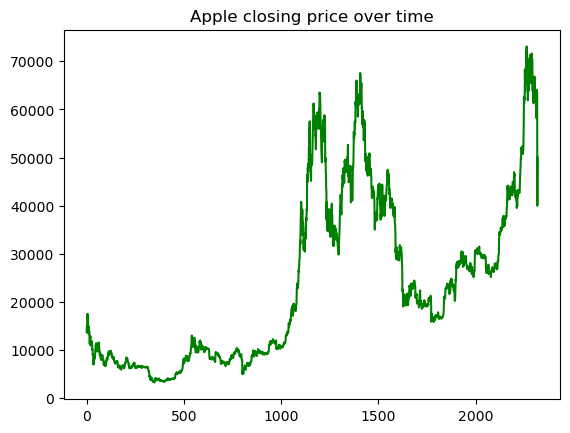

[[ 2316.         64031.1328125 ]
 [ 2317.         63161.94921875]
 [ 2318.         40000.        ]]
[[ 2318. 40000.]
 [ 2319. 50000.]]
[-14.404622314379875, -43.08493716242316, 43.894281512651595, 11.876544004657891, -14.537416103351376, -7.8891952015316615, -20.088831484866805, -24.20135230333143, 9.887312491444128, 4.8191695924554265, -29.632203269185187, -46.728165630198774, -1.2859957328146547, 4.271374789292414, -5.170322455693334, 18.47382444041148, 134.23966163084017, 61.135461123370106, -7.697388712235723, 45.17115940090094, -11.47320610789749, 2.1033654328183937, 1.4260457326696376, -25.793399883324987, -20.745113352819228, -29.722484024754966, -35.89794185620114, 14.623187470415054, 14.040116397637533, -17.55602567535534, -2.086822585003089, 12.317974218042664, -31.65941919753996, -50.0392794545647, 1.010241438339369, 1.5008286089631193, -10.711354053511968, -25.58628043774946, -19.94889209936424, -51.56213564386108, 8.328366674455626, 106.72528232410062, 86.93420462539284, 8

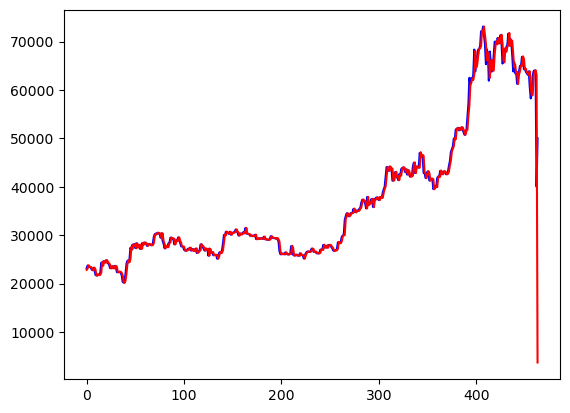

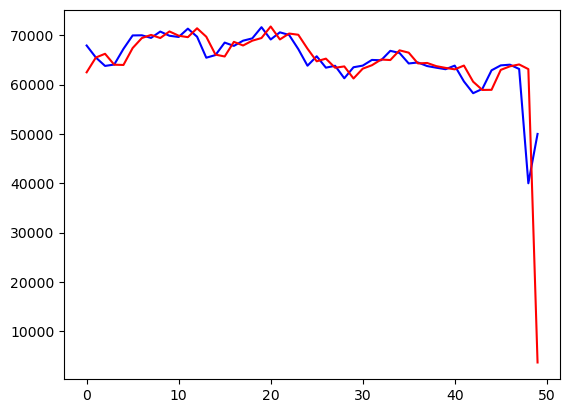

Test MSE: 7007739.1629759
R^2: 0.9955722032484838
Adjusted R^2: 0.9955626399725627
                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.996
Model:                            OLS   Adj. R-squared (uncentered):              0.996
Method:                 Least Squares   F-statistic:                          1.041e+05
Date:                Thu, 09 May 2024   Prob (F-statistic):                        0.00
Time:                        13:40:39   Log-Likelihood:                         -4314.2
No. Observations:                 464   AIC:                                      8630.
Df Residuals:                     463   BIC:                                      8634.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err     

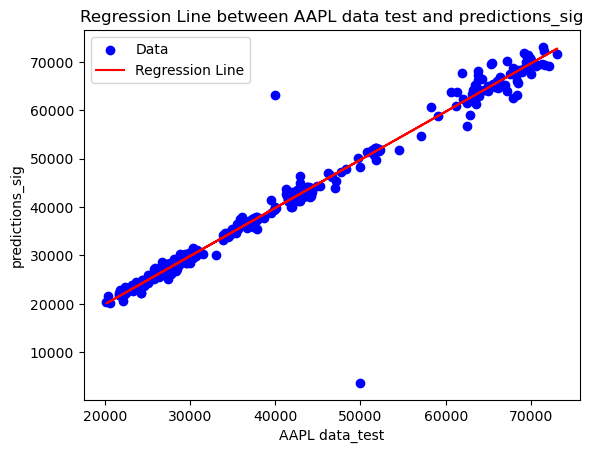

In [141]:
#We add the time variable in order to mantain uniqueness with the signature for each path
data = yf.download("BTC-USD", start="2018-01-01", end="2024-05-07")["Close"].values
data = np.concatenate([data,np.array([40000.0, 50000.0])])
print(data[-1])
plt.plot(data, 'g-', label='AAPL close price')
plt.title('Apple closing price over time')
plt.show()
train = data[:int(len(data)*0.8)]
test = data[int(len(data)*0.8):]
series_augm = augment_path_image(data)
train_augm = series_augm[:len(train)]
test_augm = series_augm[len(train):]


h_windows = [3]
f_window = 1

for h_window in h_windows:

    #We compute the signatures for the windows
    series_augm_df = pd.DataFrame(series_augm)
    series_windows = GetWindows(series_augm_df, h_window, f_window)
    series_future_windows = GetFutureWindows(series_augm_df, h_window, f_window)

    #Here we have all signatures for each window
    X_sig = compute_signatures(series_windows, 4)
    Y_sig = compute_signatures(series_future_windows, 4)
    print(series_windows[-1])
    print(series_future_windows[-1])
    

    #We use the GetNextMean with a future window of 1, so it is the same as the future value we want to predict
    #Y_real = np.array(GetNextMean(series_augm_df, h_window, f_window)[1])
    
    #Y_expected = np.array(arma_expected[h_window:])

    #We now separate between training and testing
    X_sig_train = X_sig[:len(train)-h_window]
    Y_sig_train = Y_sig[:len(train)-h_window]
    #print(X_sig[-1])
    #print(data[-2]-data[-3])
    #print(len(test))

    X_sig_test = X_sig[len(train)-h_window:]
    Y_sig_test = Y_sig[len(train)-h_window:]

    predictions_sig = list()

    #scaler = StandardScaler()
    #history_sig_scaled = scaler.fit_transform(X_sig_train)  # Scale features to have mean 0 and standard deviation 1
    lasso_model = trainning(X_sig_train, Y_sig_train)
    # walk-forward validation
    pre_predictions = lasso_model.predict(X_sig_test)
    yhat = []
    for pred in pre_predictions:
        yhat.append(pred[2])
    print(yhat)
    predictions_sig = yhat + data[len(train)-1:-1]
    print(pre_predictions)
    """ yhat = predict[0][2] + data[len(train)+i]
        #yhat = predict[0][2]
        predictions_sig.append(yhat)
        #test_sig_scaled = scaler.transform(X_sig_test)
        predict = lasso_model.predict(X_sig_test[i].reshape(1, -1))
        yhat = predict[0][2] + data[len(train)+i]
        #yhat = predict[0][2]
        predictions_sig.append(yhat)"""
    
    
    data_test = data[-len(predictions_sig):]
    
    # Plot forecasts against actual outcomes
    plt.plot(data_test, color='blue')
    plt.plot(predictions_sig, color='red')
    plt.show()
    plt.plot(data_test[-50:], color='blue')
    plt.plot(predictions_sig[-50:], color='red')
    plt.show()
    
    # Calculate MSE
    mse = 0
    for i in range(len(data_test)):
        mse += (data_test[i] - predictions_sig[i]) ** 2
    mse = mse / len(data_test)
    print('Test MSE: %.7f' % mse)
    
    # Fit a simple linear regression model
    model = sm.OLS(predictions_sig, data_test).fit()

    # Calculate R^2 and adjusted R^2
    r_squared = model.rsquared
    adjusted_r_squared = model.rsquared_adj

    print("R^2:", r_squared)
    print("Adjusted R^2:", adjusted_r_squared)

    # Display the regression summary
    print(model.summary())

    # Scatter plot with regression line
    plt.scatter(data_test, predictions_sig, color='blue', label='Data')
    plt.plot(data_test, model.predict(data_test), color='red', label='Regression Line')
    plt.xlabel('AAPL data_test')
    plt.ylabel('predictions_sig')
    plt.legend()
    plt.title("Regression Line between AAPL data test and predictions_sig")
    plt.show()

#PROVA DEFINITIVA **ARIMA**

In [70]:

#Import libraries 
import inspect
import time
import warnings
import matplotlib.pyplot as plt
import pandas as pd
import plotly.express as px
import seaborn as sns
import pandas_datareader.data as web

from sklearn.metrics import mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA

warnings.filterwarnings("ignore")
#Get the stock quote
# Download historical of American airlines stock
aal_data = yf.download("^GSPC", start="2018-01-01", end="2024-05-07")

# Select adjusted closing prices
aal_data = aal_data['Adj Close']

# Calculate log returns
y = np.log(aal_data / aal_data.shift(1)).dropna()
print(y.head)

[*********************100%%**********************]  1 of 1 completed

<bound method NDFrame.head of Date
2018-01-03    0.006378
2018-01-04    0.004021
2018-01-05    0.007009
2018-01-08    0.001661
2018-01-09    0.001302
                ...   
2024-04-30   -0.015856
2024-05-01   -0.003441
2024-05-02    0.009087
2024-05-03    0.012479
2024-05-06    0.010273
Name: Adj Close, Length: 1595, dtype: float64>


In [27]:
mean=np.mean(y)
vol=np.std(y)

print(f'The seasonal average return of NVDA is: {mean}, The seasonal volatility of NVDA is: {vol}')


The seasonal average return of NVDA is: 0.0004095606338097467, The seasonal volatility of NVDA is: 0.012828440250892784


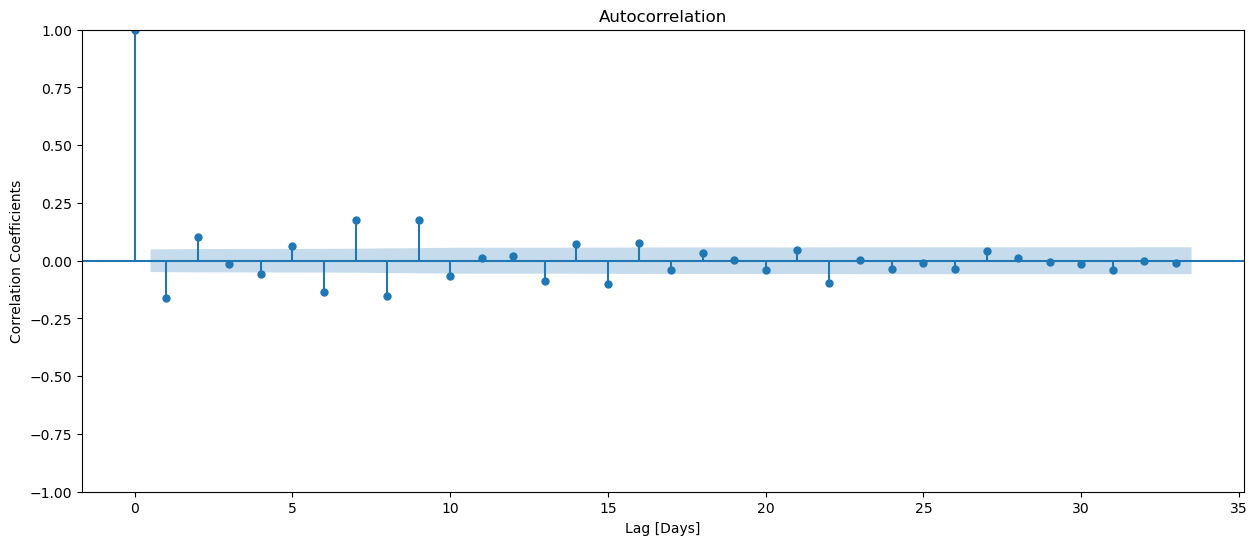

In [28]:
fig, ax = plt.subplots(figsize= (15,6))
plot_acf(y, ax = ax)
plt.xlabel("Lag [Days]")
plt.ylabel("Correlation Coefficients");

In [29]:
print(y.corr(y.shift(1)))
print(y.shift(1).corr(y.shift(2)))

-0.16306675638595866
-0.16359693310484683


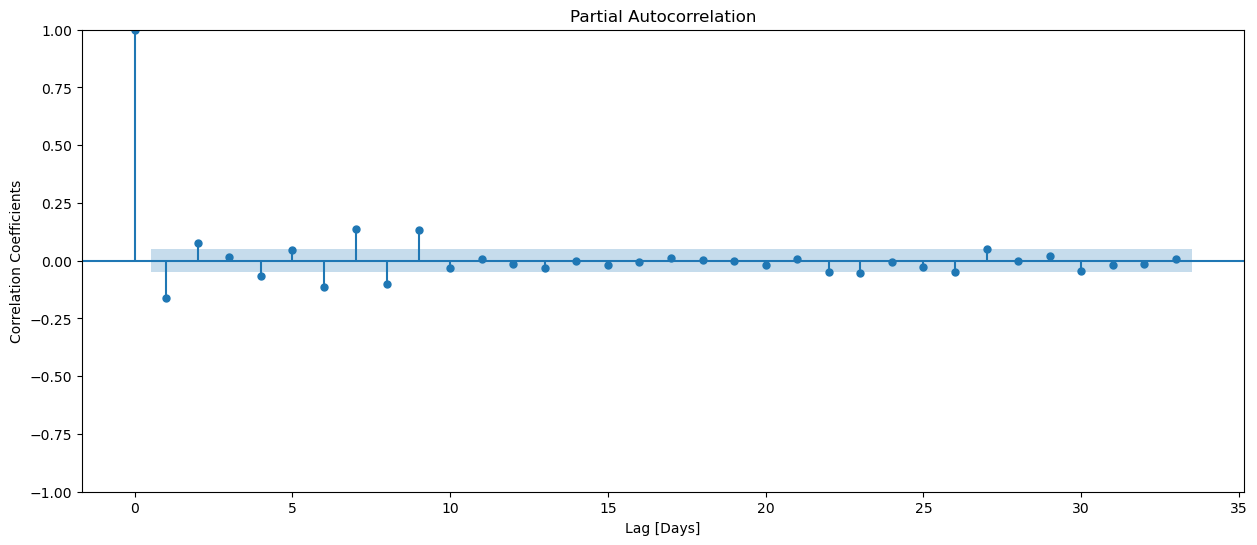

In [30]:
fig, ax = plt.subplots(figsize=(15,6))
plot_pacf(y, ax=ax)
plt.xlabel("Lag [Days]")
plt.ylabel("Correlation Coefficients");

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=-7355.368, Time=0.27 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-7309.317, Time=0.11 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-7348.870, Time=0.08 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-7341.711, Time=0.10 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-7357.113, Time=0.32 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=-7358.266, Time=0.17 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=-7357.663, Time=0.31 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-7351.994, Time=0.11 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=-7355.447, Time=0.41 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=-7356.974, Time=0.32 sec

Best model:  ARIMA(0,0,2)(0,0,0)[0]          
Total fit time: 2.217 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1276
Model:               SARIMAX(0, 0, 2)   Log Likeliho

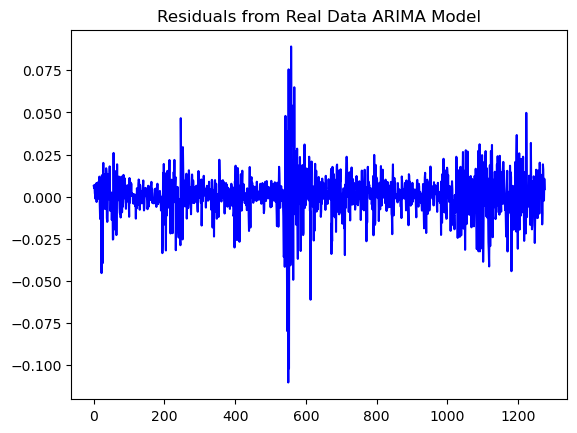

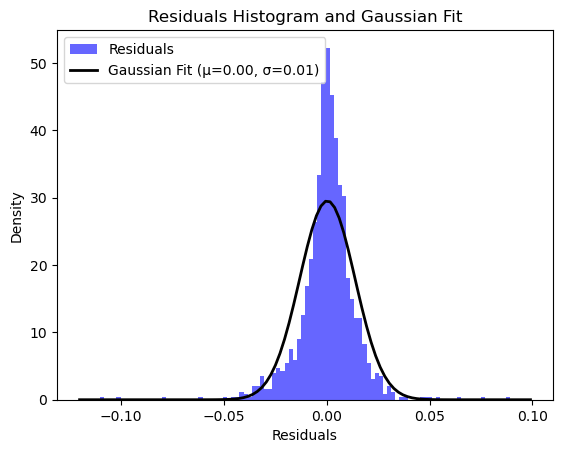

In [71]:
# Find the best ARIMA model for real data (train)
y = np.array(y)
train = y[:int(len(y)*0.8)]
test = y[int(len(y)*0.8):]
auto_model_real = auto_arima(train, seasonal=False, trace=True)
print(auto_model_real.summary())

# Residuals for real data
residuals = auto_model_real.resid()
plt.plot(residuals, 'b-', label='Residuals')
plt.title('Residuals from Real Data ARIMA Model')
plt.show()

# Plot the histogram of residuals
plt.hist(residuals, bins=100, density=True, alpha=0.6, color='b', label='Residuals')

# Fit a Gaussian distribution to the residuals
mu, std = norm.fit(residuals)  # Mean and standard deviation of the fitted Gaussian

# Generate points for the Gaussian distribution
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)  # Gaussian probability density function

# Plot the Gaussian distribution
plt.plot(x, p, 'k', linewidth=2, label=f'Gaussian Fit (μ={mu:.2f}, σ={std:.2f})')

# Add plot details
plt.title('Residuals Histogram and Gaussian Fit')
plt.xlabel('Residuals')
plt.ylabel('Density')
plt.legend()
plt.show()
plt.show()

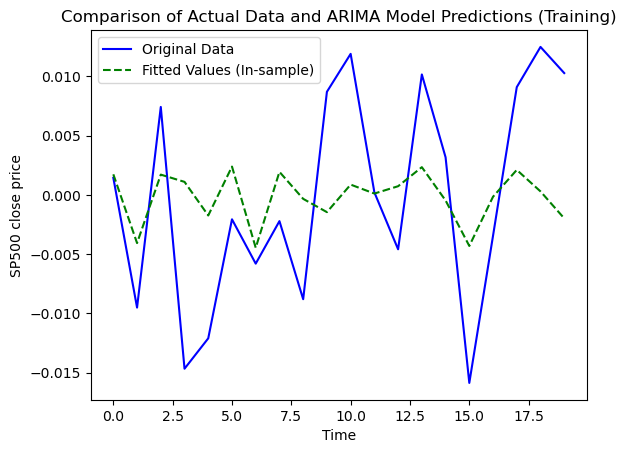

In [72]:
# Generate predictions for the range of the data
fitted_values = auto_model_real.predict_in_sample()  # Fitted values within the sample range

# Plot the actual data
plt.plot(y[-20:], 'b-', label='Original Data')

# Plot the fitted values (predictions from the model)
plt.plot(fitted_values[-20:], 'g--', label='Fitted Values (In-sample)')

# Add plot details
plt.title('Comparison of Actual Data and ARIMA Model Predictions (Training)')
plt.xlabel('Time')
plt.ylabel('SP500 close price')
plt.legend()
plt.show()

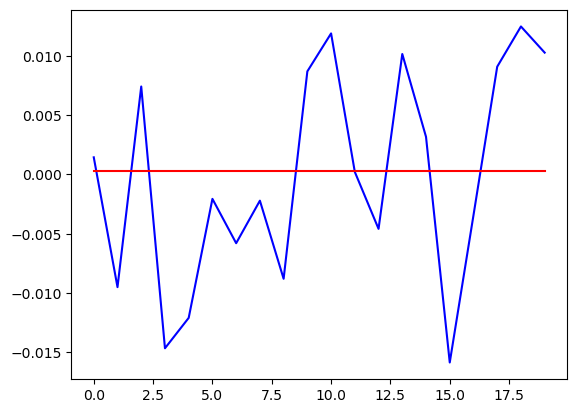

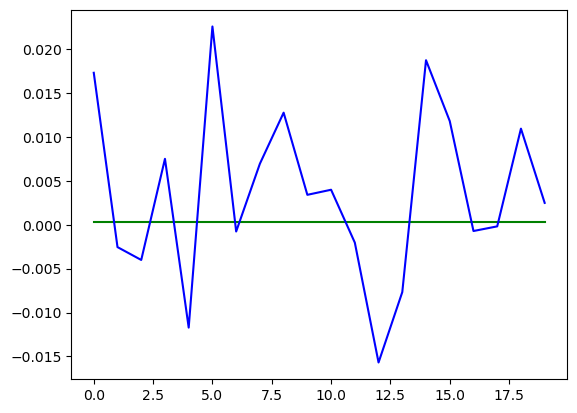

Test MSE: 0.000


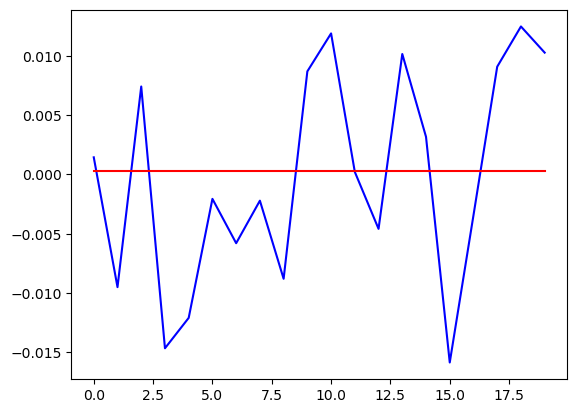

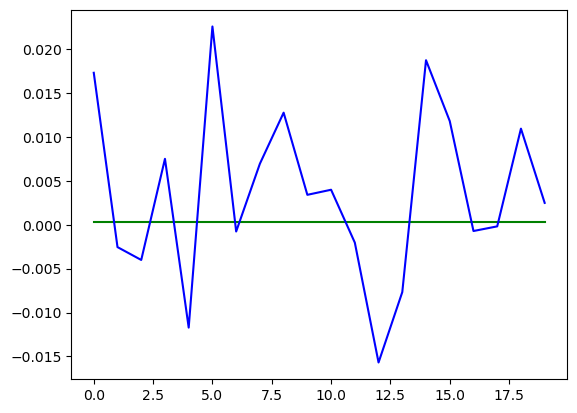

Test MSE: 0.000


In [73]:
#PREDICT USING SIGNATURE
#We use the arma_series for the past and expected value for the future in order to train, then test with expected arma_series
h_windows = [6, 8]

for h_wind in h_windows:
    predictions_sig, train_predictions, y_real = predictions_signature(y, [], int(len(y)*0.8), h_wind, h_wind, 3)
    #print(lasso_model.coef_)
    y_test = y[-len(predictions_sig):]

    # Plot forecasts against actual outcomes
    plt.plot(y_test[-20:], color='blue')
    plt.plot(predictions_sig[-20:], color='red')
    plt.show()
    
    train_pred = []
    for pred in train_predictions:
        train_pred.append(pred[2])
        
    train_real = []
    for real in y_real:
        train_real.append(real[2])
    
    # Plot forecasts against actual outcomes
    plt.plot(train_pred[-20:], color='green')
    plt.plot(train_real[-20:], color='blue')
    plt.show()


    # Calculate MSE
    mse = 0
    for i in range(len(y_test)):
        mse += (y_test[i] - predictions_sig[i]) ** 2
    mse = mse / len(y_test)
    print('Test MSE: %.3f' % mse)